In [1]:
%load_ext autoreload
%autoreload 2

import time
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset, MultiCombinedDataset
from memflow.callbacks.transfer_flow_callbacks import *
from memflow.models.custom_flows import *

from memflow.HH.HH import *
from memflow.HH.ttbar import *
from memflow.HH.DY import *
from memflow.HH.ZZ import *
from memflow.HH.ZH import *
from memflow.HH.ST import *

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

# Datasets

Checking particle quantities
	Particle(s) ('H1',) : required {2}, found {2}
	Particle(s) ('H2',) : required {2}, found {2}
	Particle(s) ('bottom',) : required {1}, found {1}
	Particle(s) ('antibottom',) : required {1}, found {1}
	Particle(s) ('W_plus',) : required {0, 1}, found {0, 1}
	Particle(s) ('W_minus',) : required {0, 1}, found {0, 1}
	Particle(s) ('Z1',) : required {0, 2}, found {0, 2}
	Particle(s) ('Z2',) : required {0, 2}, found {0, 2}
	Particle(s) ('W_plus', 'W_minus', 'Z1') : required {2}, found {2}
	Particle(s) ('lep_plus_from_W', 'lep_minus_from_W', 'neutrino_from_W', 'antineutrino_from_W') : required {0, 4}, found {0, 4}
	Particle(s) ('quark_up_from_W', 'quark_down_from_W', 'antiquark_up_from_W', 'antiquark_down_from_W') : required {0}, found {0}
	Particle(s) ('lep_plus_from_Z', 'lep_minus_from_Z', 'neutrino_from_Z', 'antineutrino_from_Z') : required {0, 4}, found {0, 4}
	Particle(s) ('quark_up_from_Z', 'quark_down_from_Z', 'antiquark_up_from_Z', 'antiquark_down_from_Z')

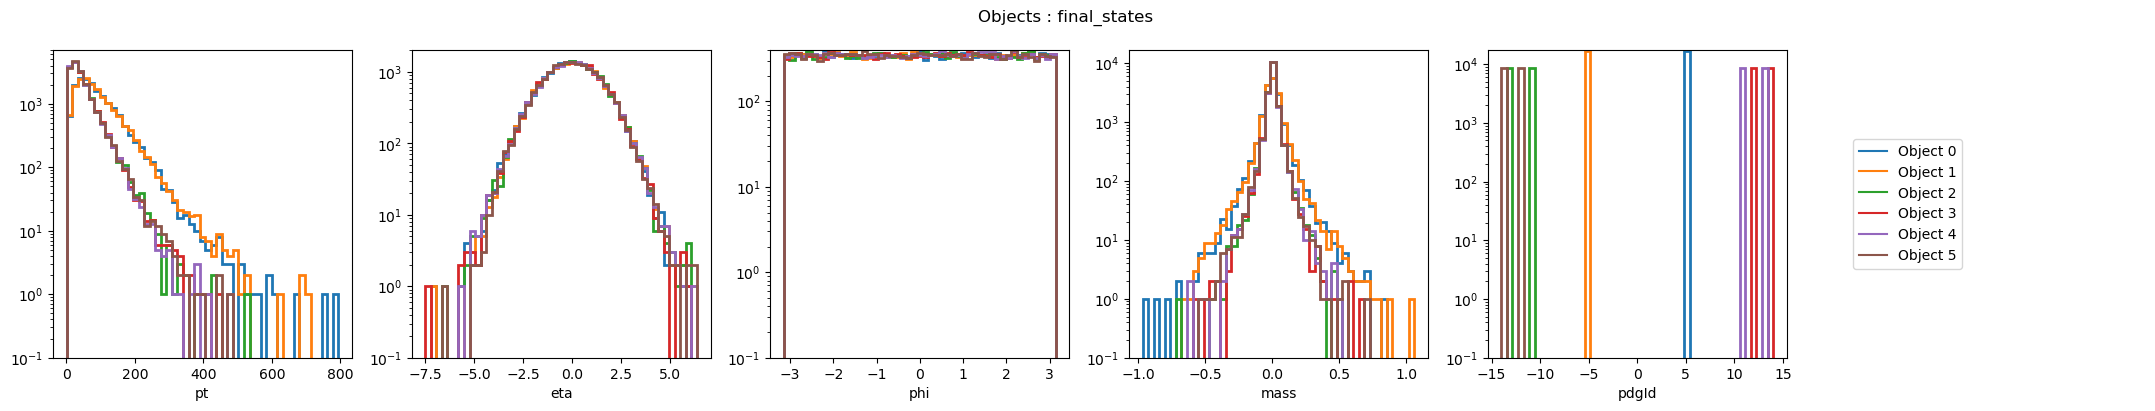

After preprocessing


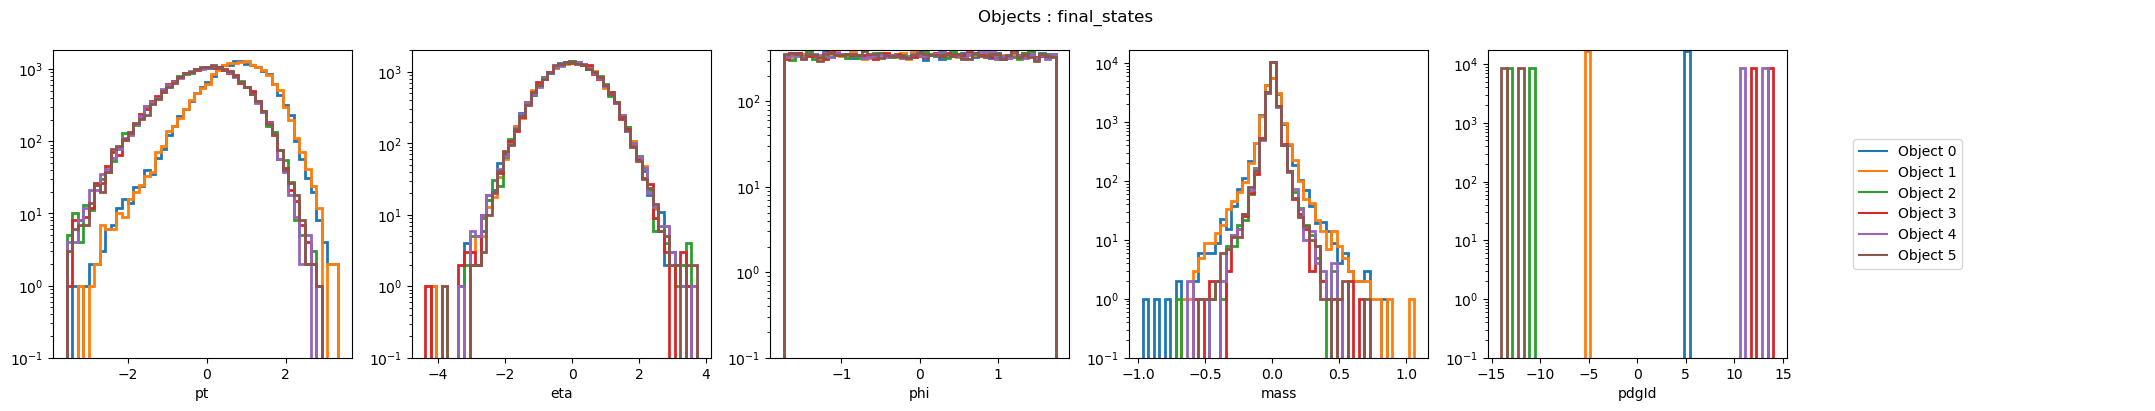

Initial HH: 40000
Resolved SR : 5121
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/hh_reco
Before preprocessing


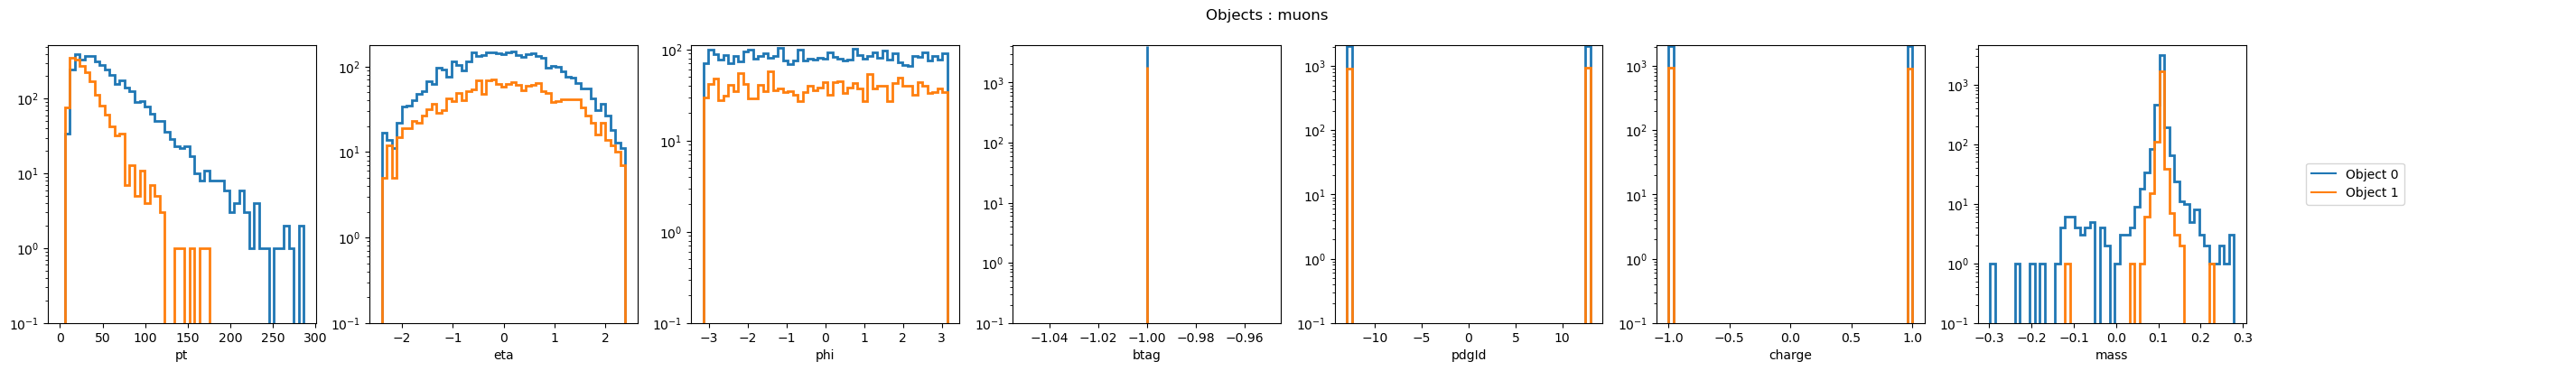

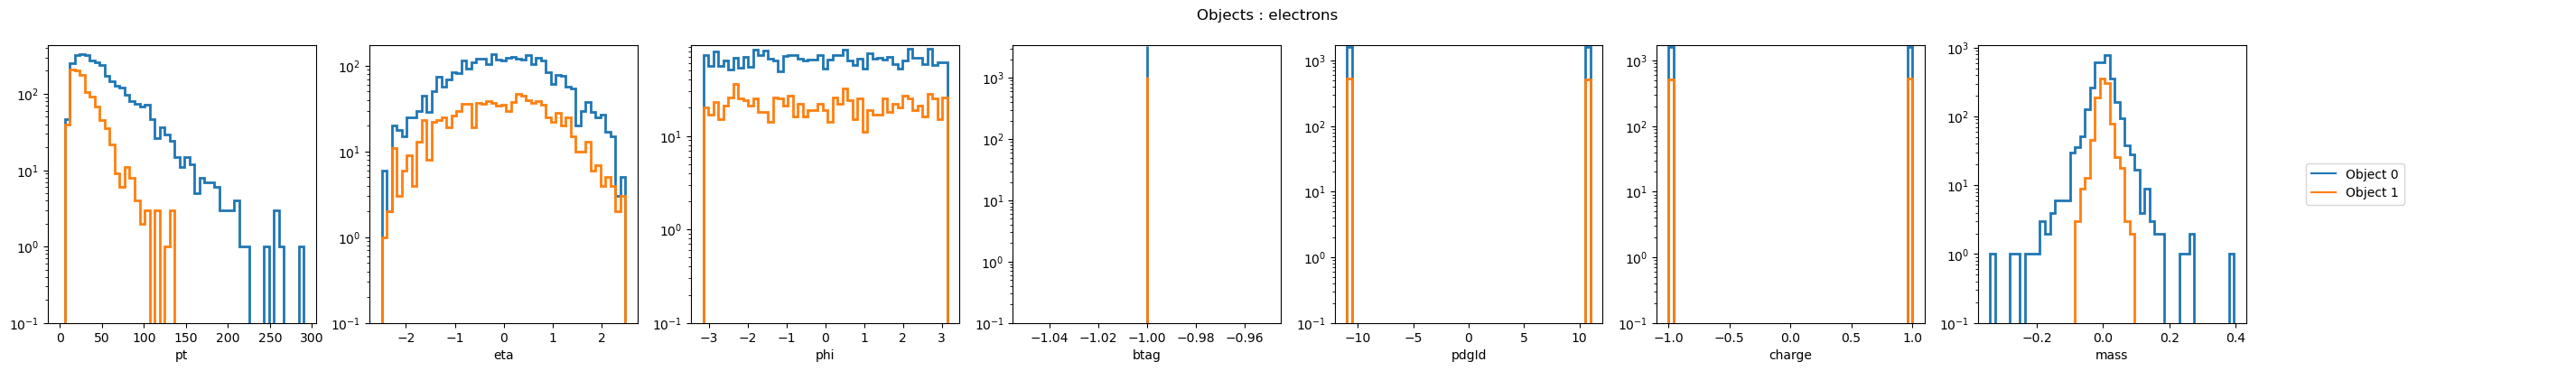

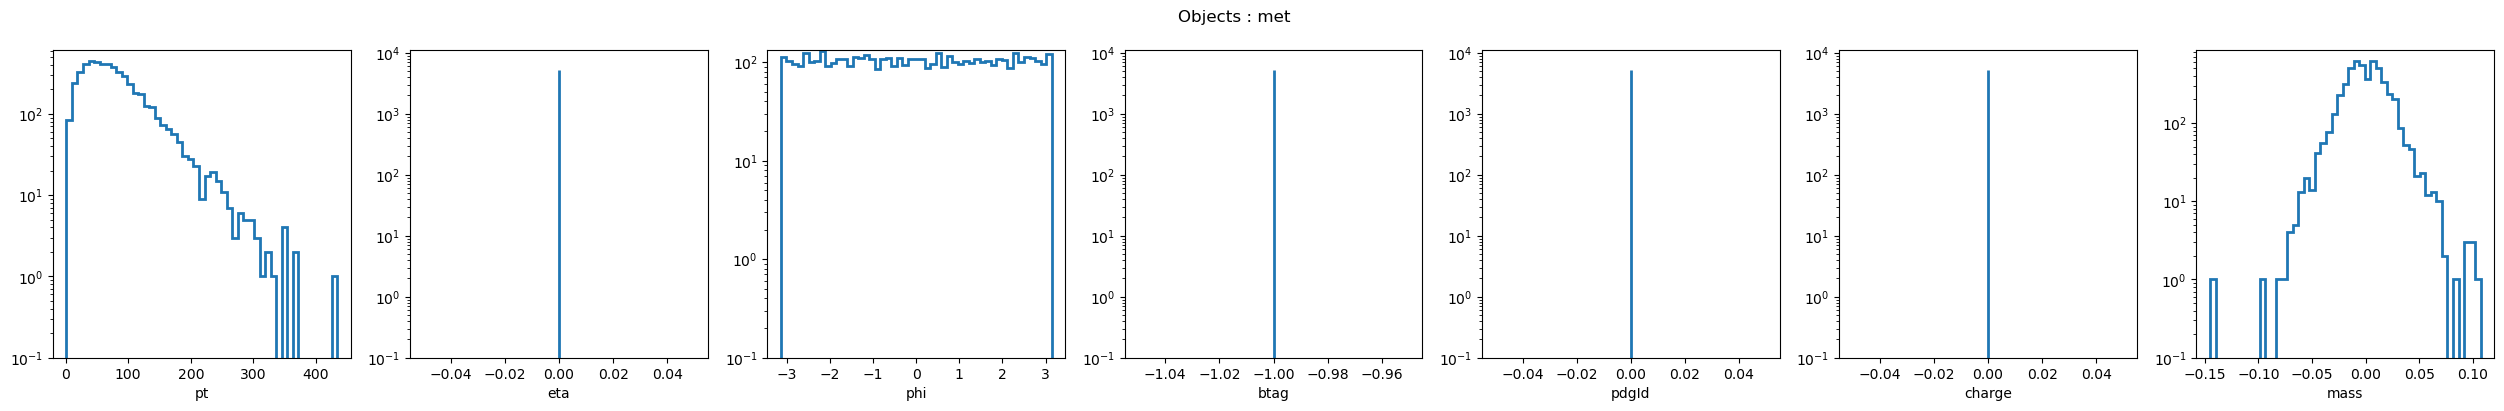

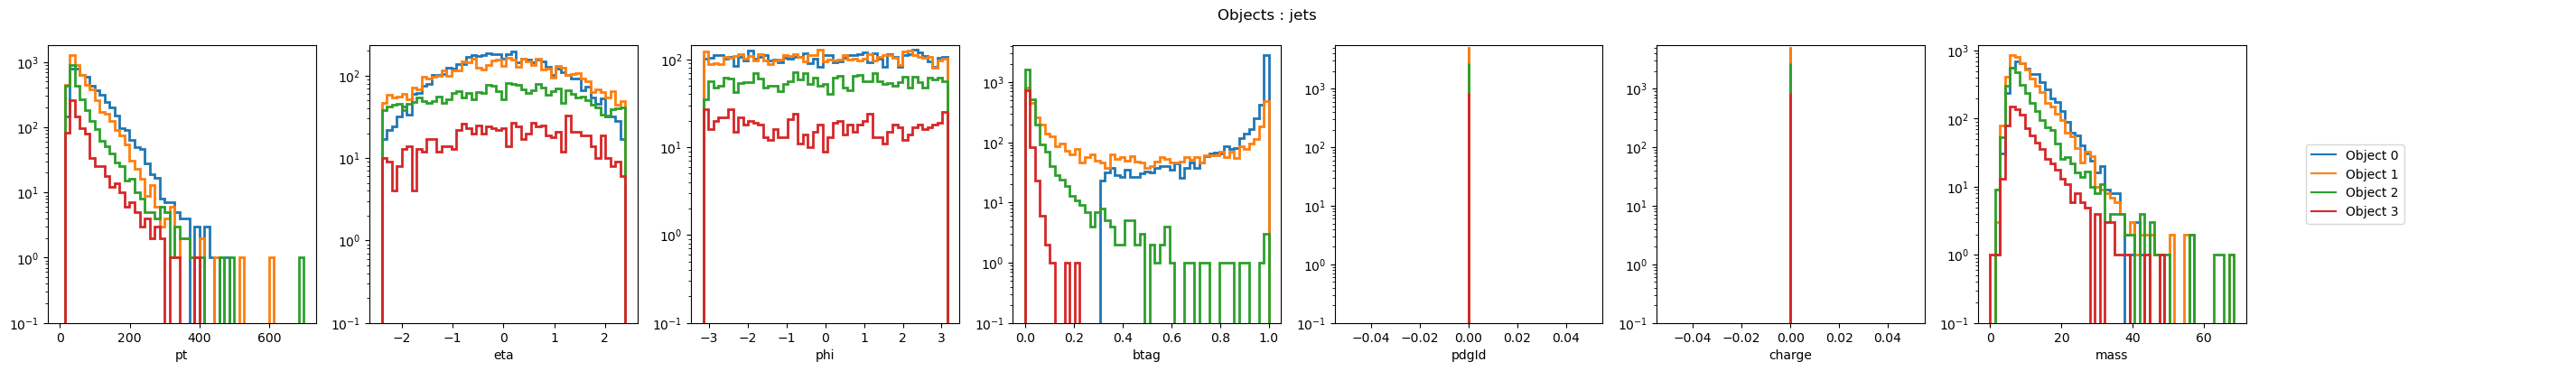

After preprocessing


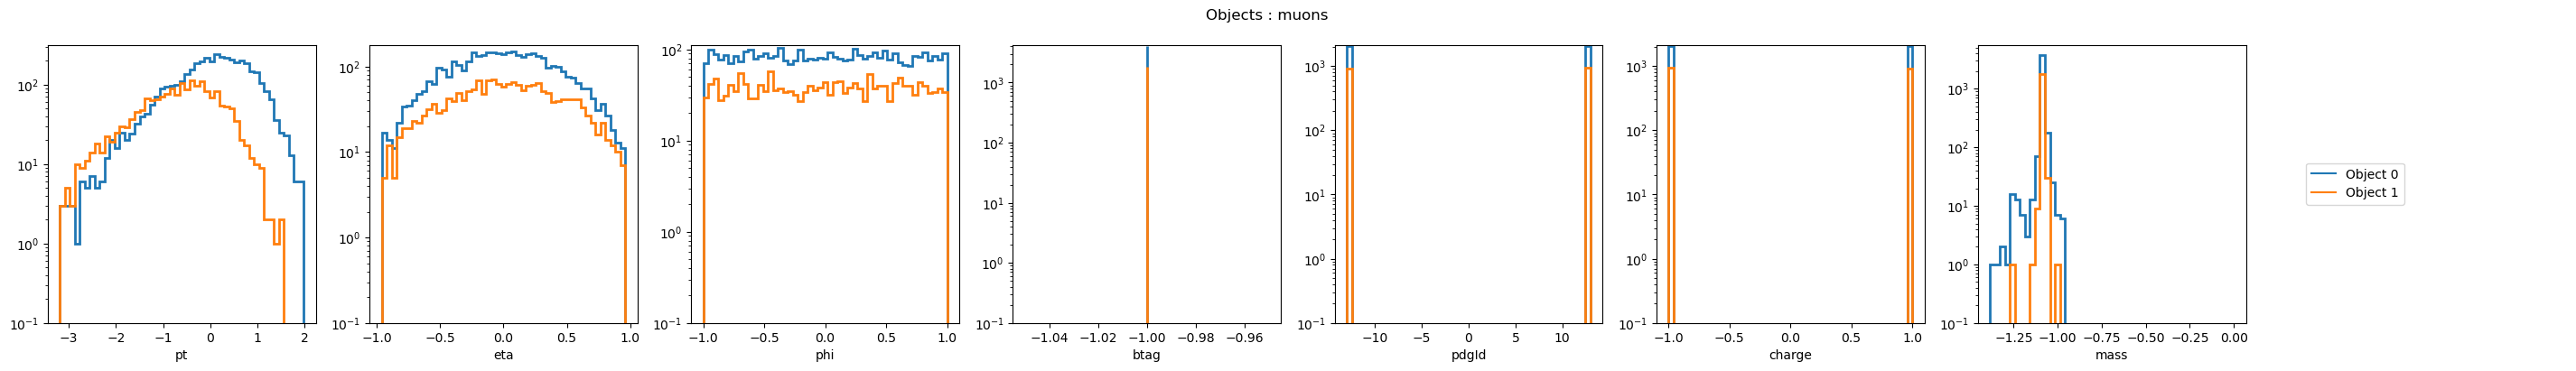

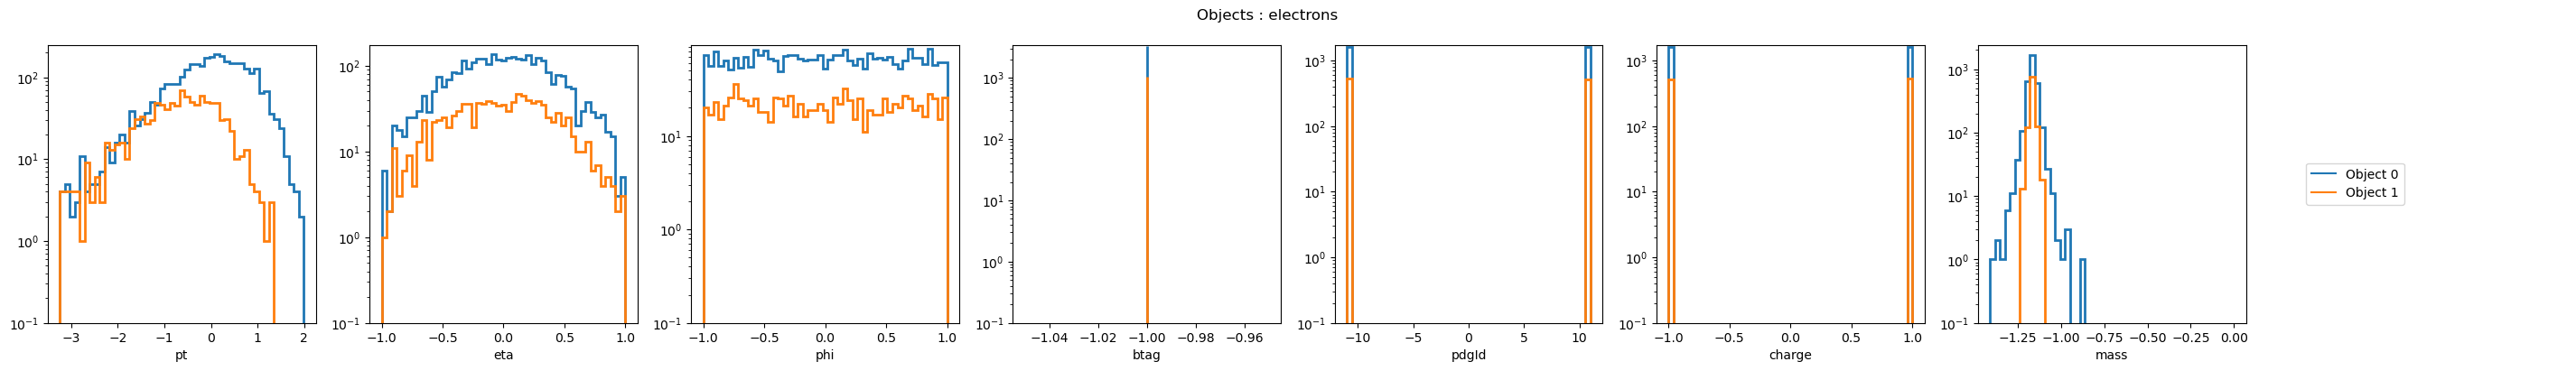

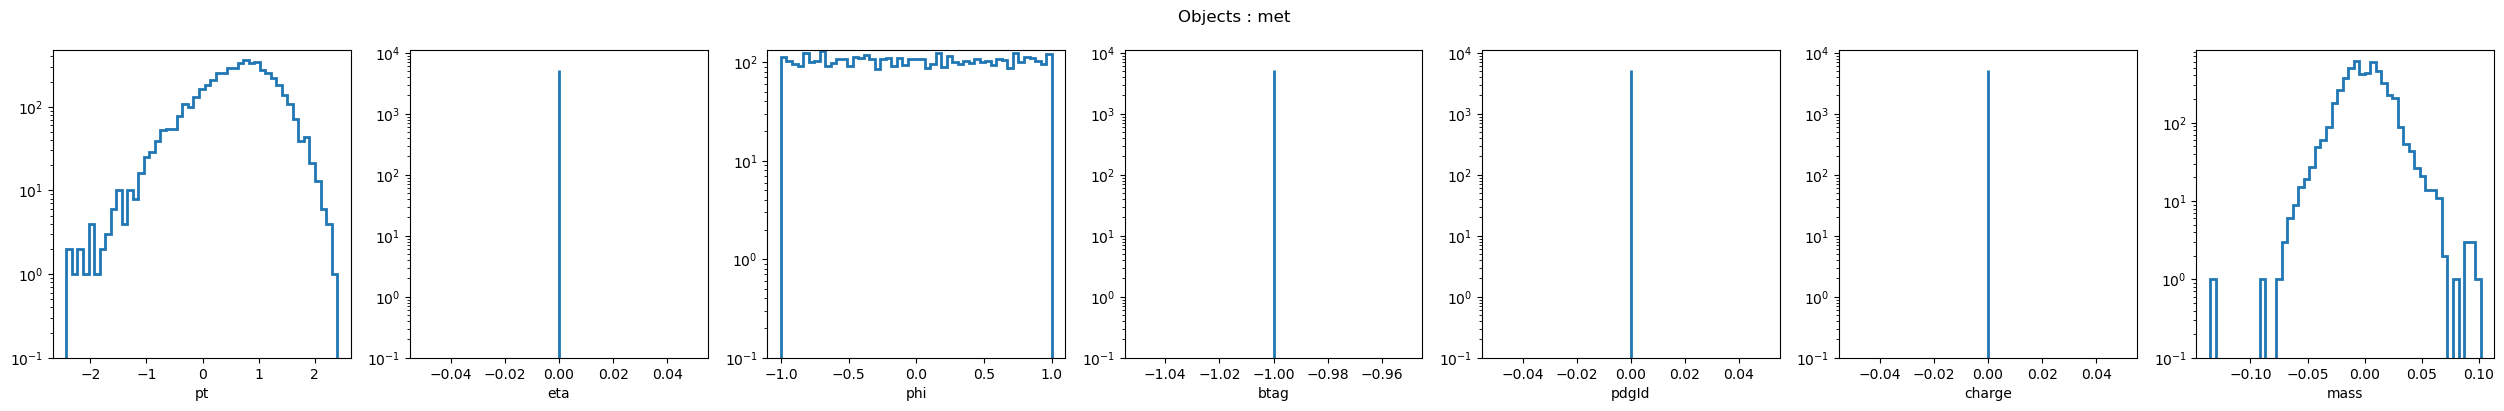

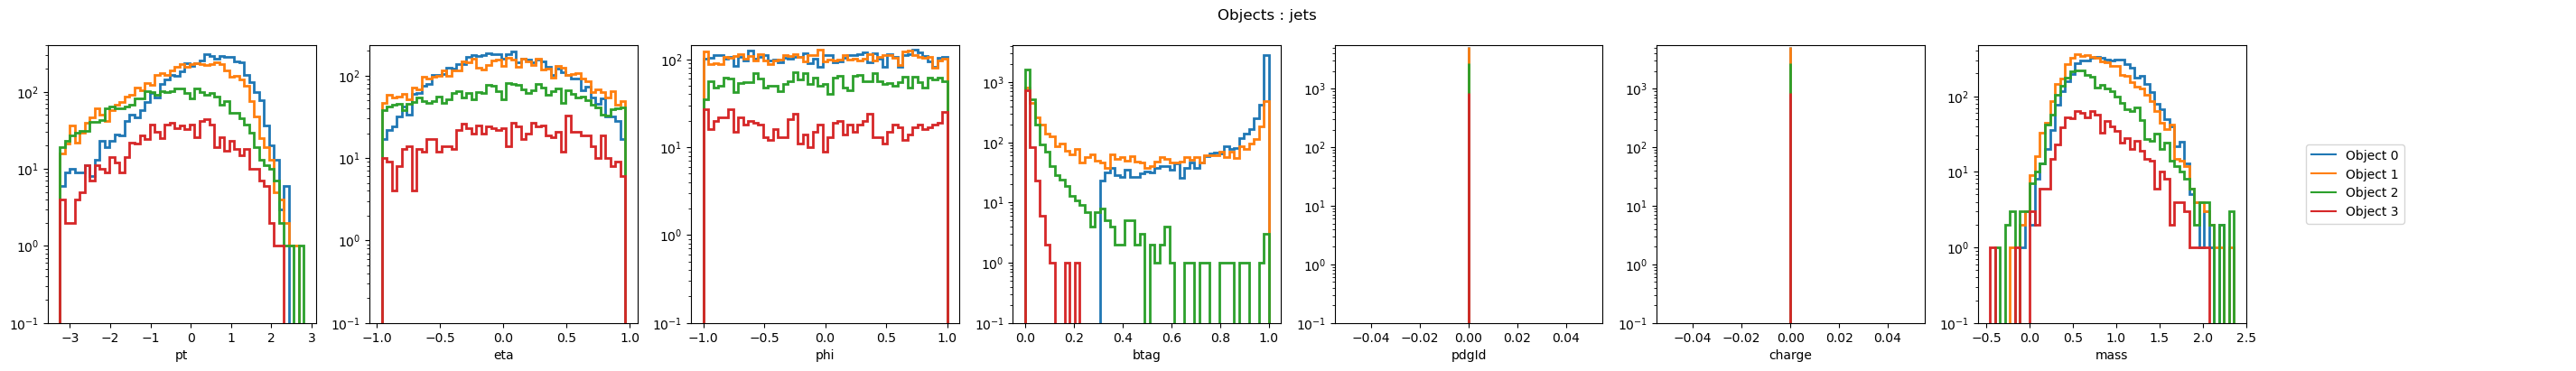

Looking into file metadata
	entry 0 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
	entry 1 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
Will only consider common files : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B

In [2]:
##### Hard-scattering data #####
hard_data_HH = RootData(
    files = [
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root',
    ],
    treenames = [
        'gen_HH;1',
    ],
    lazy = True,
    N = int(1e4),
)

##### Hard-scattering dataset #####
hard_dataset_HH = HHbbWWDoubleLeptonHardDataset(
    data = hard_data_HH,
    selection = [
        'final_states',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
hard_dataset_HH.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset_HH.plot(selection=True,raw=False,log=True)

##### Reconstructed data #####
reco_data_HH = RootData(
    files = hard_data_HH.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = int(1e4),
)
print ('Initial HH:',reco_data_HH.events)

reco_data_HH.cut(
    np.logical_and.reduce(
        (
            reco_data_HH['flag_SR']==1, 
            reco_data_HH['flag_resolved']==1,
            reco_data_HH['n_AK4']<= 4,
        )
    )
)
print ('Resolved SR :',reco_data_HH.events)

##### Reconstructed dataset #####
reco_dataset_HH = HHbbWWDoubleLeptonRecoDataset(
    data = reco_data_HH,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)

print ('Before preprocessing')
reco_dataset_HH.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset_HH.plot(selection=True,raw=False,log=True)

##### Combined dataset #####
comb_dataset_HH = CombinedDataset(
    hard_dataset = hard_dataset_HH,
    reco_dataset = reco_dataset_HH,
    intersection_branch = 'event',
)
print (comb_dataset_HH)

# TT datasets

Checking particle quantities
	Particle(s) ('top',) : required {1}, found {1}
	Particle(s) ('antitop',) : required {1}, found {1}
	Particle(s) ('bottom',) : required {1}, found {1}
	Particle(s) ('antibottom',) : required {1}, found {1}
	Particle(s) ('W_plus_from_top',) : required {1}, found {1}
	Particle(s) ('W_minus_from_antitop',) : required {1}, found {1}
	Particle(s) ('lep_plus', 'lep_minus', 'neutrino', 'antineutrino') : required {4}, found {4}
	Particle(s) ('quark_up', 'quark_down', 'antiquark_up', 'antiquark_down') : required {0}, found {0}
... done, no problem found
Selecting 20000 events out of 20000
From 20000, removing 10988 tau decay events
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/tt_hard
No final state recorded with `final_states_object_name` property, will not compute PS points
Before preprocessing


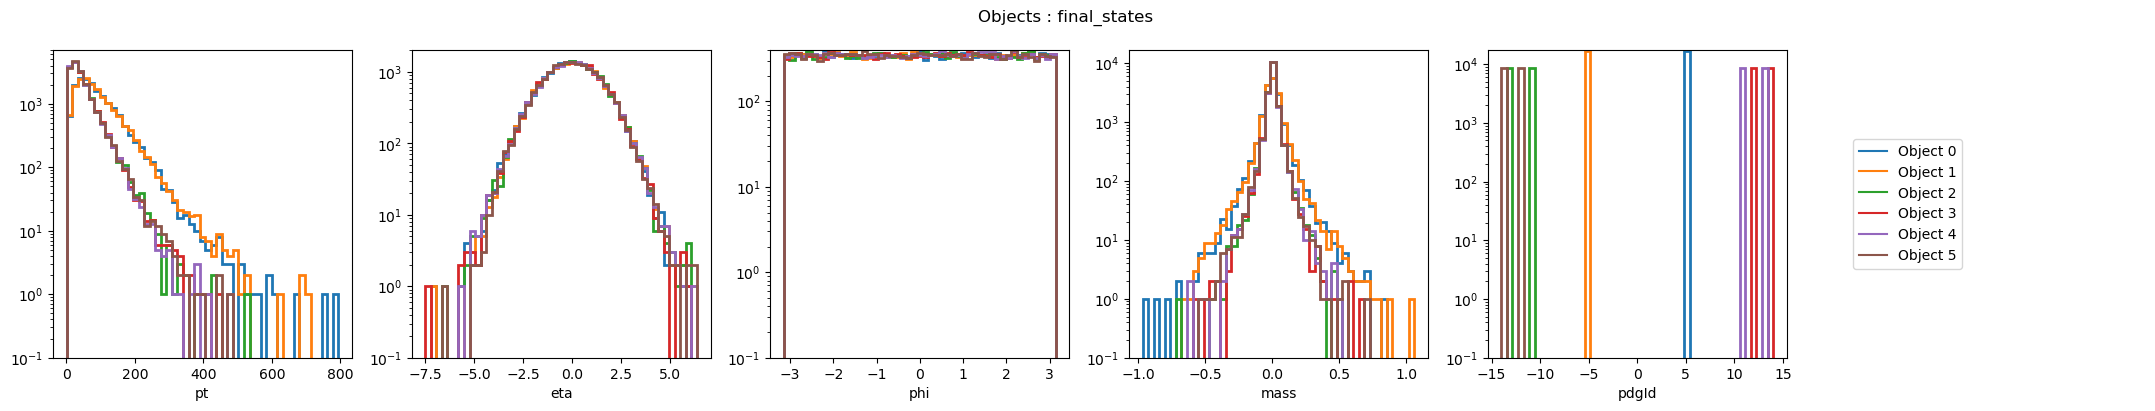

After preprocessing


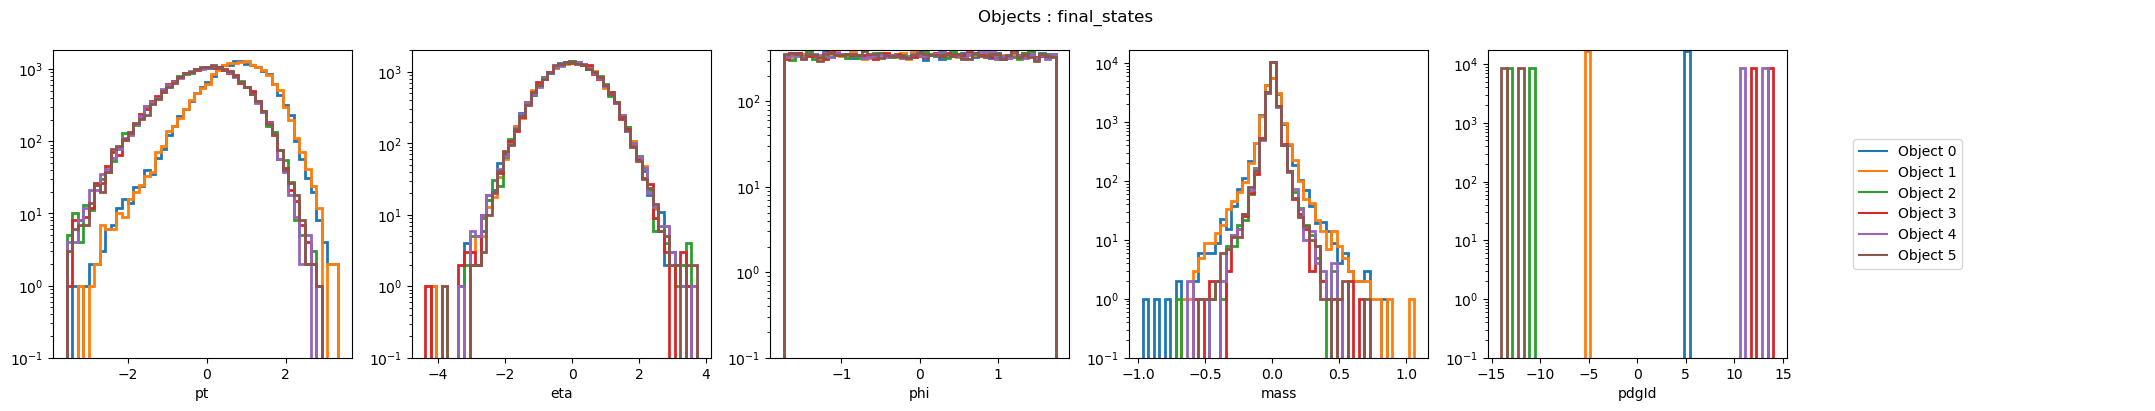

Initial TT: 20000
Resolved SR : 3596
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/hh_reco
Before preprocessing


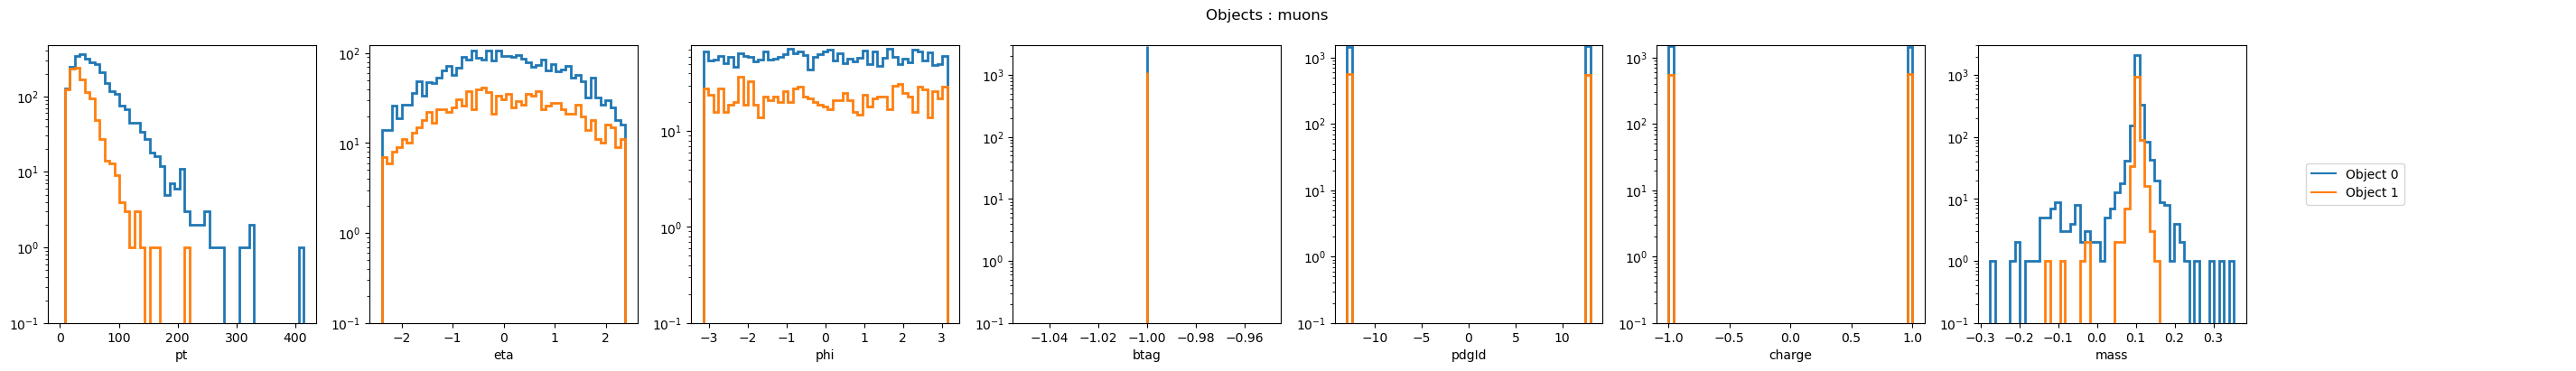

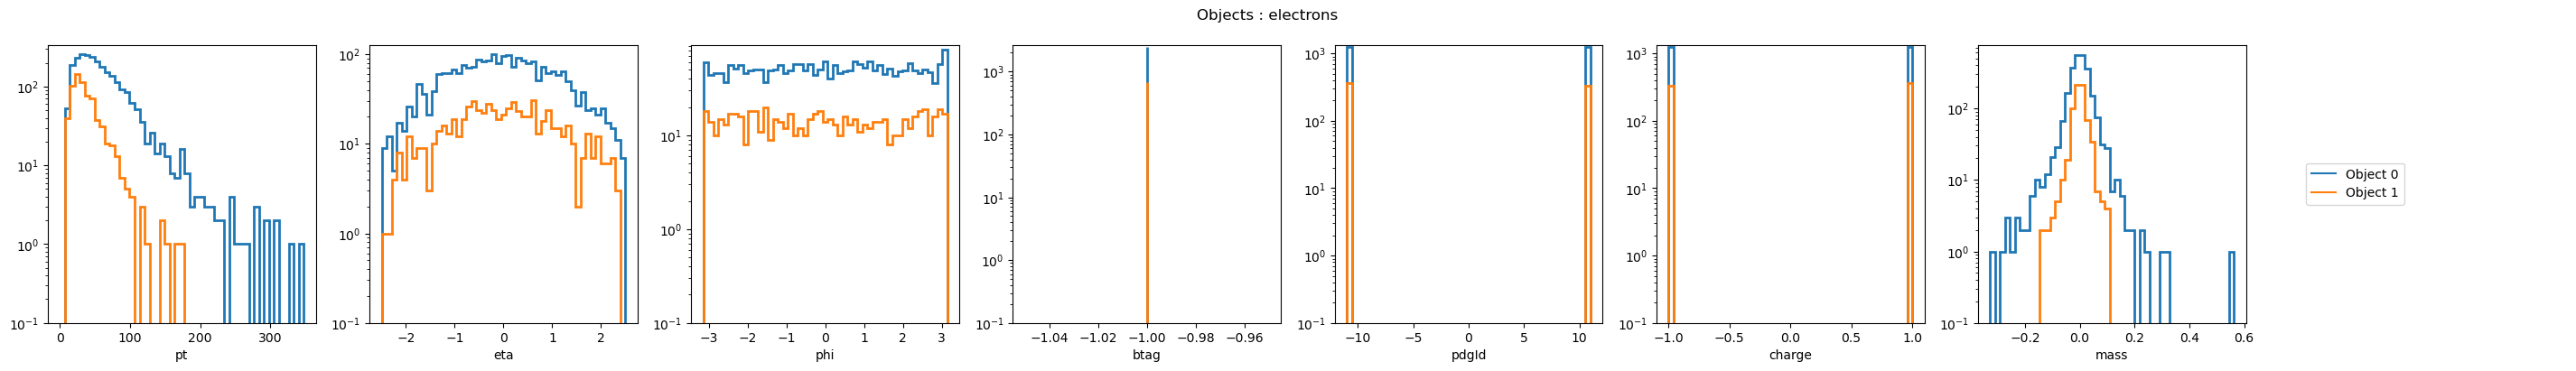

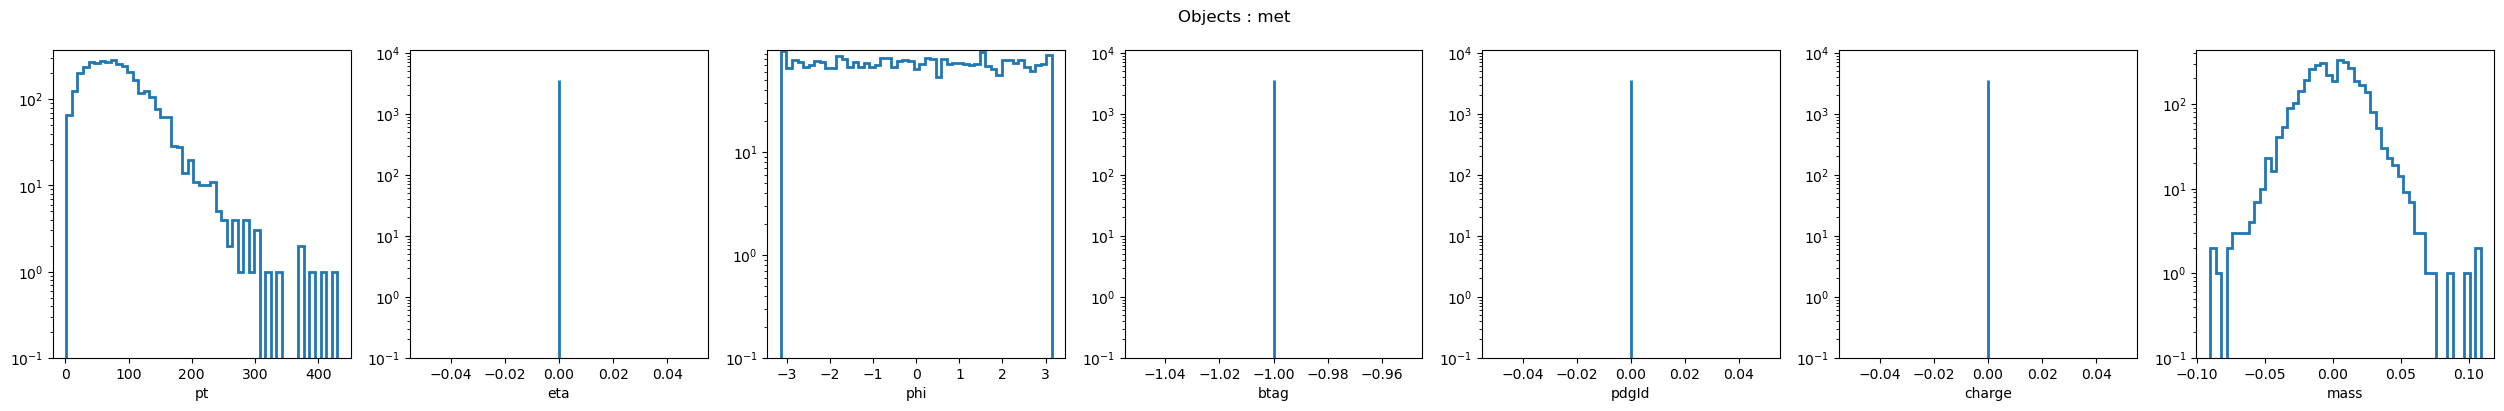

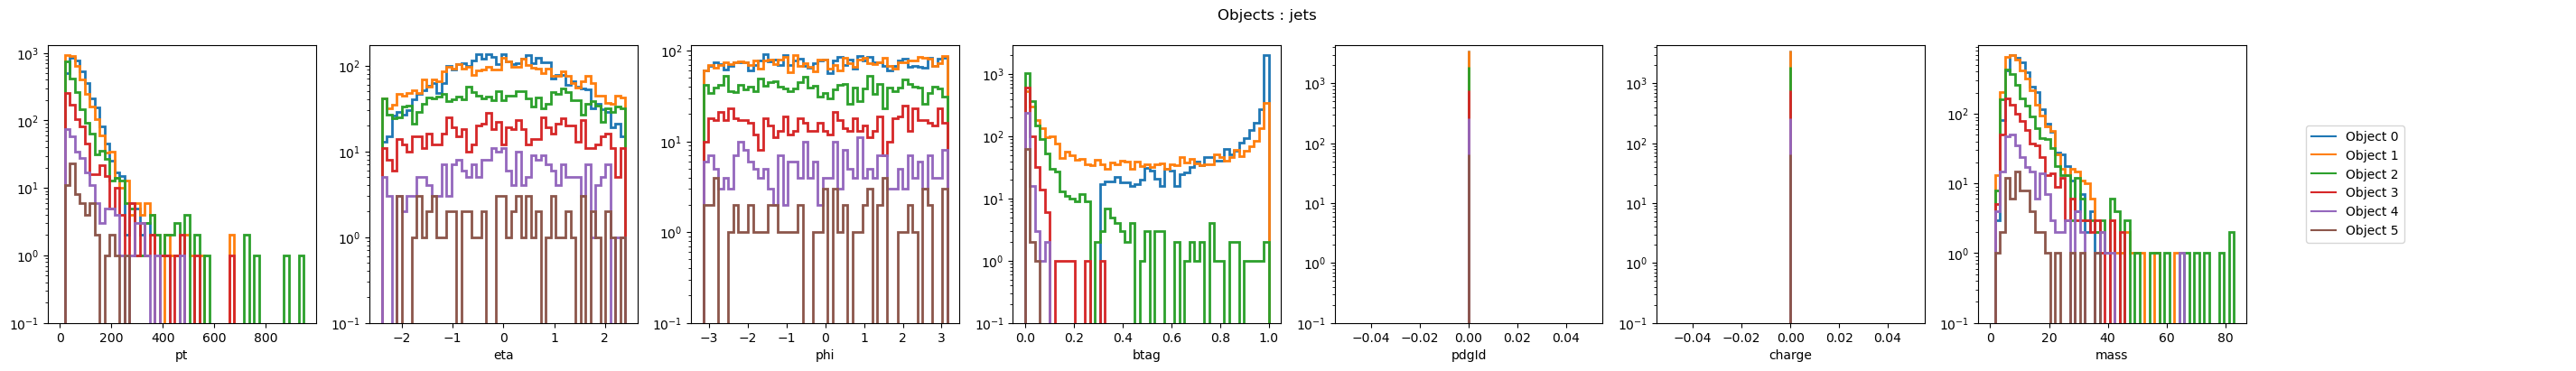

After preprocessing


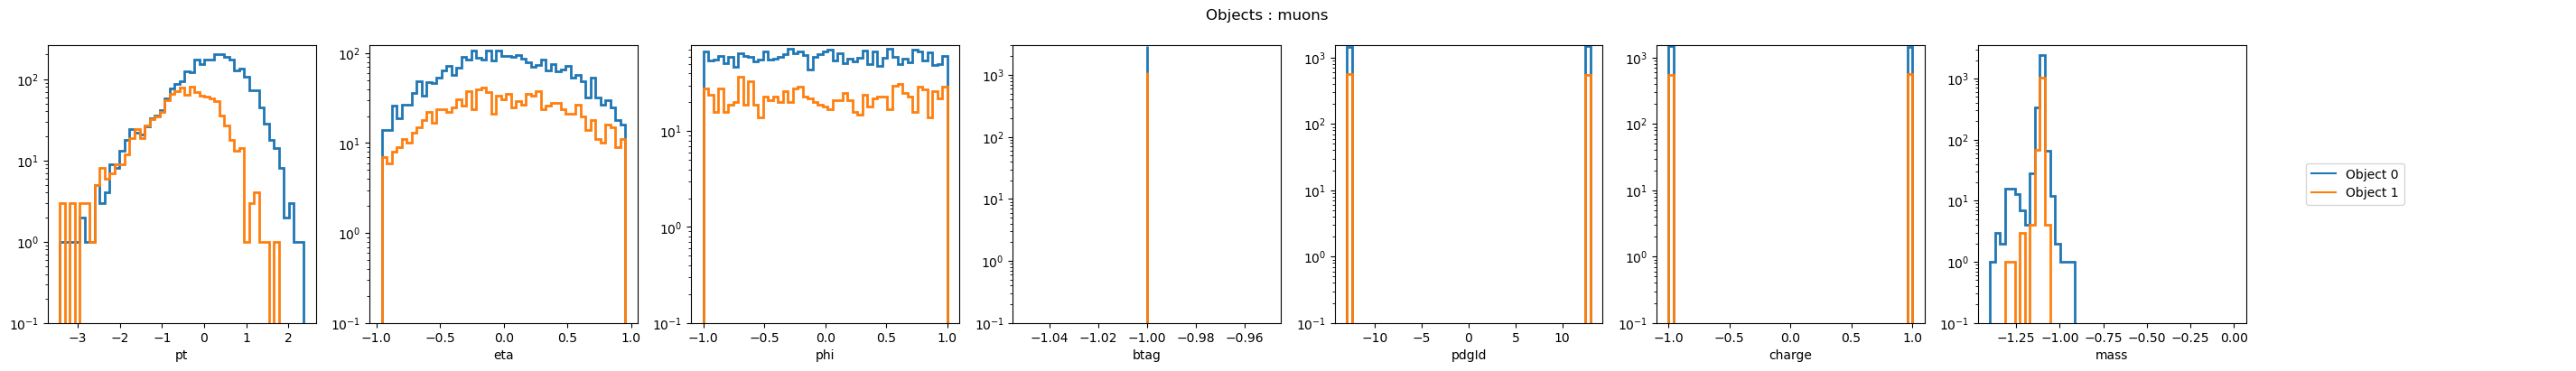

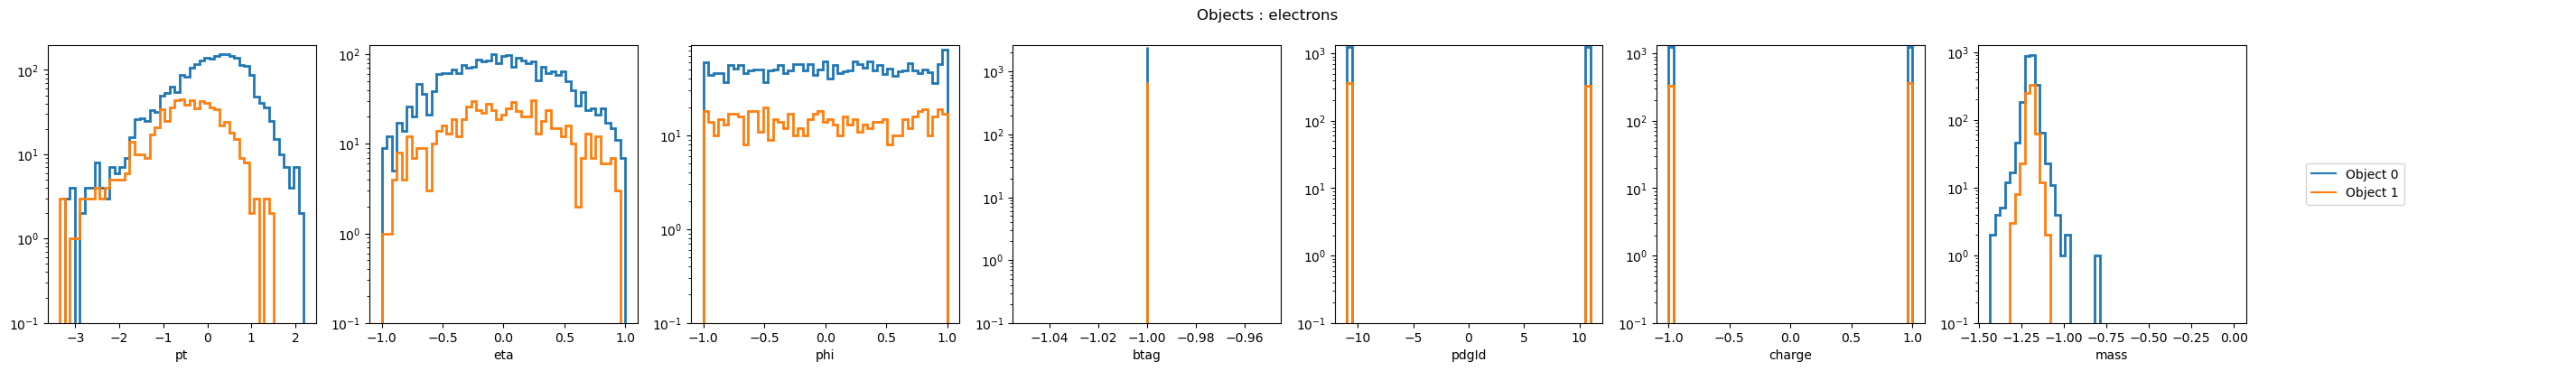

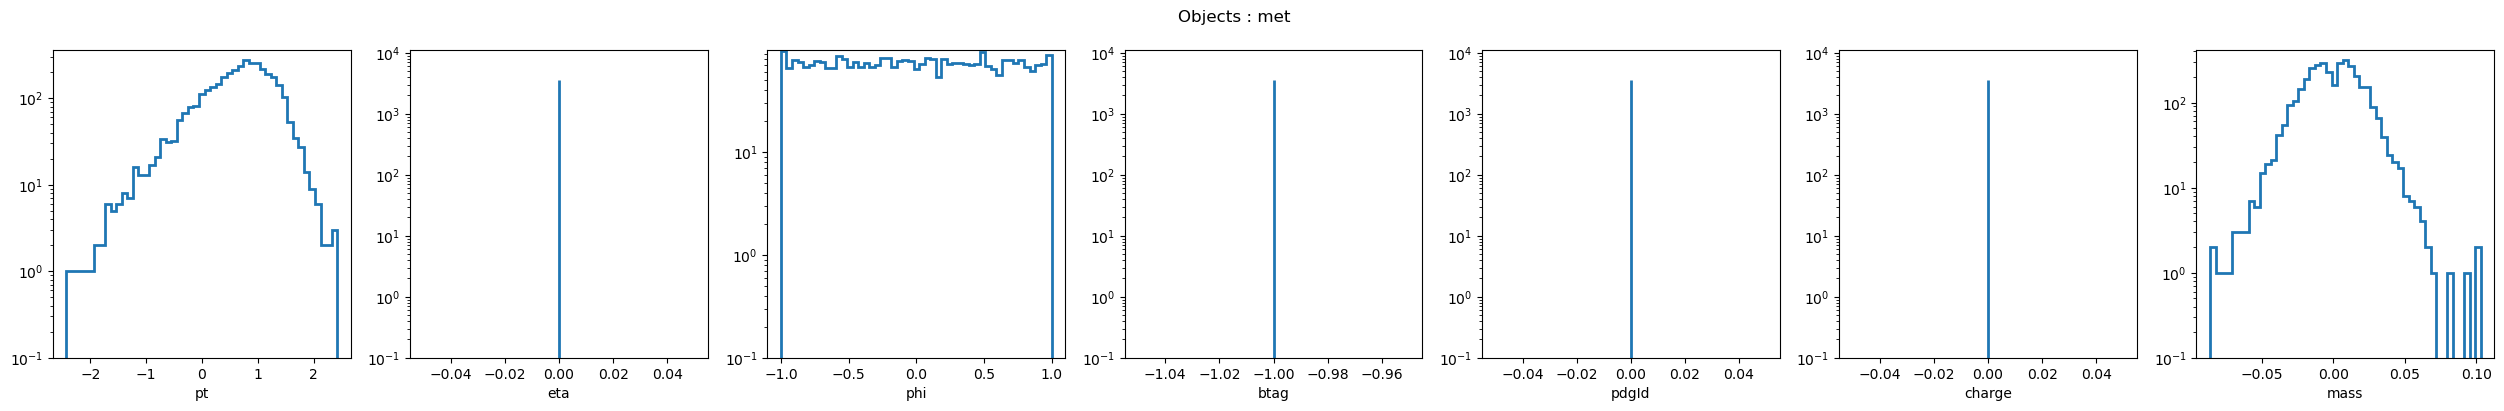

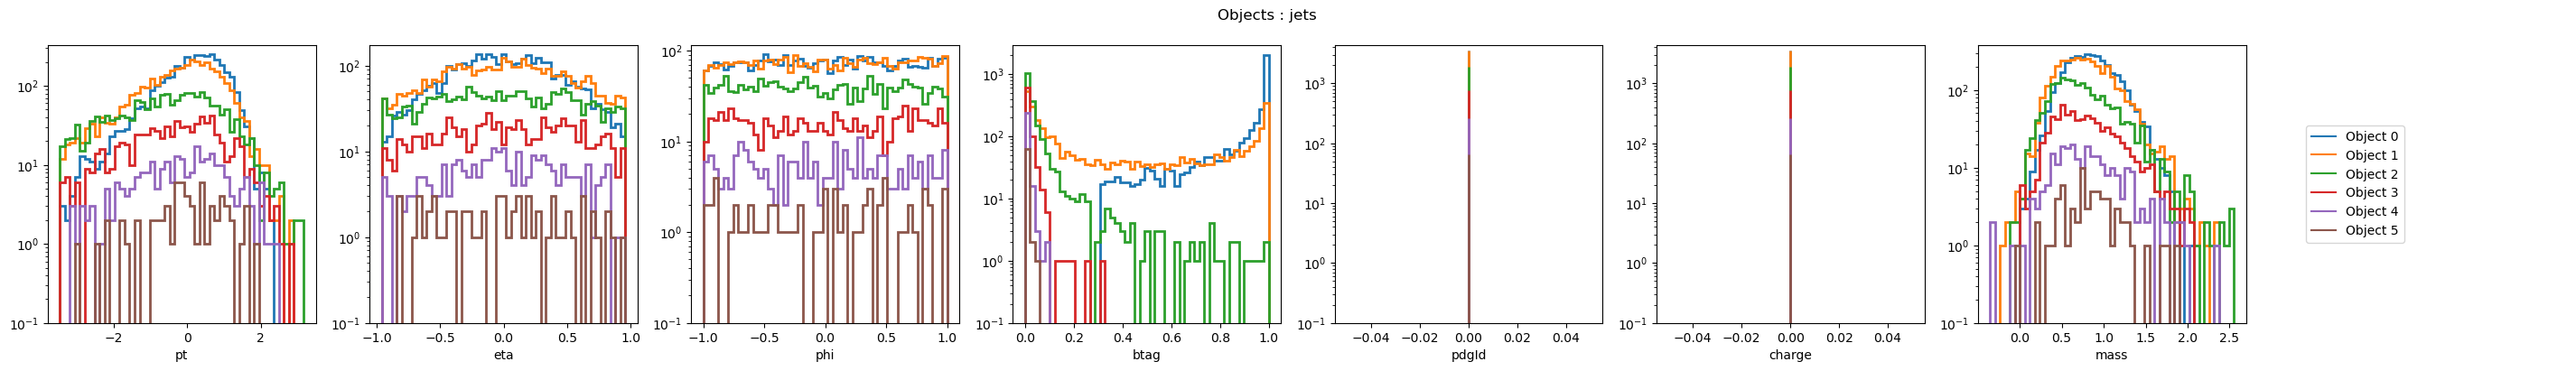

Looking into file metadata
	entry 0 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/TTTo2L2Nu.root']
	entry 1 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/TTTo2L2Nu.root']
Will only consider common files : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/TTTo2L2Nu.root']
(Note : this assumes the files have the same order between the different data objects)
For entry 0 : from 9012 events, 3084 selected
For entry 1 : from 3596 events, 3084 selected
Combined dataset (extracting 3084 events of the following) :
Parton dataset with 9012 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
final_states  : data ([9012, 6, 5]), mask ([9012, 6])
                Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%]
                Mask corr     : [True, True, True,

In [3]:
##### Hard-scattering data #####
hard_data_TT = RootData(
    files = [
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/TTTo2L2Nu.root',
    ],
    treenames = [
        'gen_TT;1',
    ],
    lazy = True,
    N = int(2e4),
)

##### Hard-scattering dataset #####
hard_dataset_TT = TTDoubleLeptonHardDataset(
    data = hard_data_TT,
    selection = [
        'final_states',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
hard_dataset_HH.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset_HH.plot(selection=True,raw=False,log=True)

##### Reconstructed data #####
reco_data_TT = RootData(
    files = hard_data_TT.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = int(2e4),
)
print ('Initial TT:',reco_data_TT.events)

reco_data_TT.cut(
    np.logical_and.reduce(
        (
            reco_data_TT['flag_SR']==1, 
            reco_data_TT['flag_resolved']==1,
            reco_data_TT['n_AK4']<= 6,
        )
    )
)
print ('Resolved SR :',reco_data_TT.events)

##### Reconstructed dataset #####
reco_dataset_TT = HHbbWWDoubleLeptonRecoDataset(
    data = reco_data_TT,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
reco_dataset_TT.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset_TT.plot(selection=True,raw=False,log=True)

##### Combined dataset #####
comb_dataset_TT = CombinedDataset(
    hard_dataset = hard_dataset_TT,
    reco_dataset = reco_dataset_TT,
    intersection_branch = 'event',
)
print (comb_dataset_TT)

# DY datasets

Checking particle quantities
	Particle(s) ('Z',) : required {0, 1}, found {0, 1}
	Particle(s) ('lep_from_Z', 'antilep_from_Z') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_from_nonres', 'antilep_from_nonres') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_from_Z', 'antilep_from_Z', 'lep_from_nonres', 'antilep_from_nonres') : required {2}, found {2}
... done, no problem found
From 50000, removing 16680 tau decay events
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/dy_hard
No final state recorded with `final_states_object_name` property, will not compute PS points
Before preprocessing


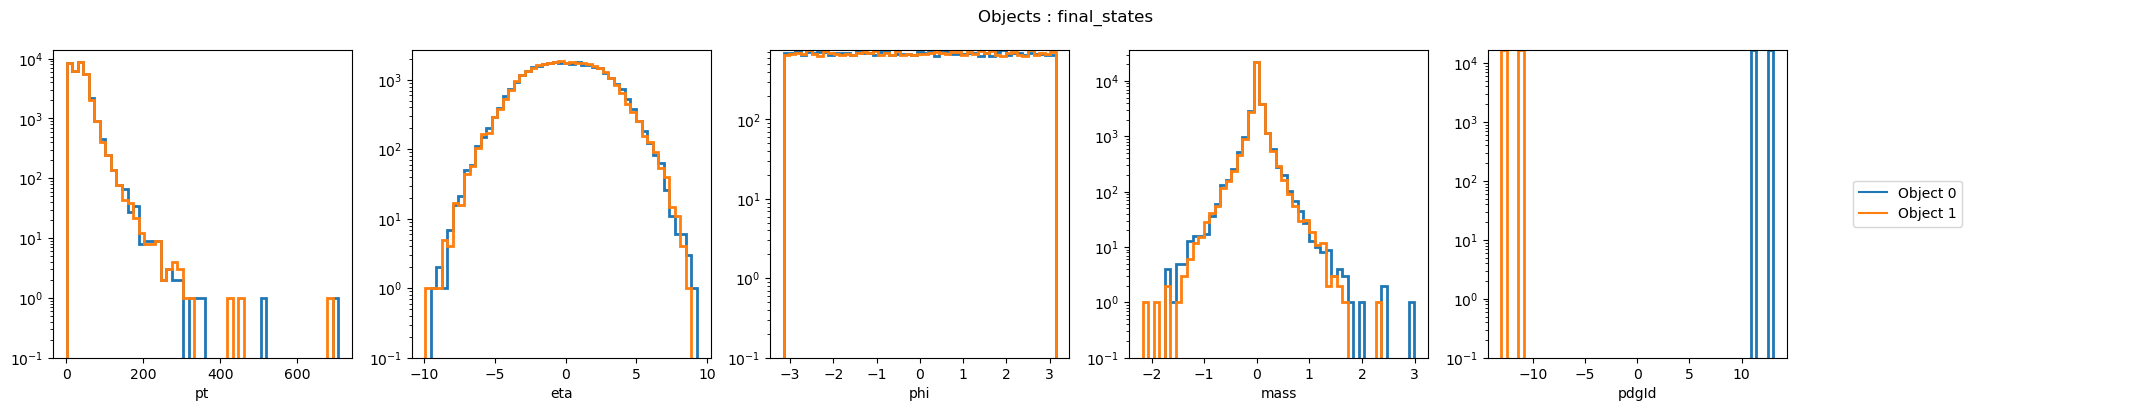

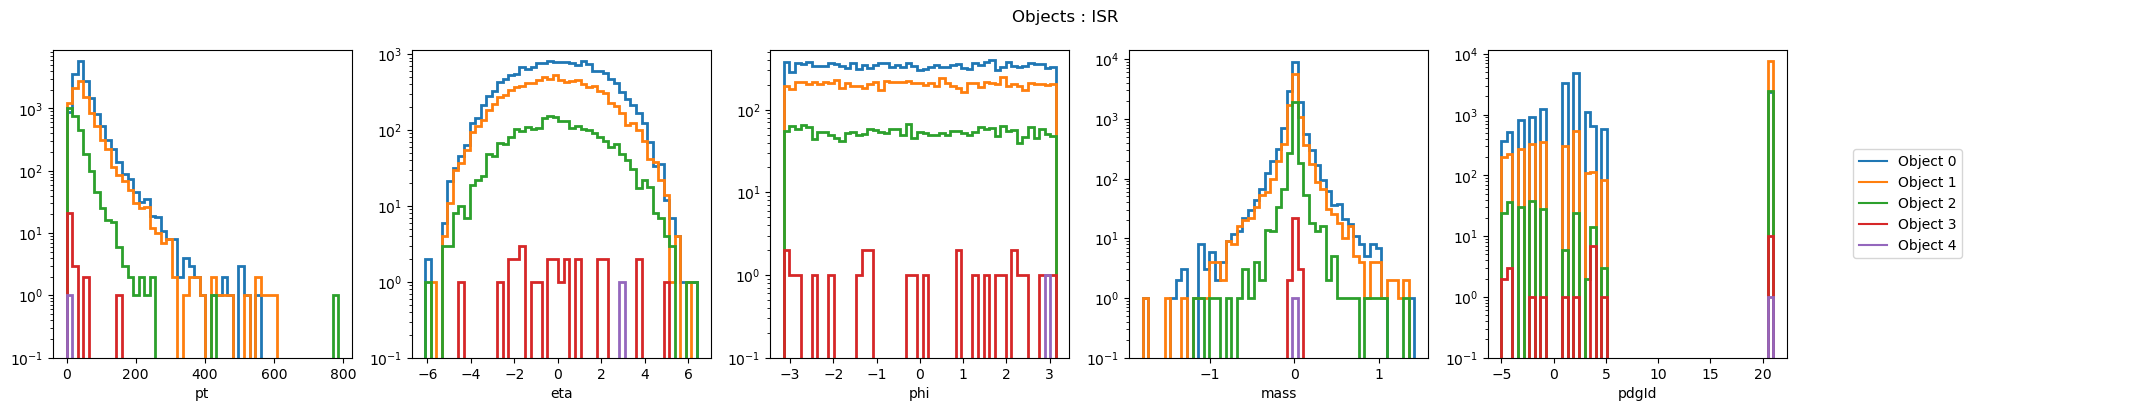

After preprocessing


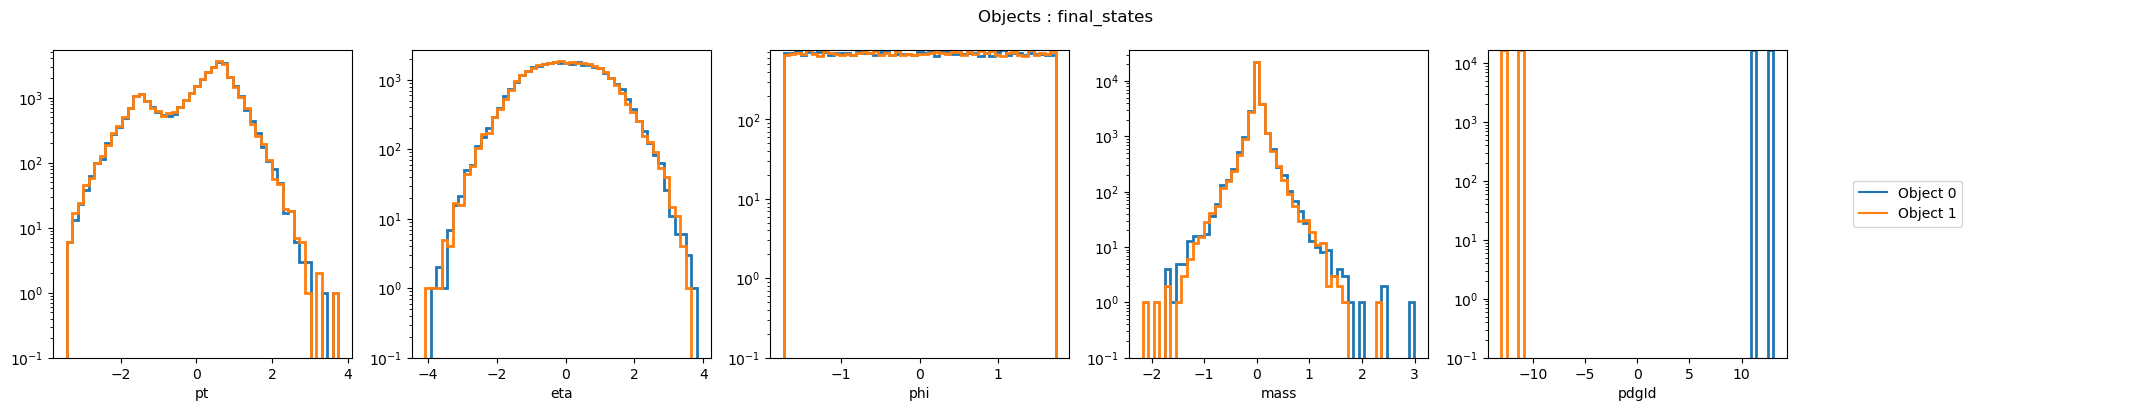

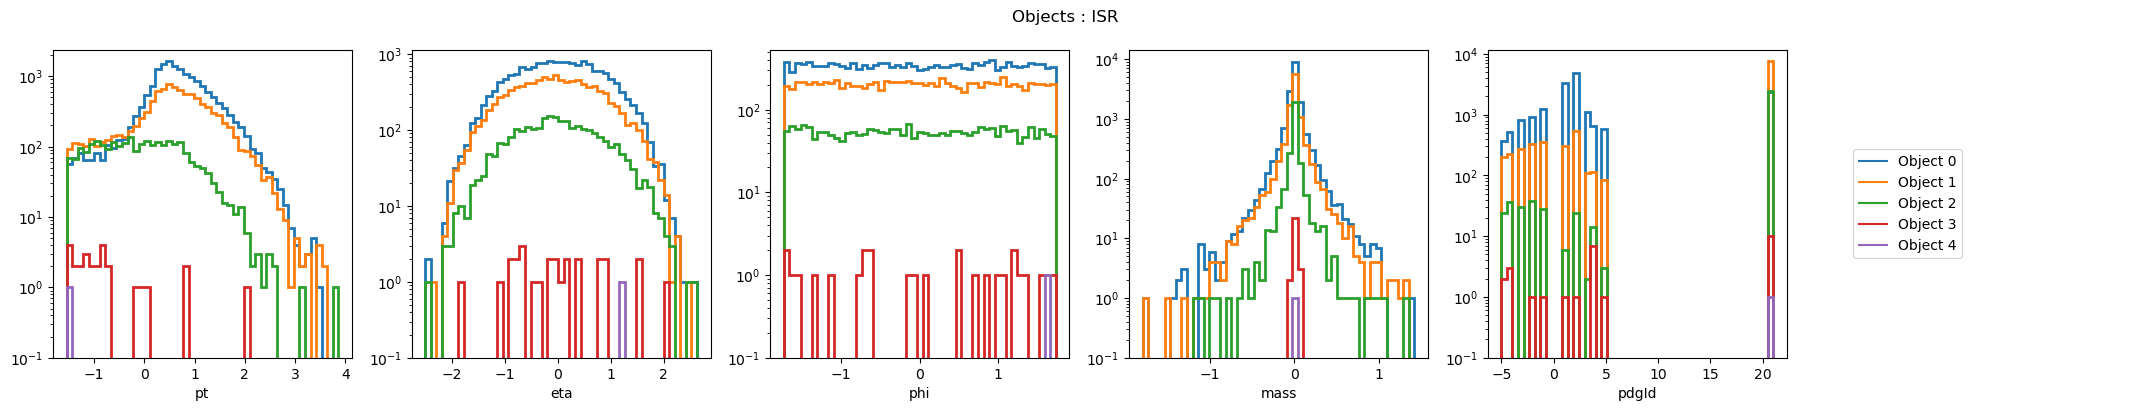

Initial DY: 500000
Resolved SR : 2590
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/dy_reco
Before preprocessing


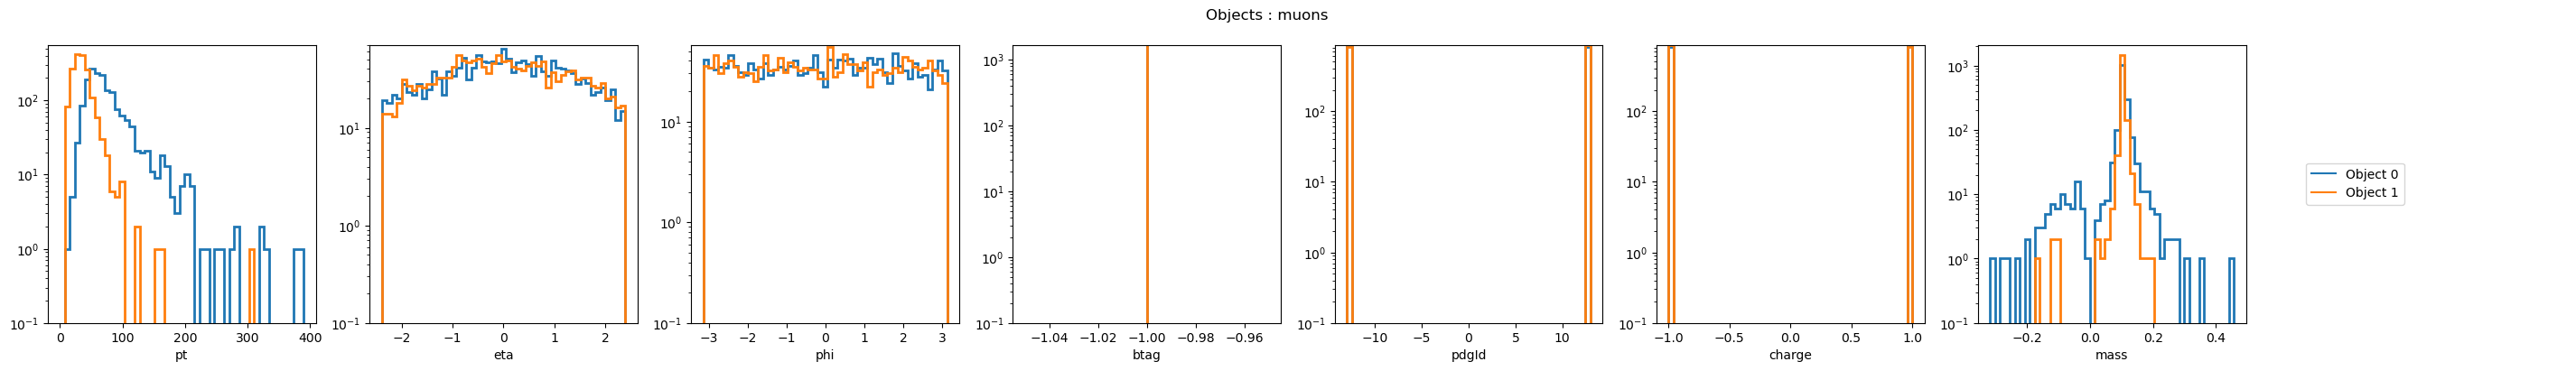

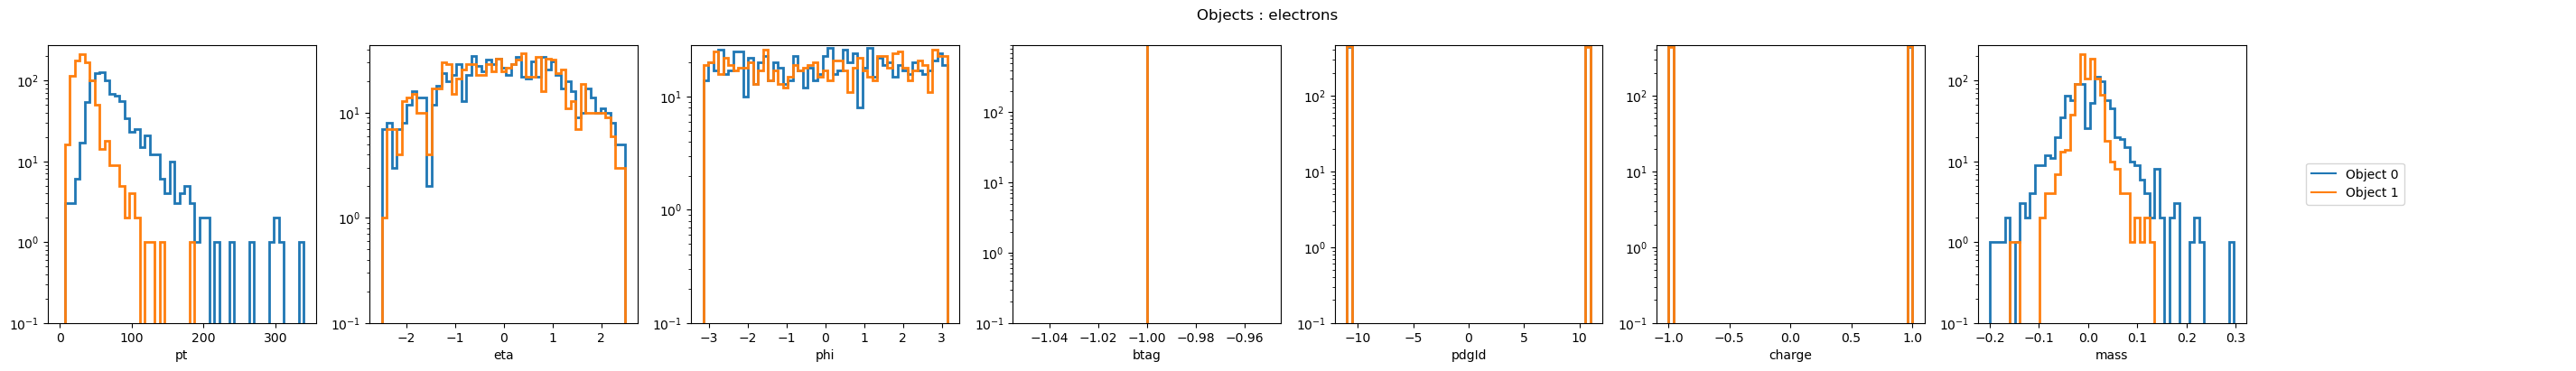

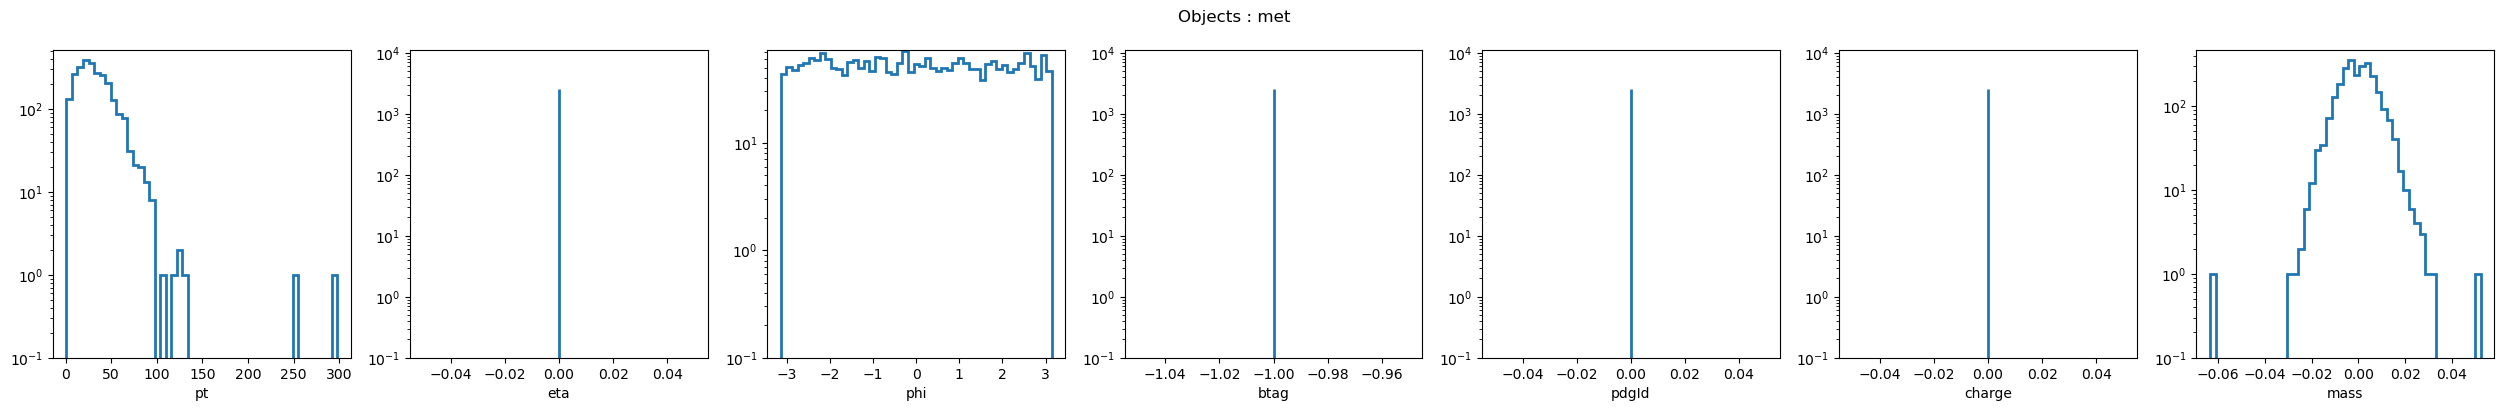

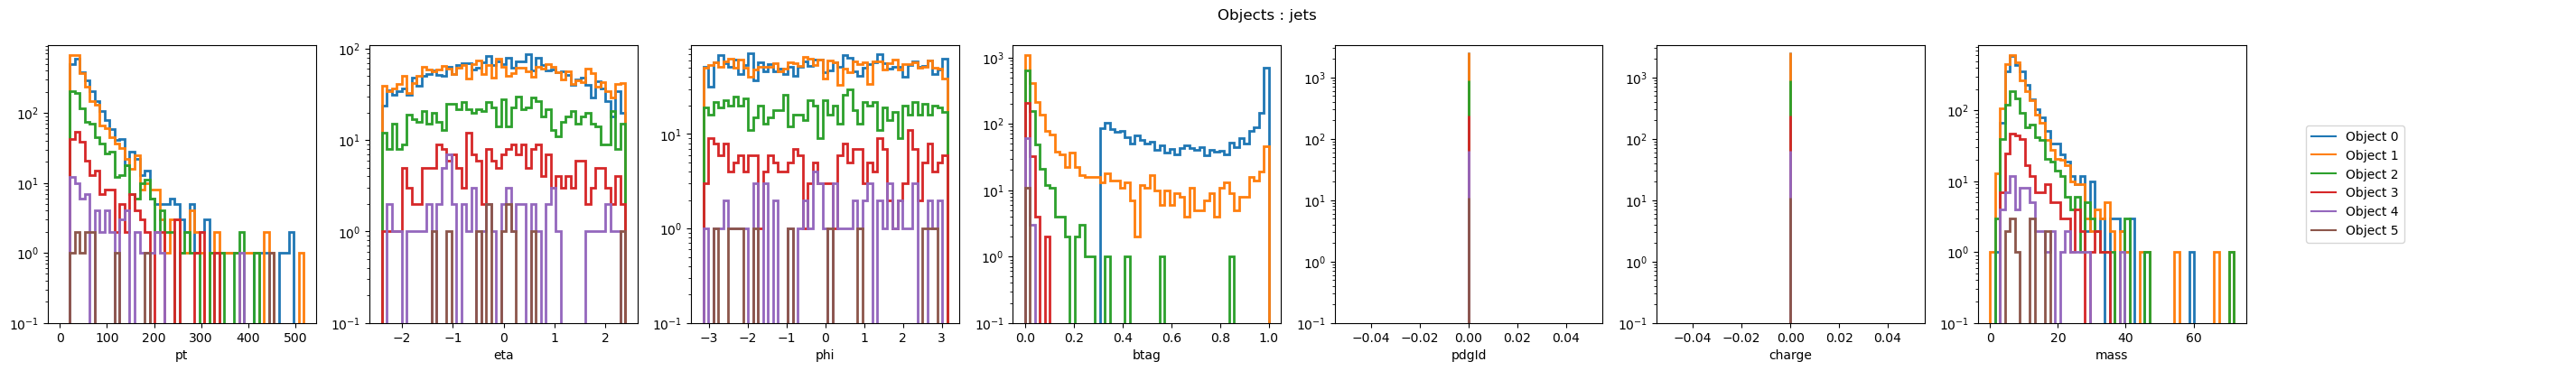

After preprocessing


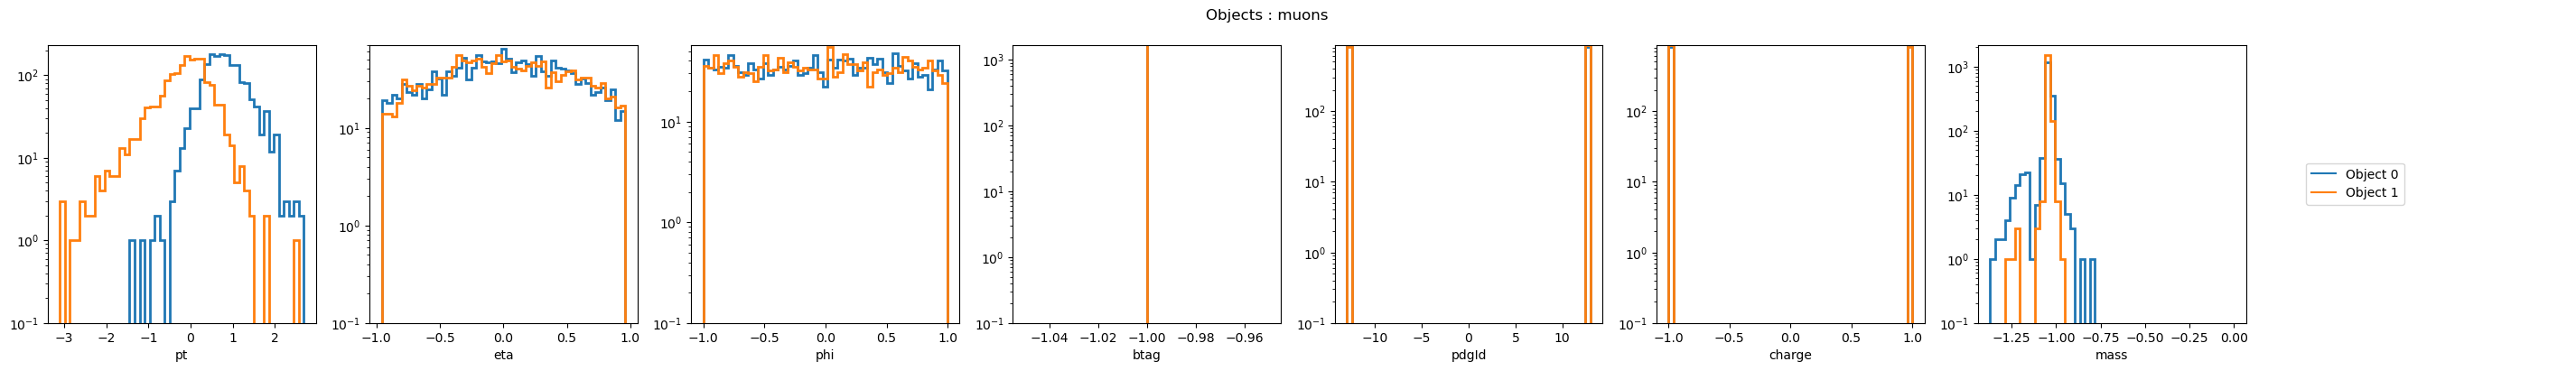

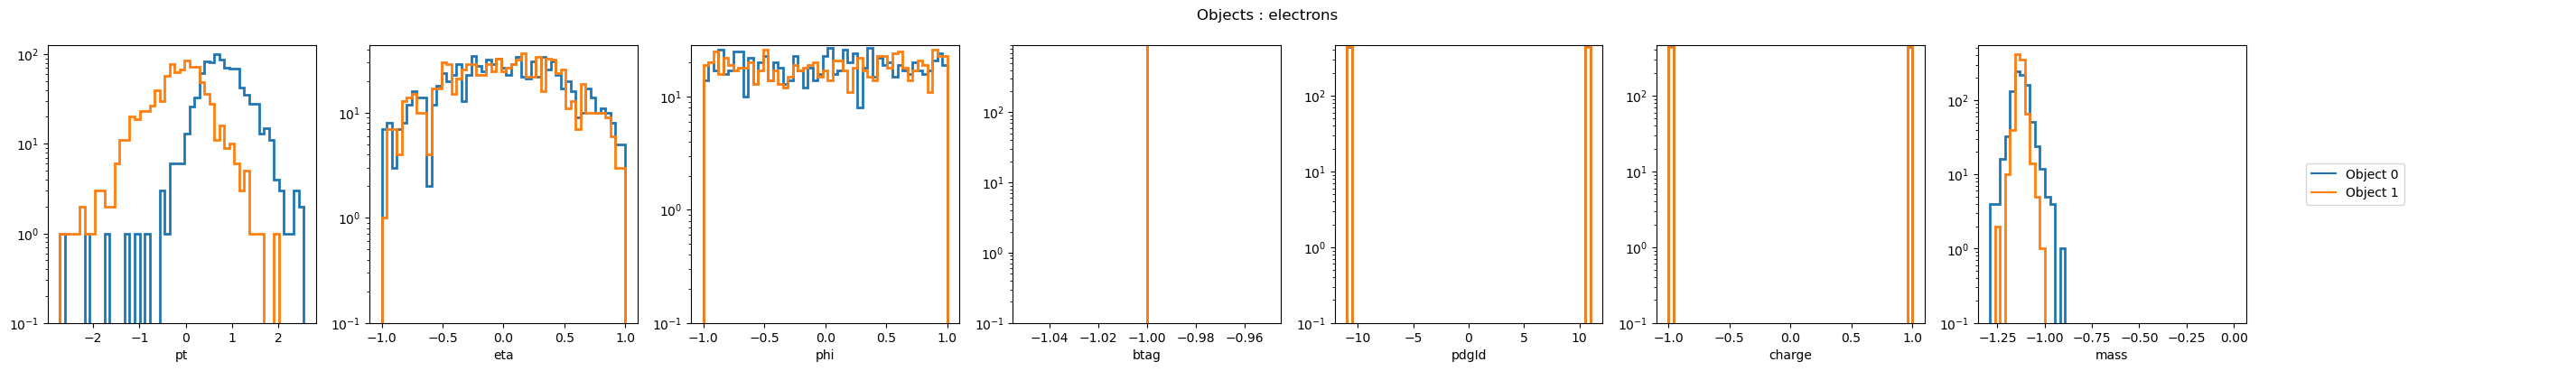

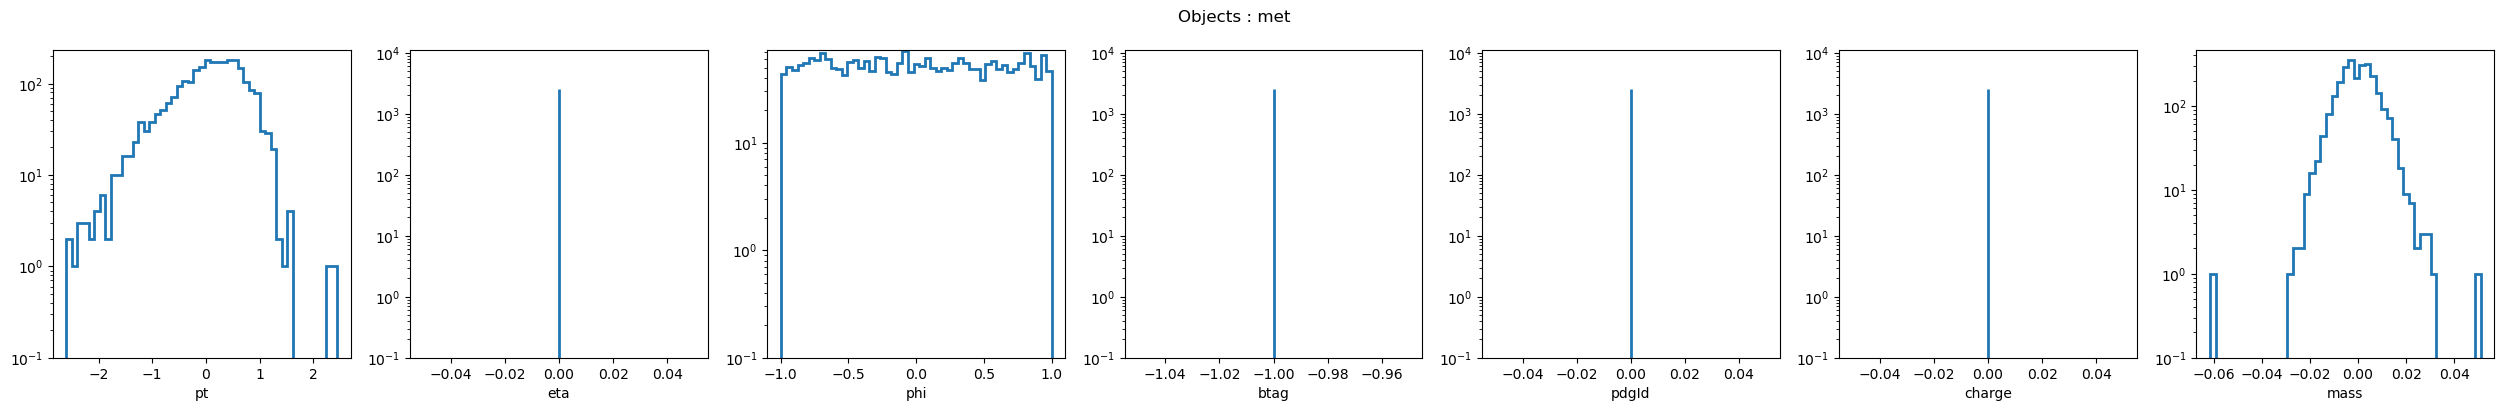

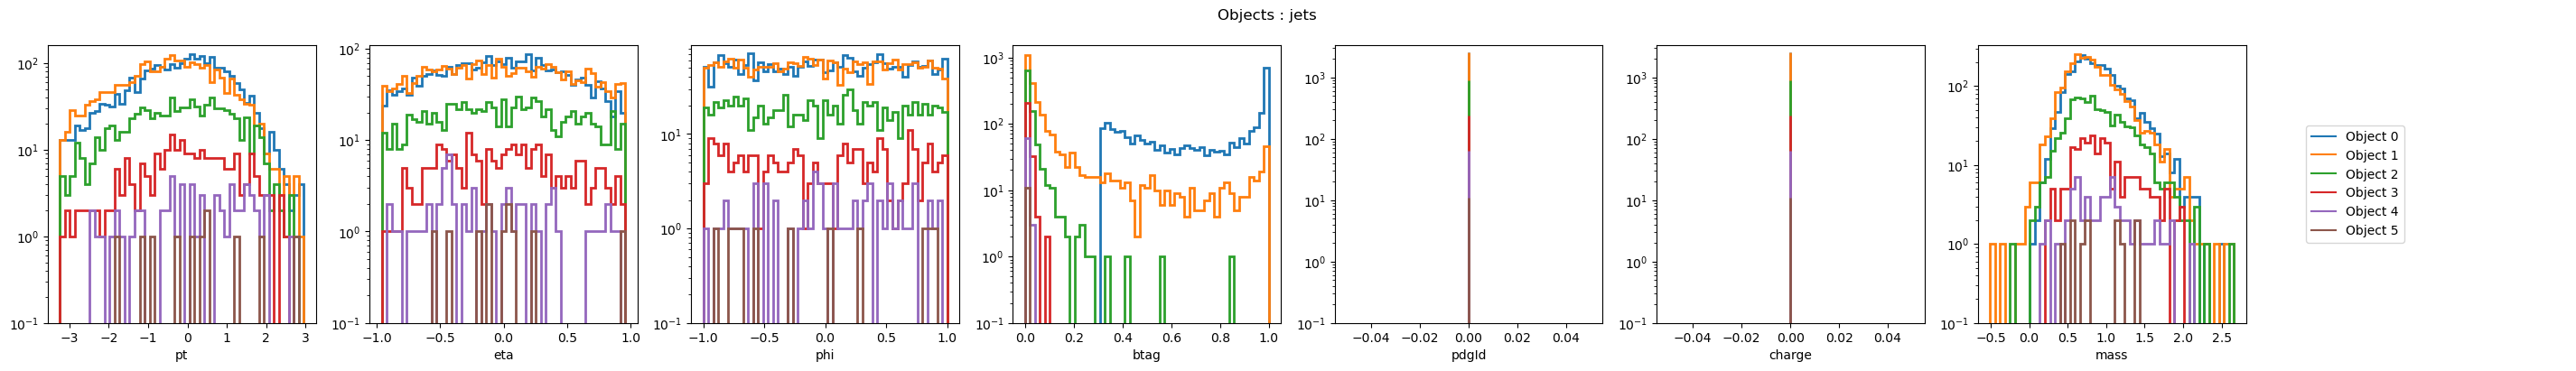

Looking into file metadata
	entry 0 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-10to50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_0J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_1J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_2J.root']
	entry 1 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-10to50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_0J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_1J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_2J.root']
Will only consider common files : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-10to50.root', '/n

In [4]:
##### Hard-scattering data #####
hard_data_DY = RootData(
    files = [
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-10to50.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-50.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_0J.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_1J.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_2J.root',
    ],
    treenames = [
        'gen_DY;1',
    ],
    lazy = True,
    N = int(1e4),
)

##### Hard-scattering dataset #####
hard_dataset_DY = DYDoubleLeptonHardDataset(
    data = hard_data_DY,
    selection = [
        'final_states',
        'ISR',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
hard_dataset_DY.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset_DY.plot(selection=True,raw=False,log=True)

##### Reconstructed data #####
reco_data_DY = RootData(
    files = hard_data_DY.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = int(1e5),
)
print ('Initial DY:',reco_data_DY.events)

reco_data_DY.cut(
    np.logical_and.reduce(
        (
            reco_data_DY['flag_SR']==1, 
            reco_data_DY['flag_resolved']==1,
            reco_data_DY['n_AK4']<= 6,
        )
    )
)
print ('Resolved SR :',reco_data_DY.events)

##### Reconstructed dataset #####
reco_dataset_DY = DYDoubleLeptonRecoDataset(
    data = reco_data_DY,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
reco_dataset_DY.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset_DY.plot(selection=True,raw=False,log=True)

##### Combined dataset #####
comb_dataset_DY = CombinedDataset(
    hard_dataset = hard_dataset_DY,
    reco_dataset = reco_dataset_DY,
    intersection_branch = 'event',
)
print (comb_dataset_DY)

# ZZ datasets

Checking particle quantities
	Particle(s) ('Z1',) : required {1, 2}, found {1, 2}
	Particle(s) ('Z2',) : required {1, 2}, found {1, 2}
	Particle(s) ('lep_from_Z1', 'antilep_from_Z1') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_from_Z2', 'antilep_from_Z2') : required {0}, found {0}
	Particle(s) ('lep_from_nonres', 'antilep_from_nonres') : required {0, 2}, found {0, 2}
	Particle(s) ('quark_from_Z1', 'antiquark_from_Z1') : required {0, 2}, found {0, 2}
	Particle(s) ('quark_from_Z2', 'antiquark_from_Z2') : required {0, 2}, found {0, 2}
... done, no problem found
From 10000, removing 3225 tau decay events
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/zz_hard
No final state recorded with `final_states_object_name` property, will not compute PS points
Before preprocessing


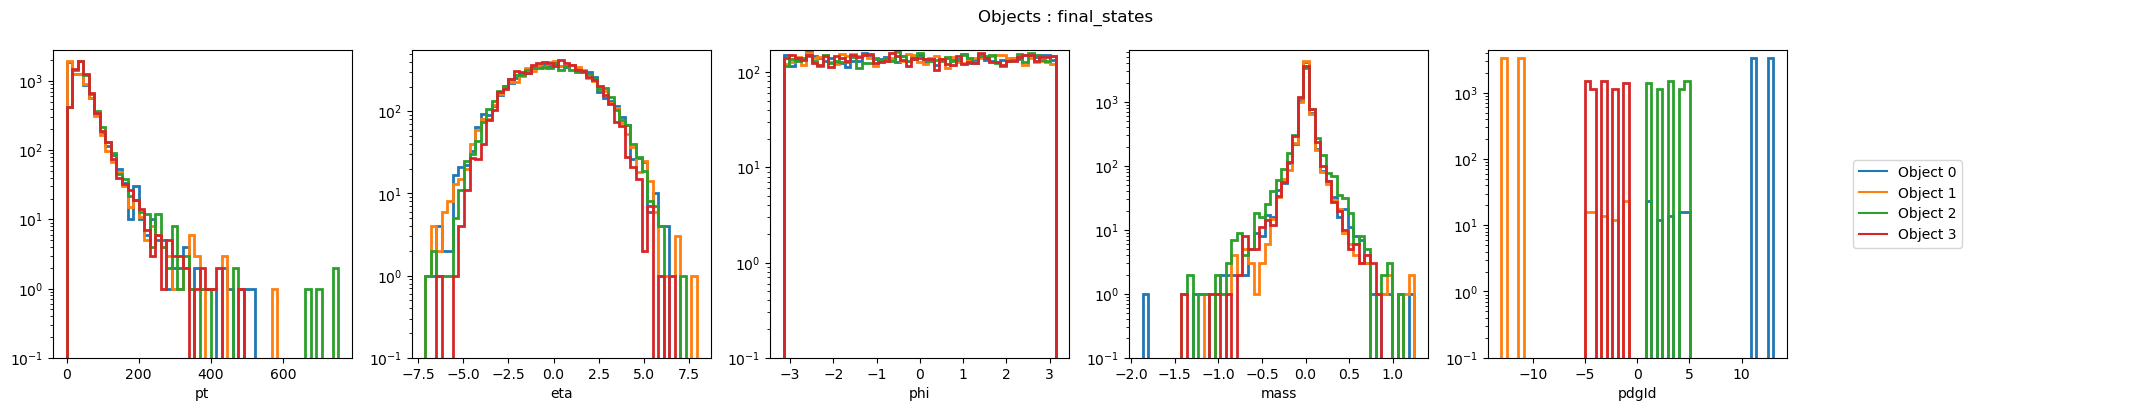

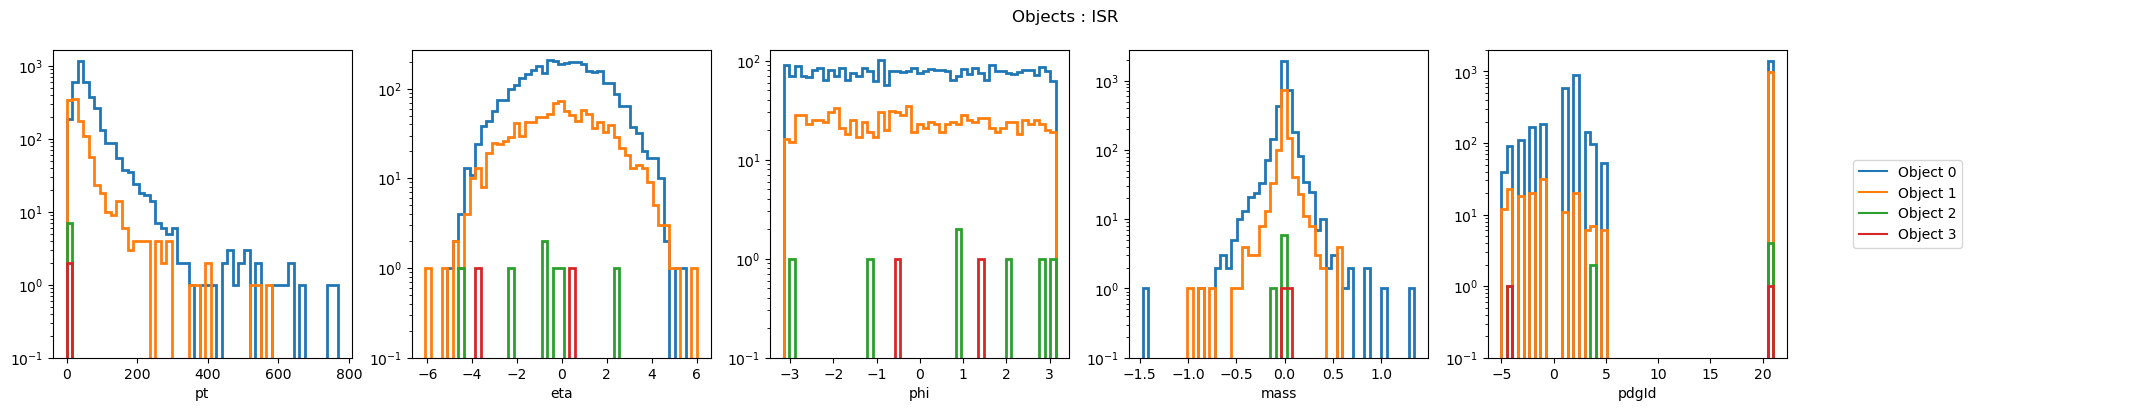

After preprocessing


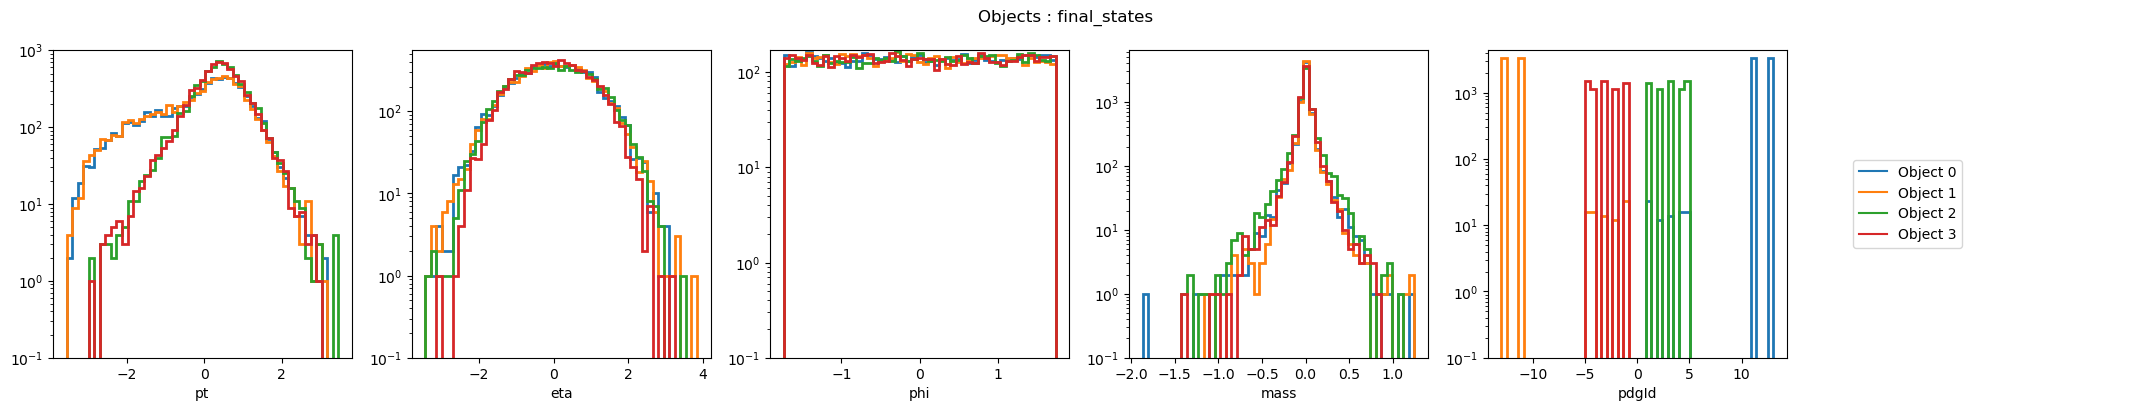

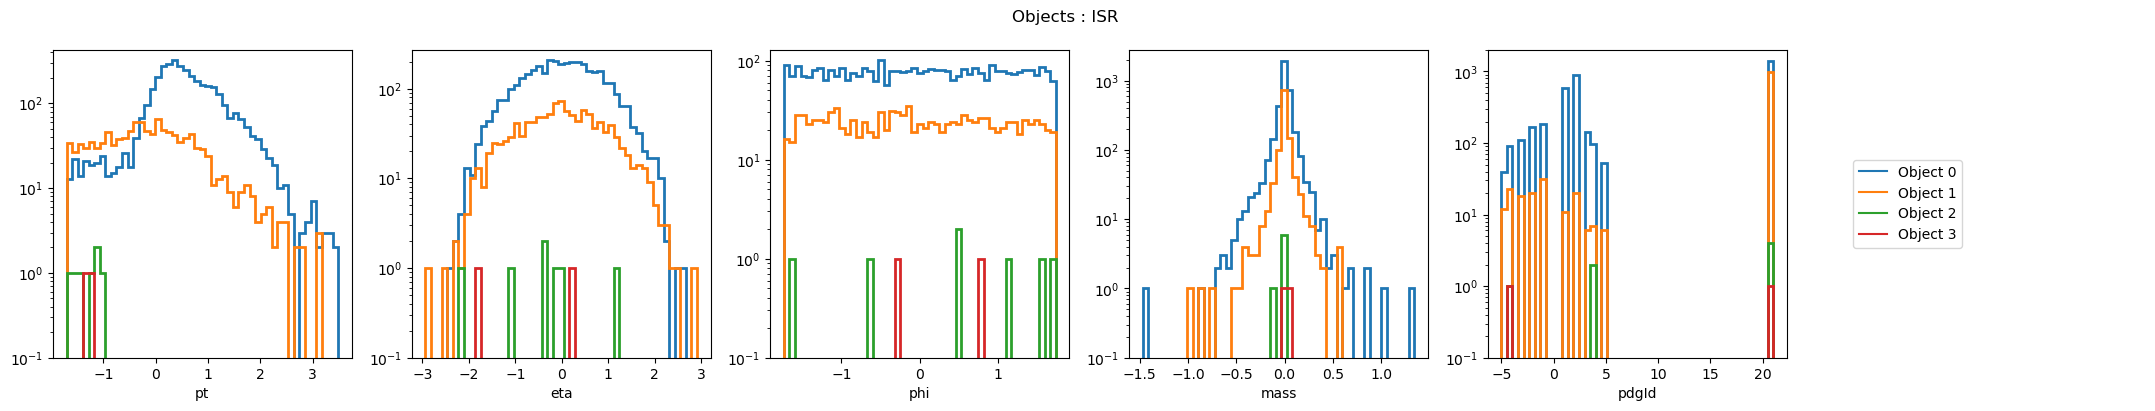

Initial ZZ: 2590
Resolved SR : 271
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/zz_reco
Before preprocessing


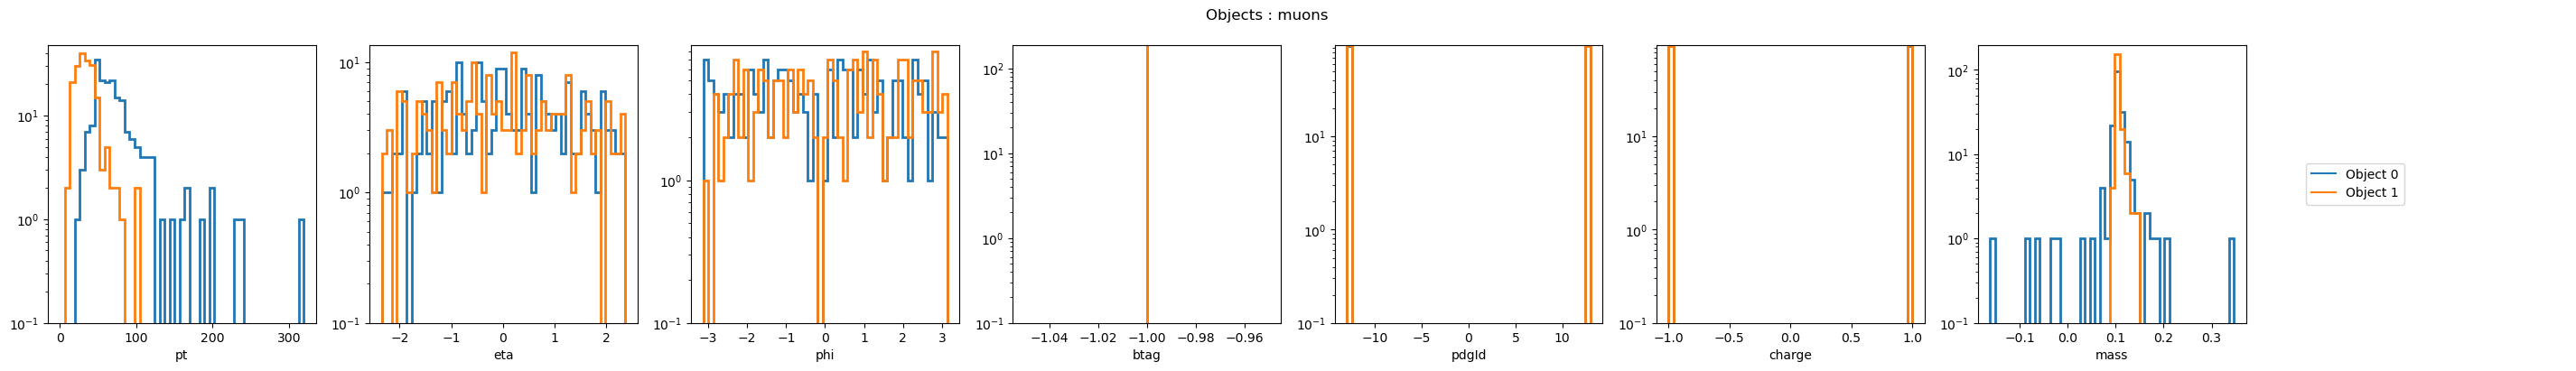

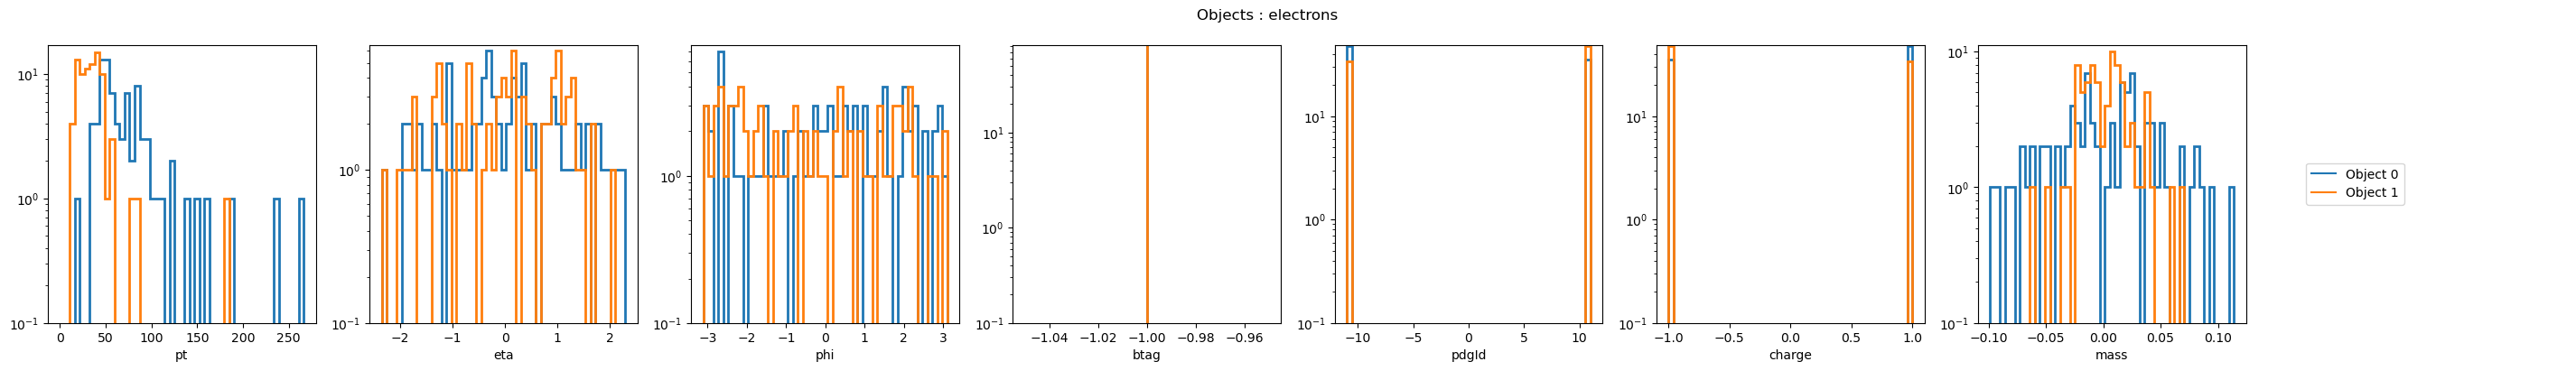

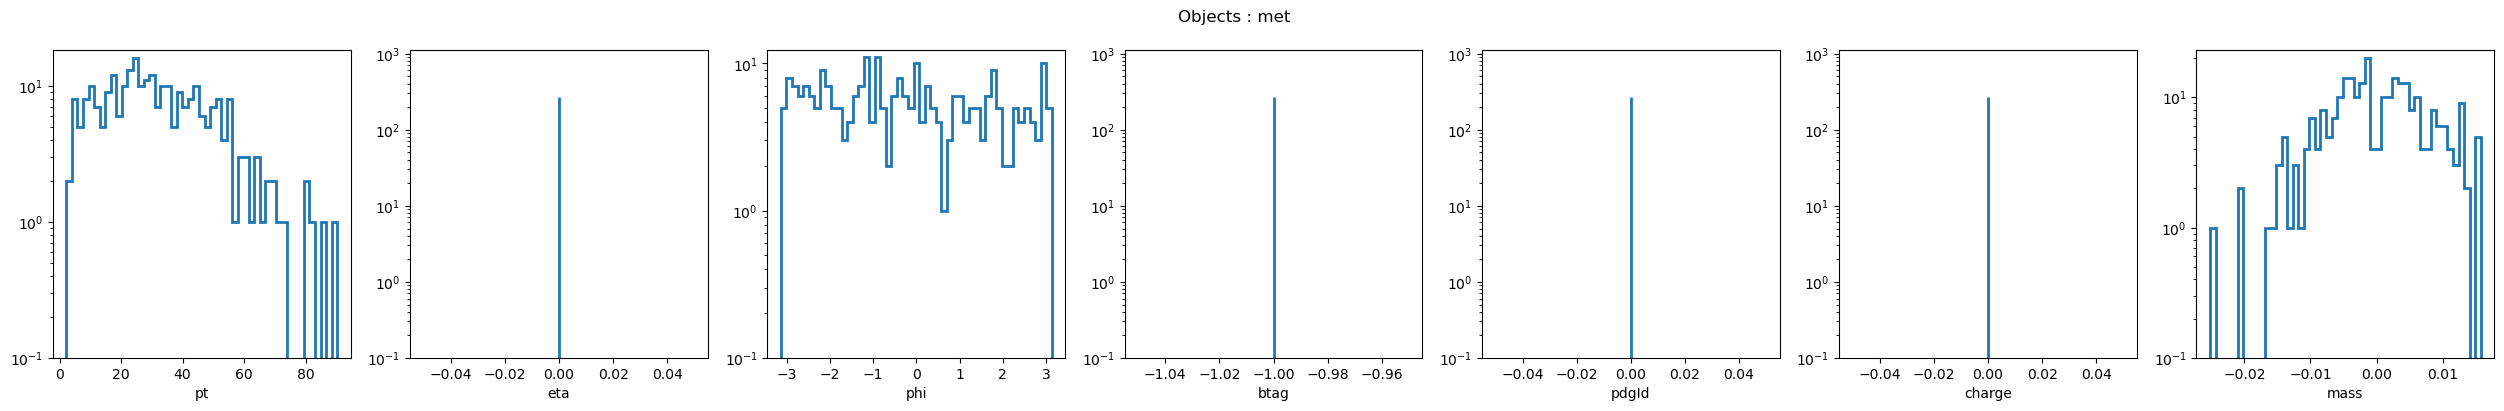

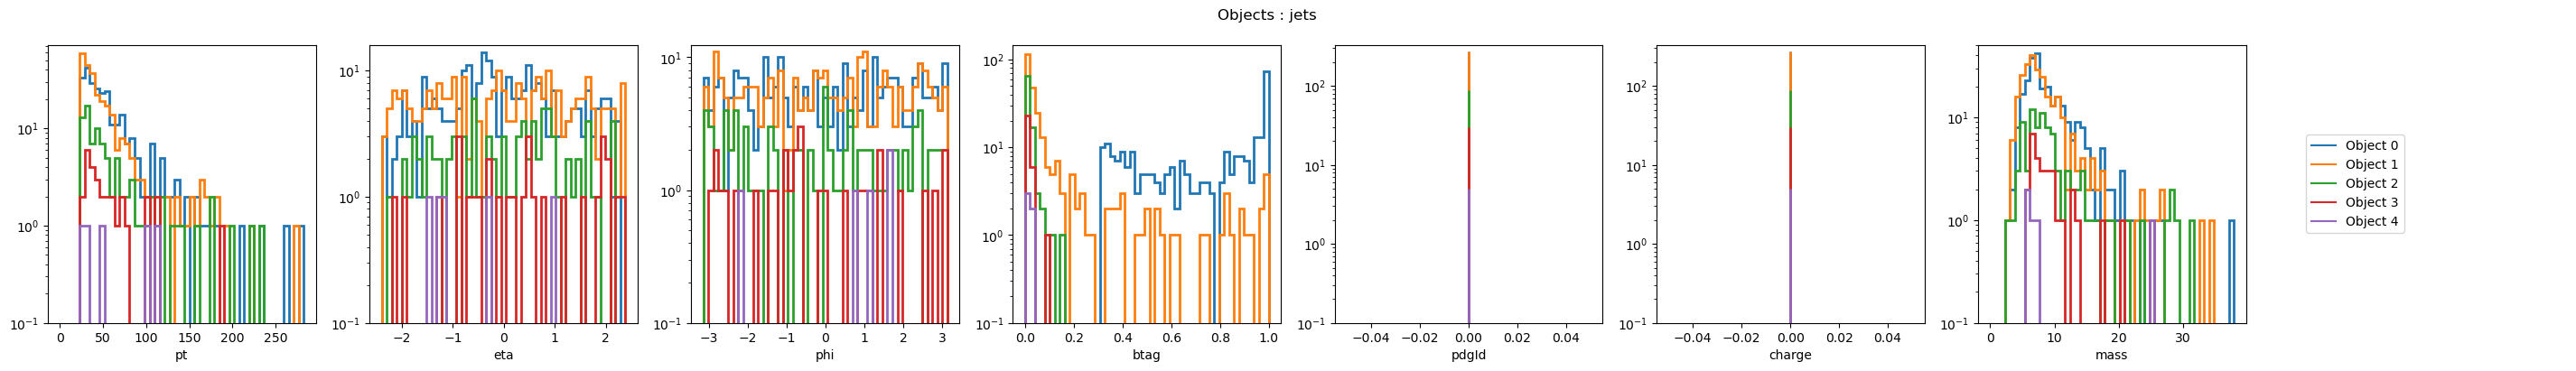

After preprocessing


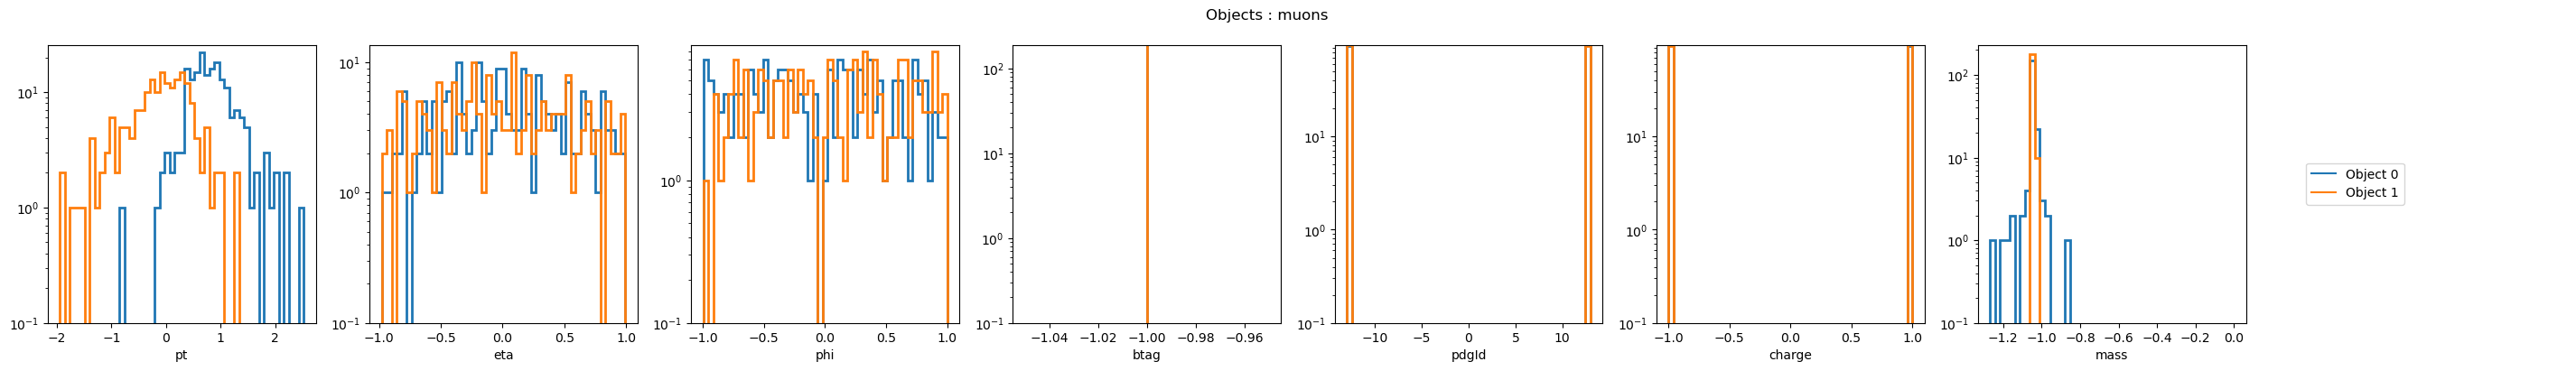

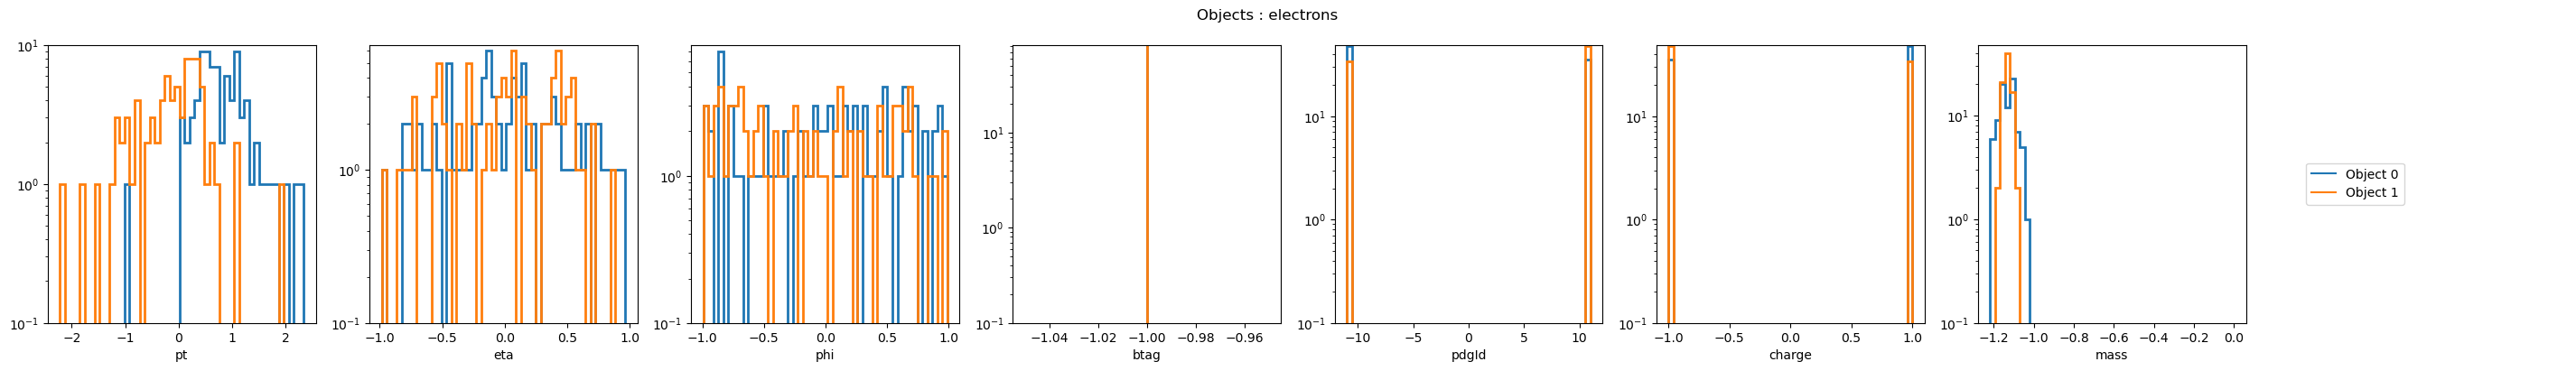

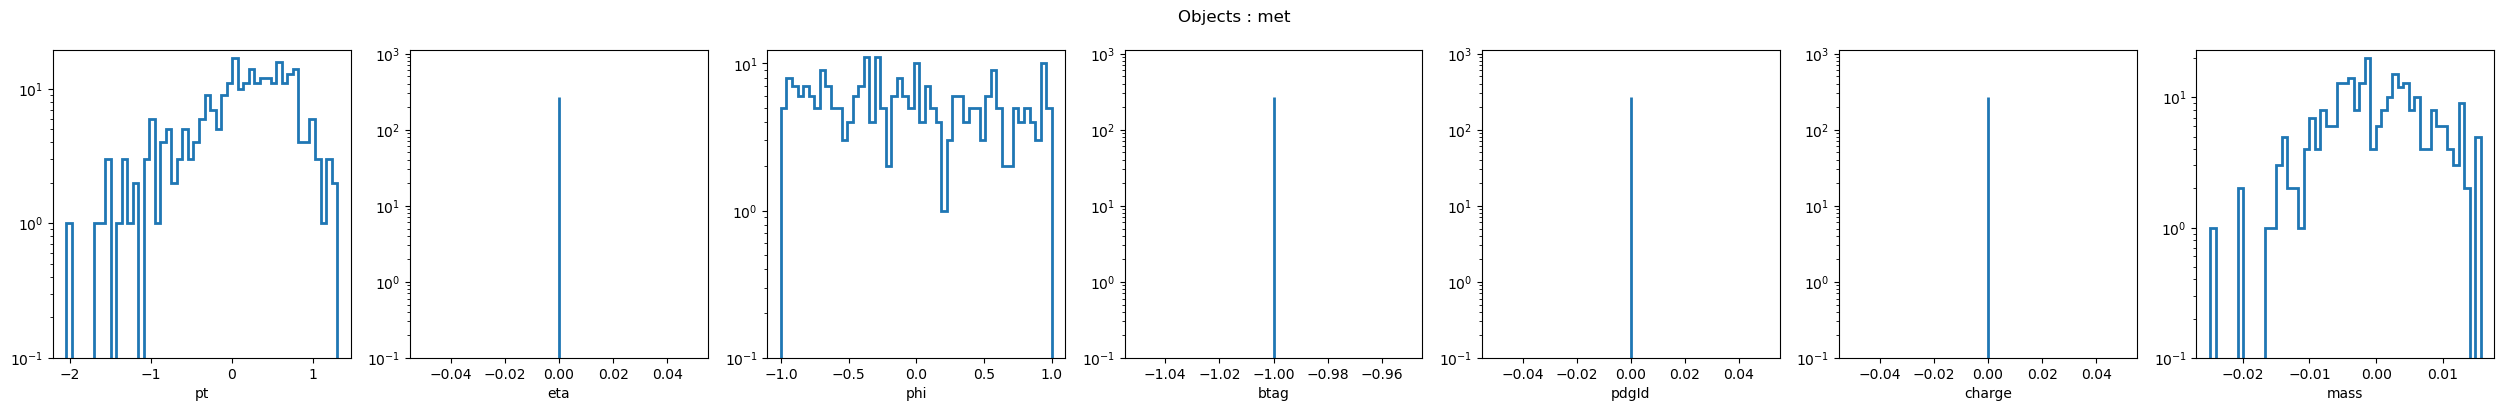

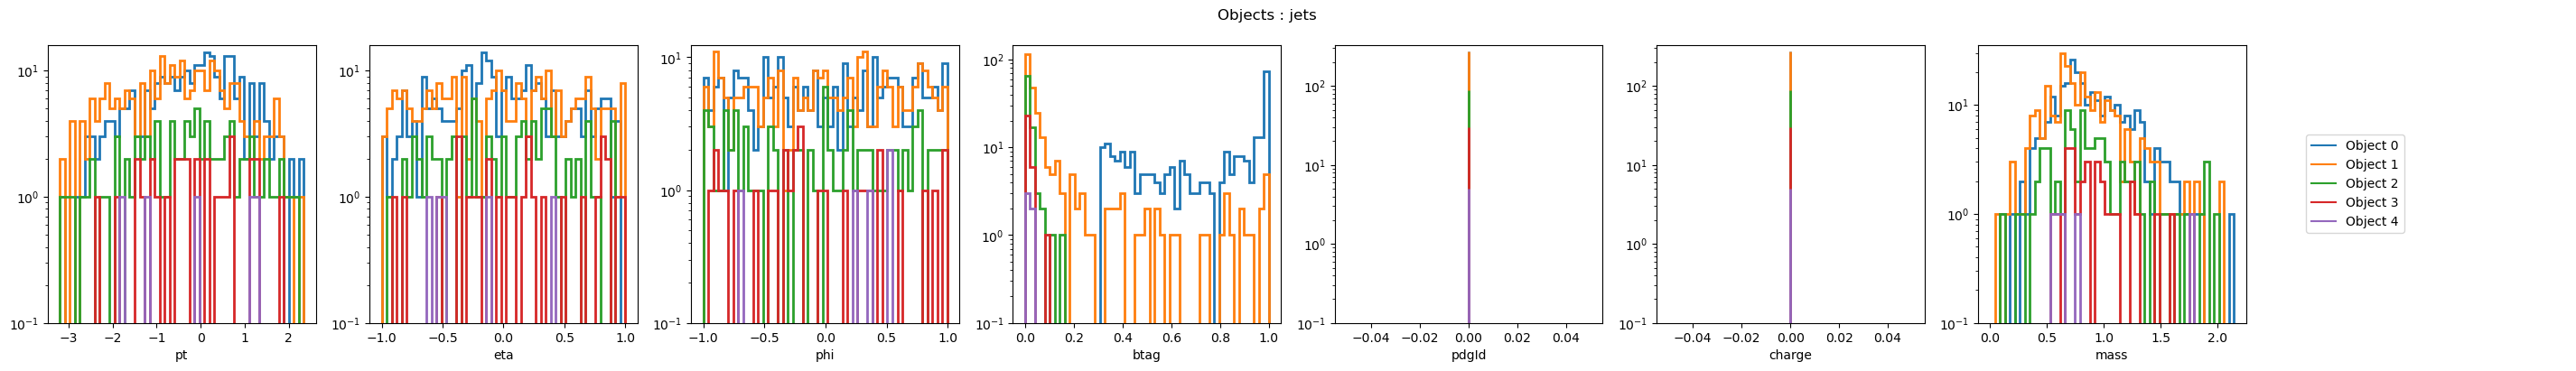

Looking into file metadata
	entry 0 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ZZTo2L2Q.root']
	entry 1 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-10to50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_0J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_1J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_2J.root']
Will only consider common files : []
(Note : this assumes the files have the same order between the different data objects)
For entry 0 : from 6775 events, 0 selected
For entry 1 : from 271 events, 0 selected
Combined dataset (extracting 0 events of the following) :
Parton dataset with 6775 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -11]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0005109989499999

In [6]:
##### Hard-scattering data #####
hard_data_ZZ = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ZZTo2L2Q.root',
    ],
    treenames = [
        'gen_ZZ;1',
    ],
    lazy = True,
    N = int(1e4),
)

##### Hard-scattering dataset #####
hard_dataset_ZZ = ZZDoubleLeptonHardDataset(
    data = hard_data_ZZ,
    selection = [
        'final_states',
        'ISR',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
hard_dataset_ZZ.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset_ZZ.plot(selection=True,raw=False,log=True)

##### Reconstructed data #####
reco_data_ZZ = RootData(
    files = hard_data_DY.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = int(1e4),
)
print ('Initial ZZ:',reco_data_DY.events)

reco_data_ZZ.cut(
    np.logical_and.reduce(
        (
            reco_data_ZZ['flag_SR']==1, 
            reco_data_ZZ['flag_resolved']==1,
            reco_data_ZZ['n_AK4']<= 6,
        )
    )
)
print ('Resolved SR :',reco_data_ZZ.events)

##### Reconstructed dataset #####
reco_dataset_ZZ = ZZDoubleLeptonRecoDataset(
    data = reco_data_ZZ,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
reco_dataset_ZZ.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset_ZZ.plot(selection=True,raw=False,log=True)

##### Combined dataset #####
comb_dataset_ZZ = CombinedDataset(
    hard_dataset = hard_dataset_ZZ,
    reco_dataset = reco_dataset_ZZ,
    intersection_branch = 'event',
)
print (comb_dataset_ZZ)

# ZH datasets

Checking particle quantities
	Particle(s) ('H',) : required {1}, found {1}
	Particle(s) ('Z',) : required {1}, found {1}
	Particle(s) ('bottom',) : required {1}, found {1}
	Particle(s) ('antibottom',) : required {1}, found {1}
	Particle(s) ('lep_plus',) : required {1}, found {1}
	Particle(s) ('lep_minus',) : required {1}, found {1}
... done, no problem found
From 10000, removing 3244 tau decay events
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/zz_hard
No final state recorded with `final_states_object_name` property, will not compute PS points
Before preprocessing


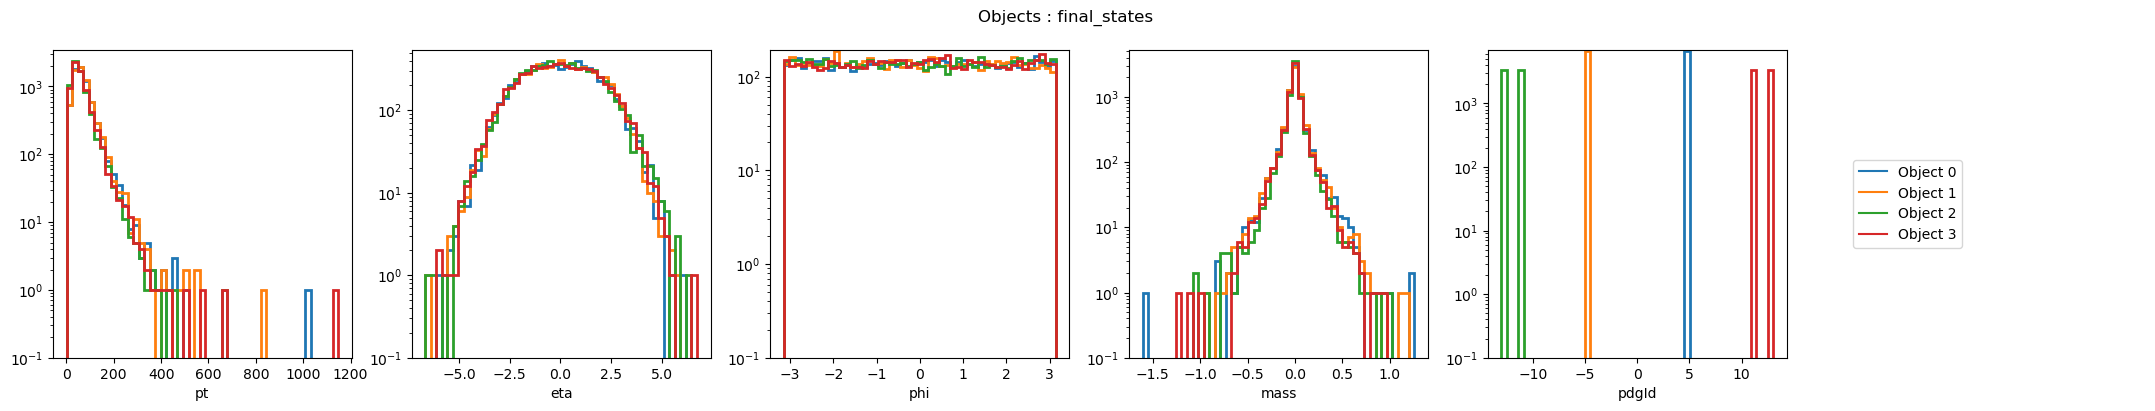

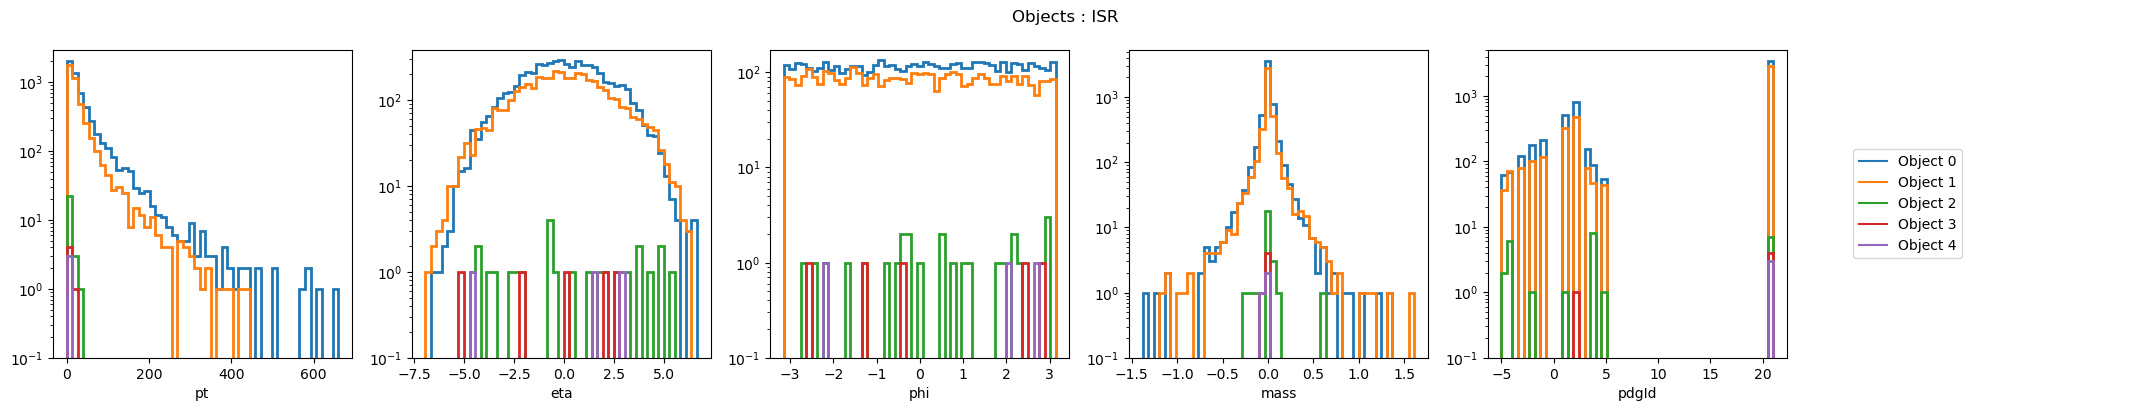

After preprocessing


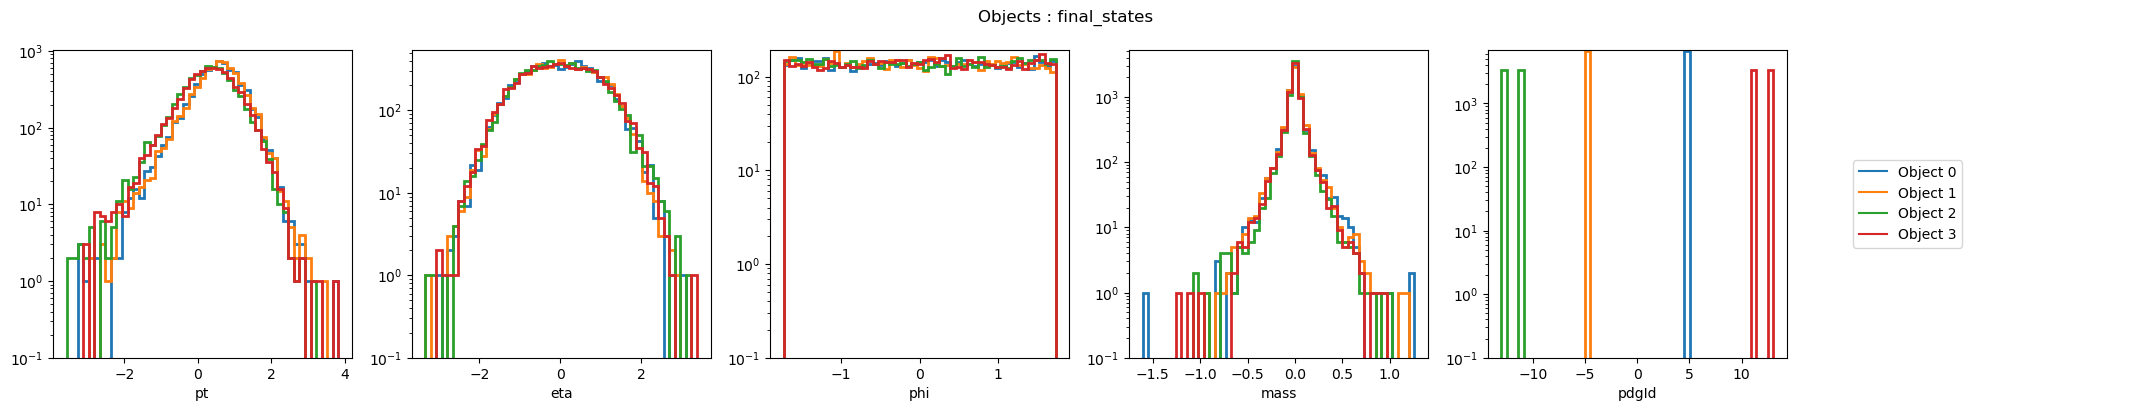

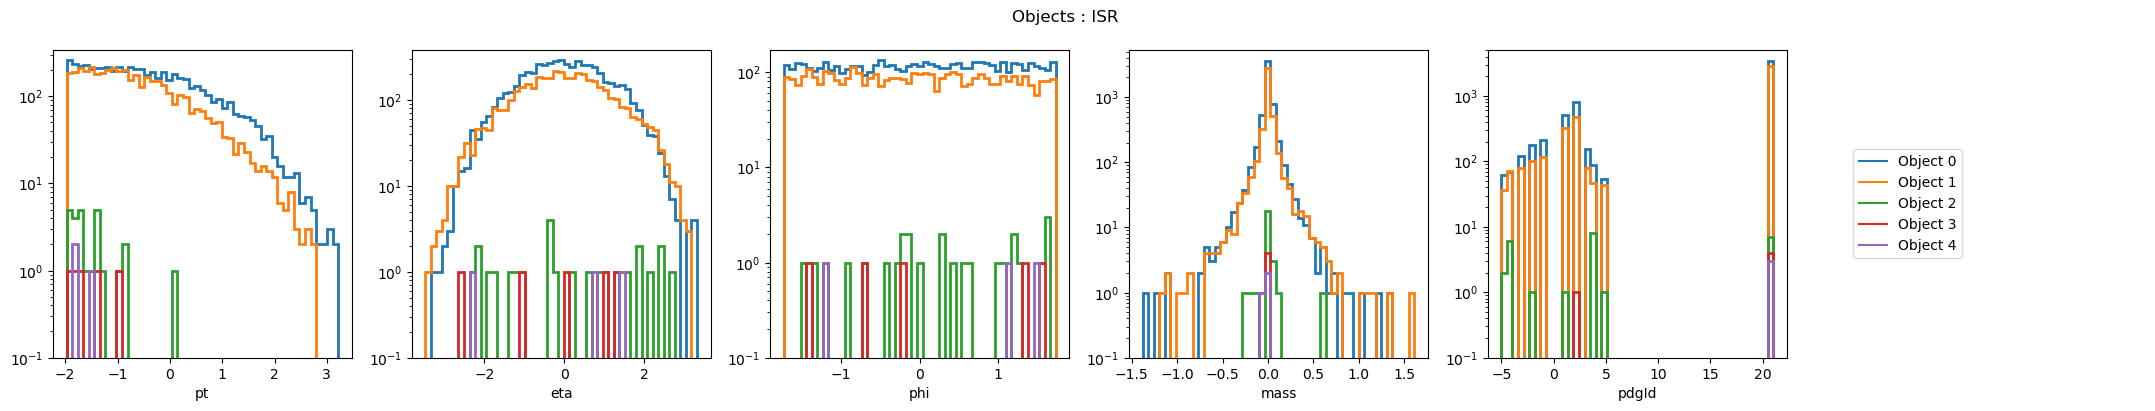

Initial ZH: 2590
Resolved SR : 271
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/zz_reco
Before preprocessing


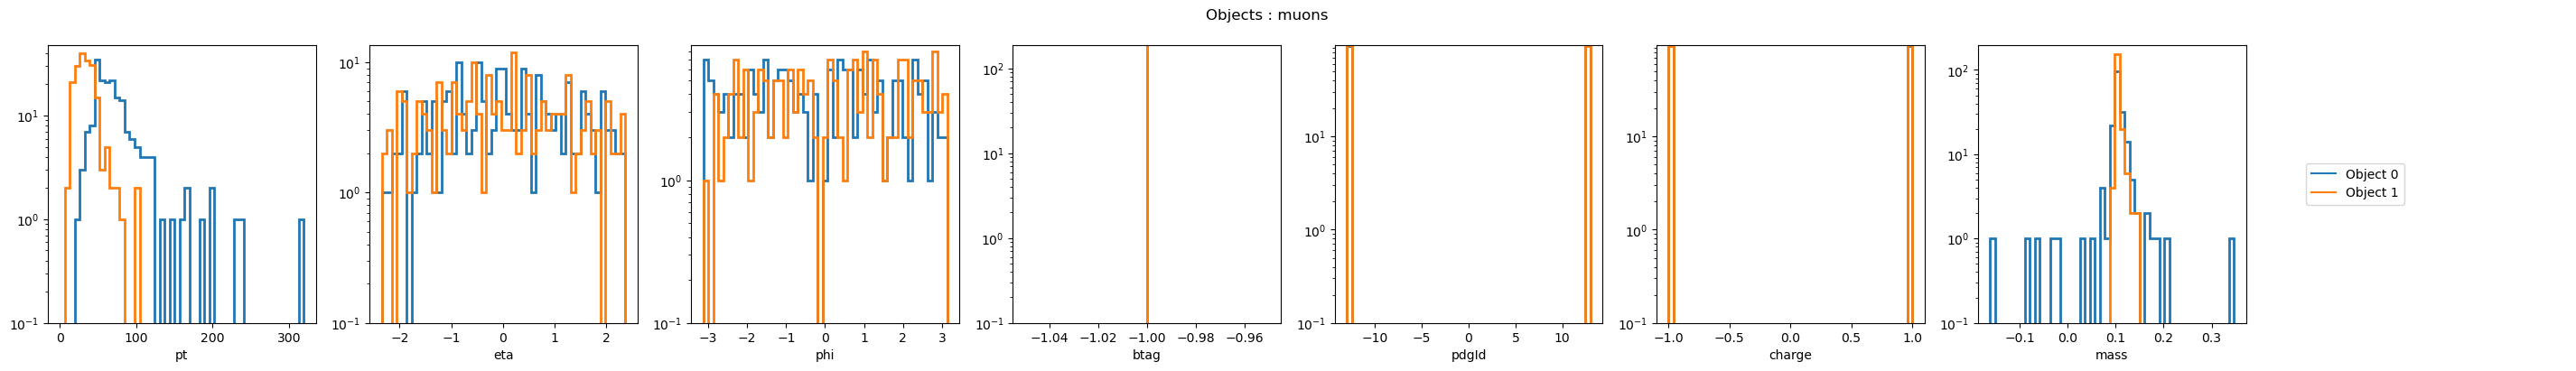

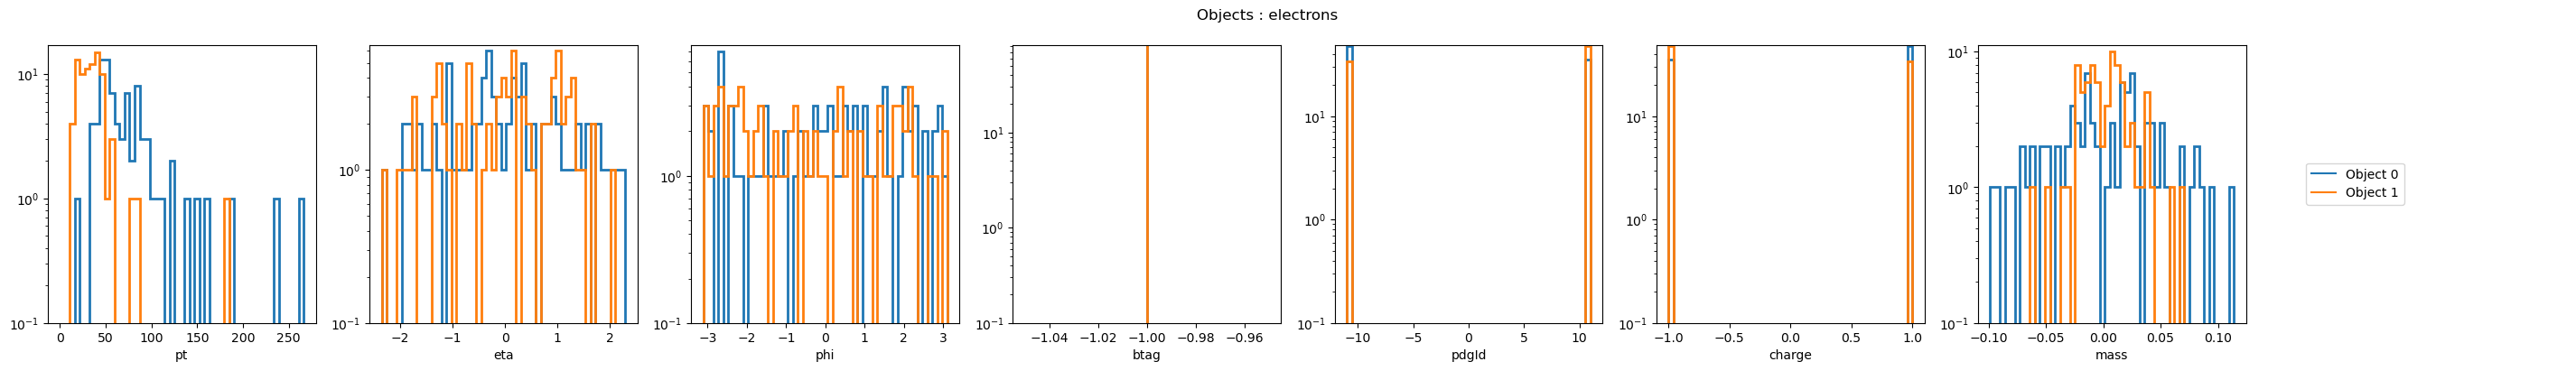

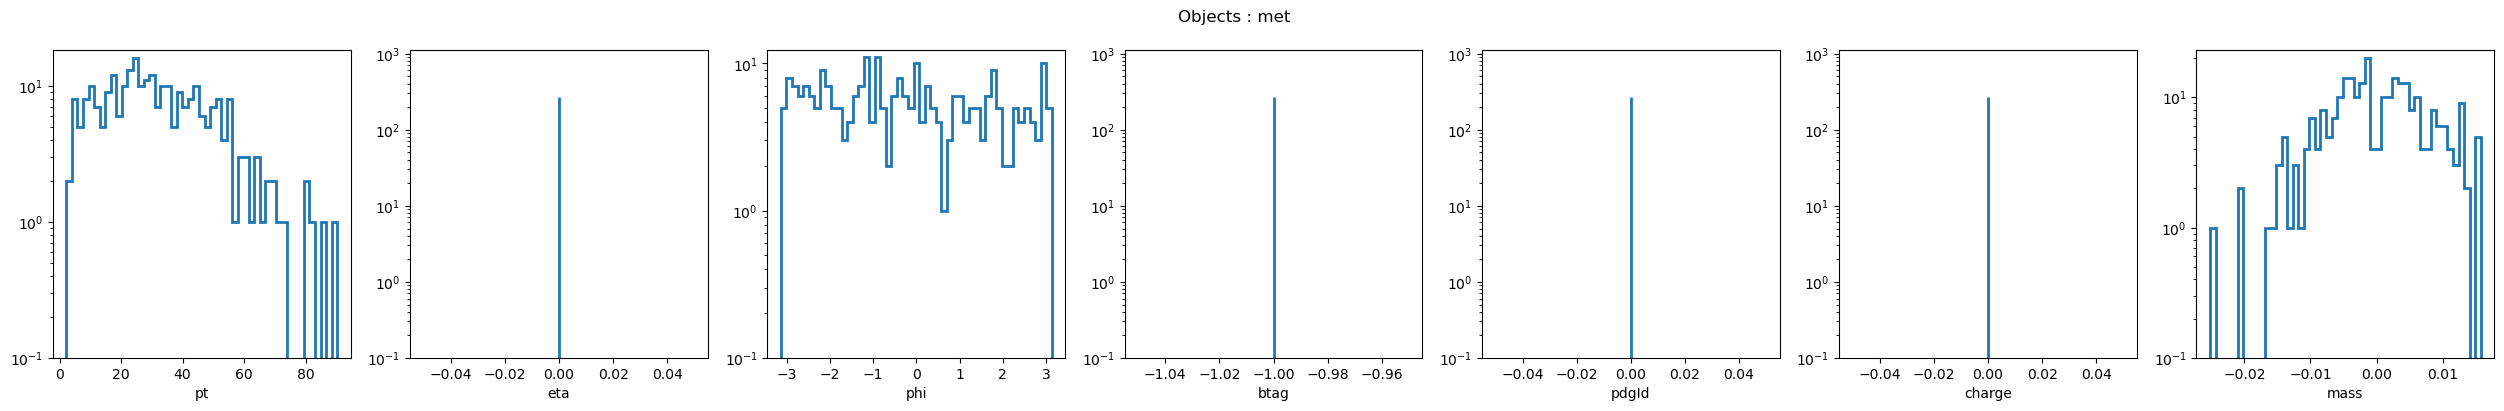

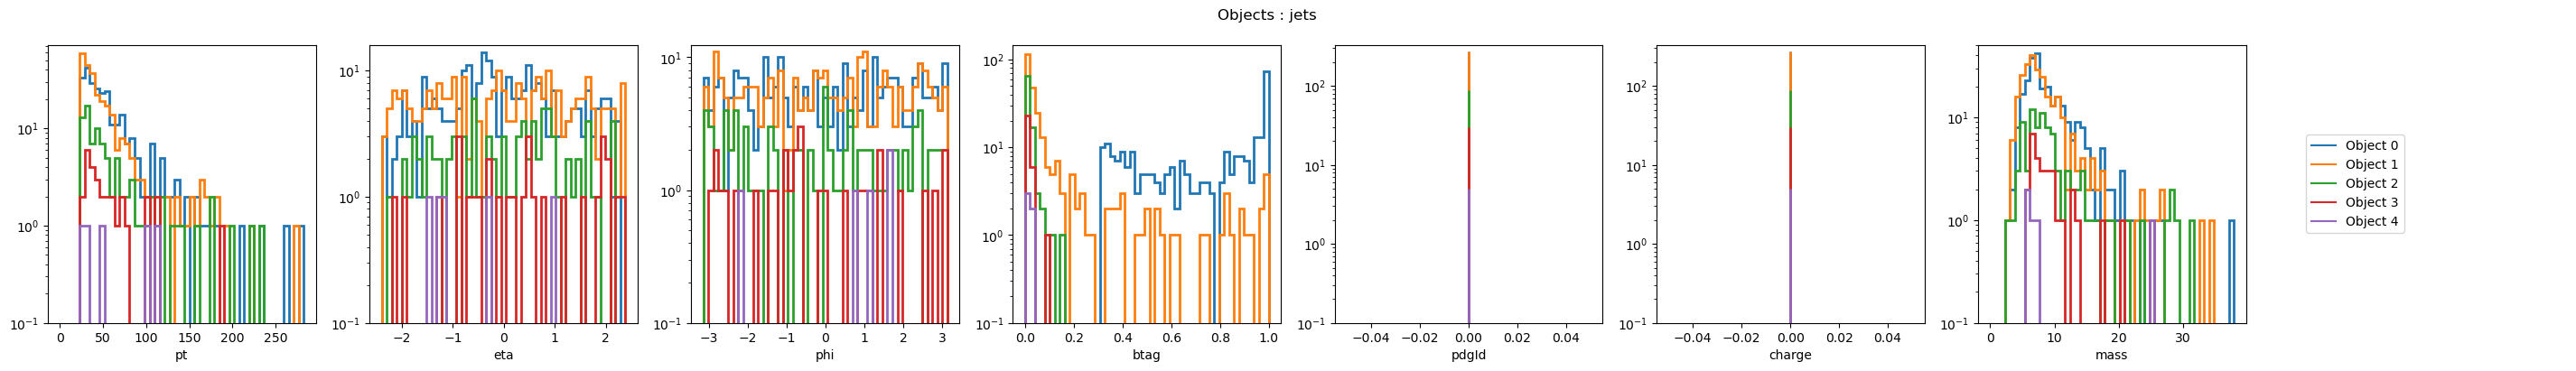

After preprocessing


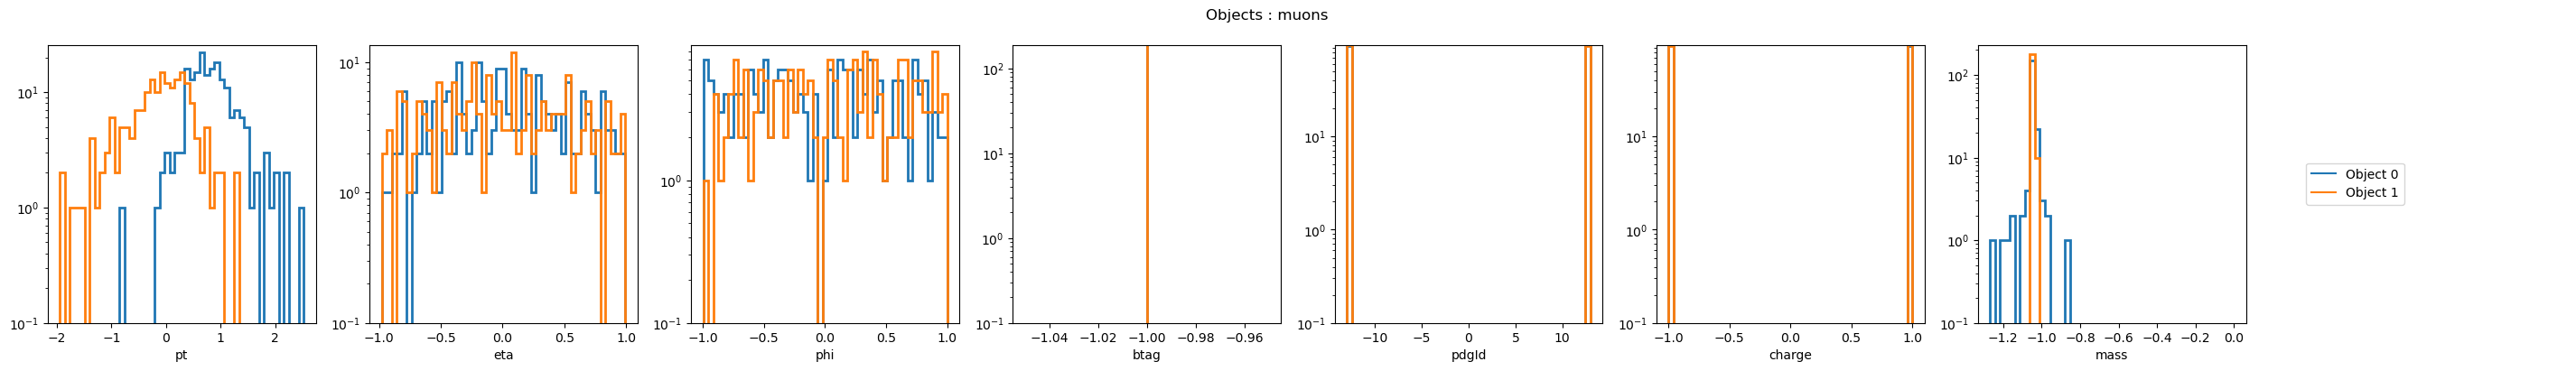

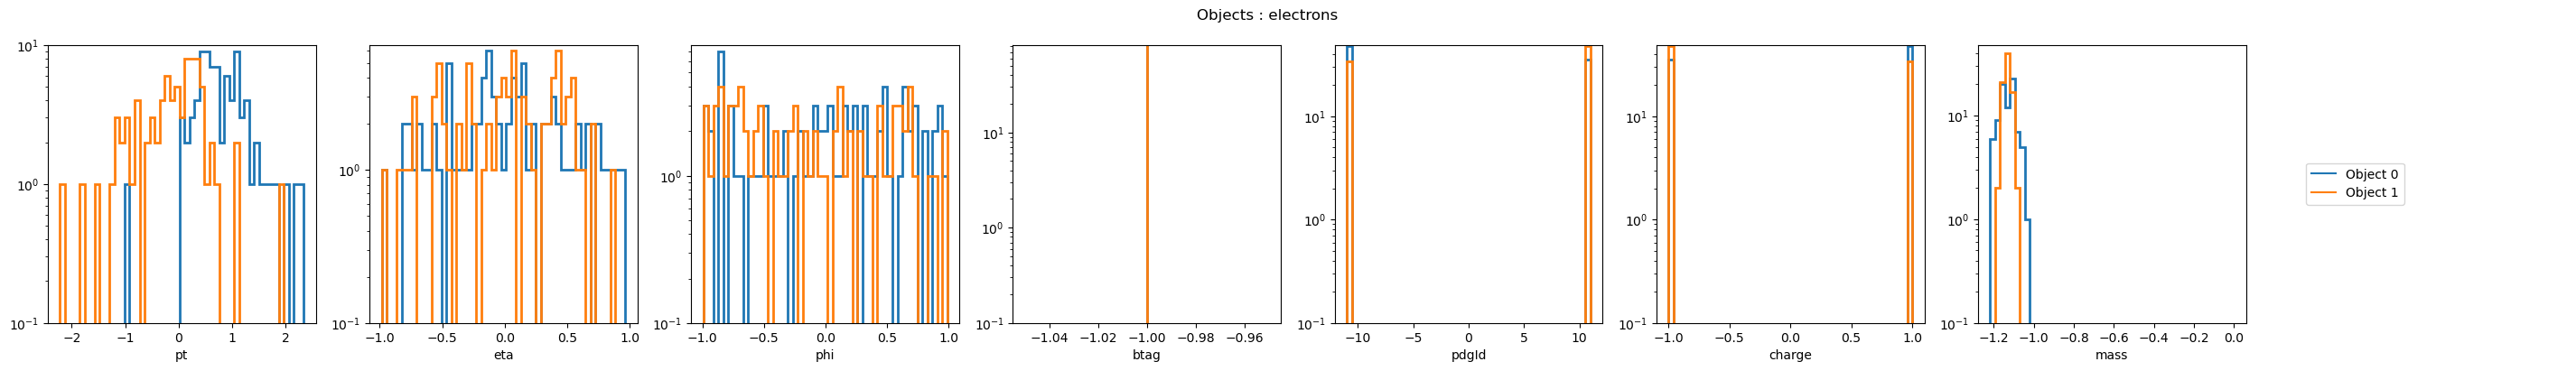

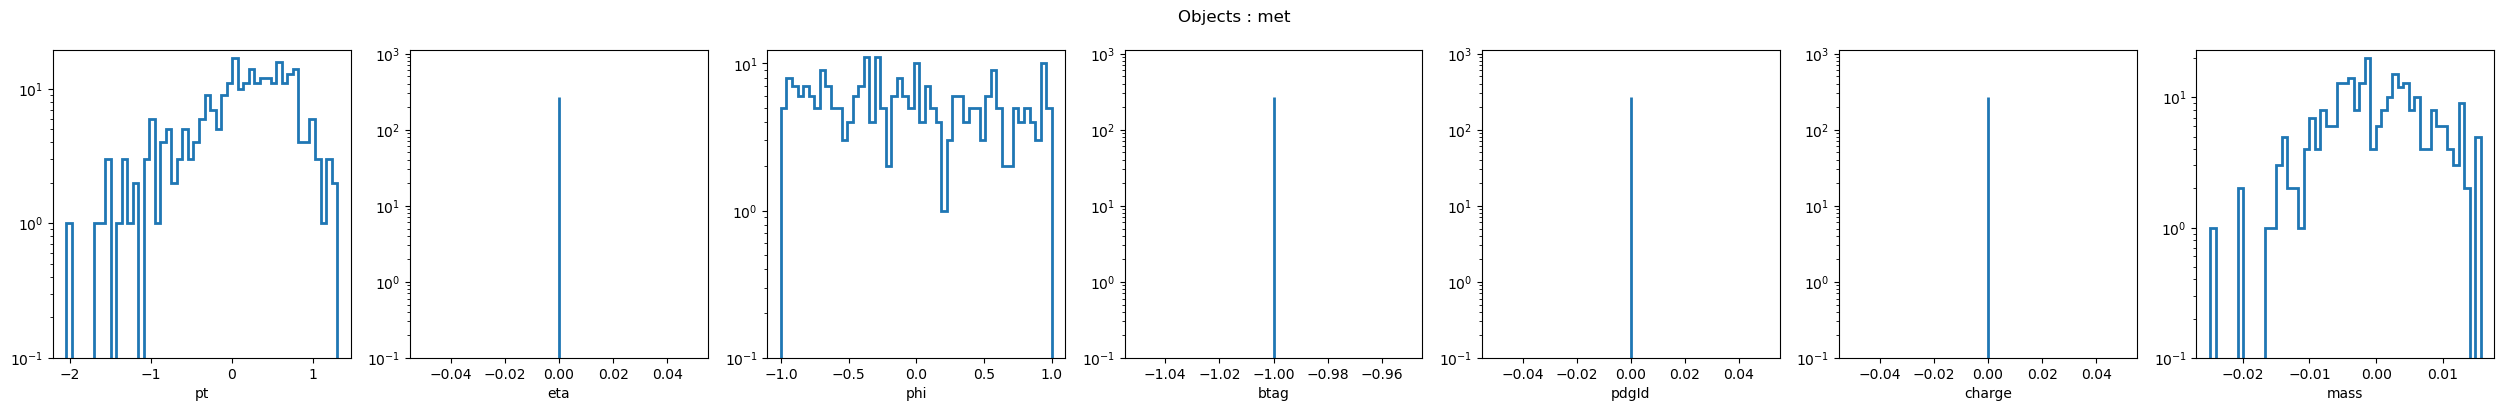

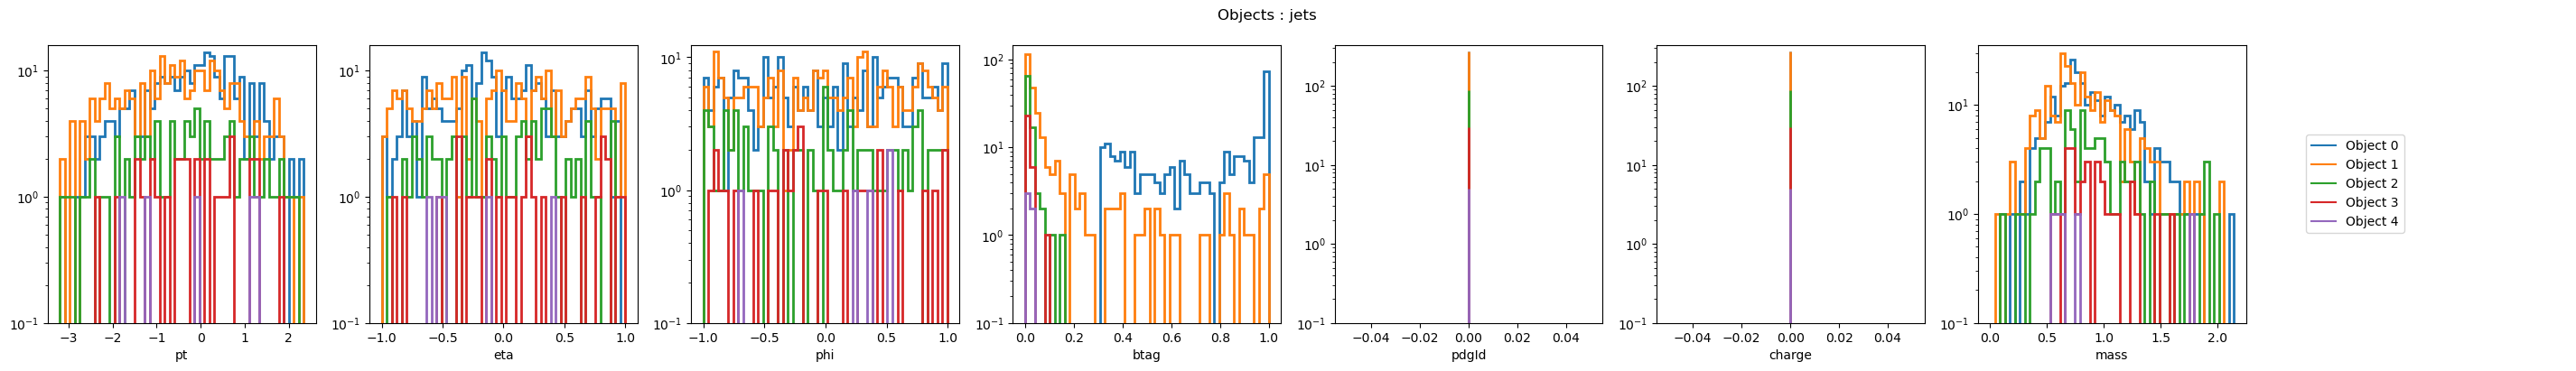

Looking into file metadata
	entry 0 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ZH_HToBB_ZToLL.root']
	entry 1 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-10to50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYJetsToLL_M-50.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_0J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_1J.root'
 '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/DYToLL_2J.root']
Will only consider common files : []
(Note : this assumes the files have the same order between the different data objects)
For entry 0 : from 6756 events, 0 selected
For entry 1 : from 271 events, 0 selected
Combined dataset (extracting 0 events of the following) :
Parton dataset with 6756 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -11]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0005109989

In [7]:
##### Hard-scattering data #####
hard_data_ZH = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ZH_HToBB_ZToLL.root',
    ],
    treenames = [
        'gen_ZH;1',
    ],
    lazy = True,
    N = int(1e4),
)

##### Hard-scattering dataset #####
hard_dataset_ZH = ZHDoubleLeptonHardDataset(
    data = hard_data_ZH,
    selection = [
        'final_states',
        'ISR',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
hard_dataset_ZH.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset_ZH.plot(selection=True,raw=False,log=True)

##### Reconstructed data #####
reco_data_ZH = RootData(
    files = hard_data_DY.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = int(1e4),
)
print ('Initial ZH:',reco_data_DY.events)

reco_data_ZH.cut(
    np.logical_and.reduce(
        (
            reco_data_ZH['flag_SR']==1, 
            reco_data_ZH['flag_resolved']==1,
            reco_data_ZH['n_AK4']<= 6,
        )
    )
)
print ('Resolved SR :',reco_data_ZH.events)

##### Reconstructed dataset #####
reco_dataset_ZH = ZHDoubleLeptonRecoDataset(
    data = reco_data_ZH,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
reco_dataset_ZH.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset_ZH.plot(selection=True,raw=False,log=True)

##### Combined dataset #####
comb_dataset_ZH = CombinedDataset(
    hard_dataset = hard_dataset_ZH,
    reco_dataset = reco_dataset_ZH,
    intersection_branch = 'event',
)
print (comb_dataset_ZH)

# ST plus datasets

Checking particle quantities
	Particle(s) ('top',) : required {1}, found {1}
	Particle(s) ('bottom',) : required {0, 1}, found {0, 1}
	Particle(s) ('W_plus_from_top',) : required {1}, found {1}
	Particle(s) ('lep_plus_from_top', 'neutrino_from_top') : required {0, 2}, found {0, 2}
	Particle(s) ('quark_up_from_top', 'antiquark_down_from_top') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_plus_from_top', 'neutrino_from_top', 'quark_up_from_top', 'antiquark_down_from_top') : required {2}, found {2}
	Particle(s) ('W_minus_prompt',) : required {1}, found {1}
	Particle(s) ('lep_minus_from_prompt_W', 'antineutrino_from_prompt_W') : required {0, 2}, found {0, 2}
	Particle(s) ('quark_down_from_prompt_W', 'antiquark_up_from_prompt_W') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_minus_from_prompt_W', 'antineutrino_from_prompt_W', 'quark_down_from_prompt_W', 'antiquark_up_from_prompt_W') : required {2}, found {2}
... done, no problem found
Selecting 1047 events out of 10000
From 1047, 

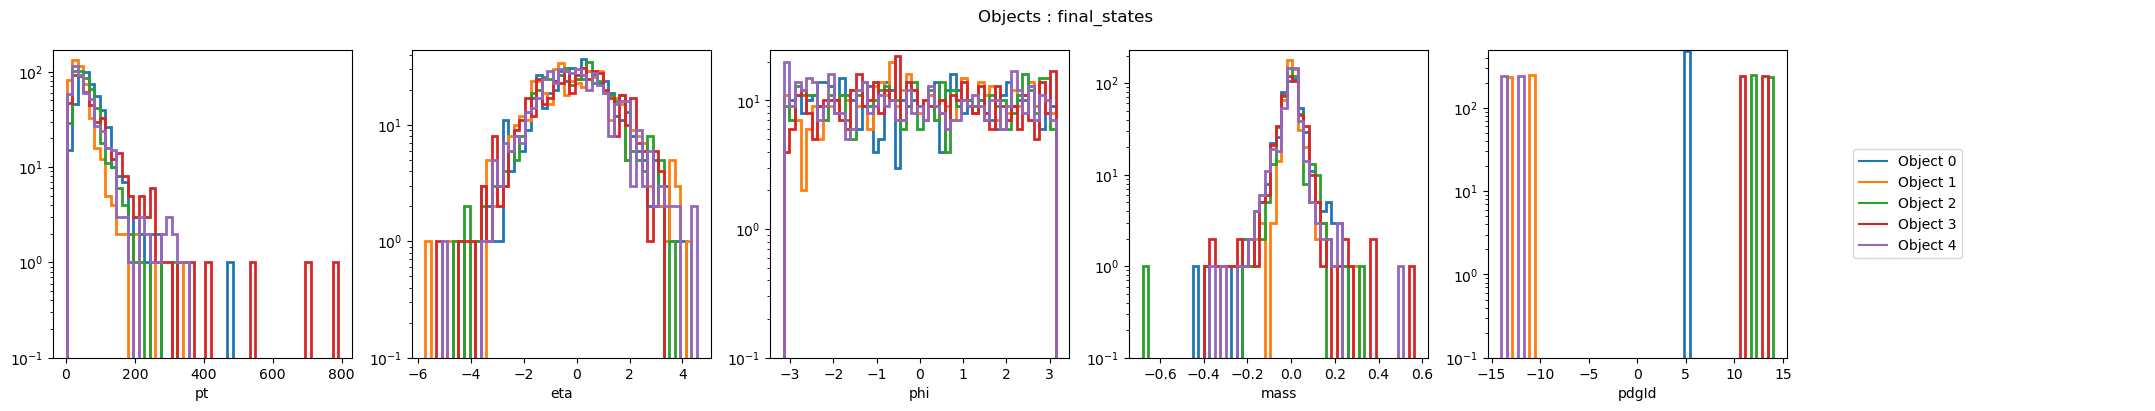

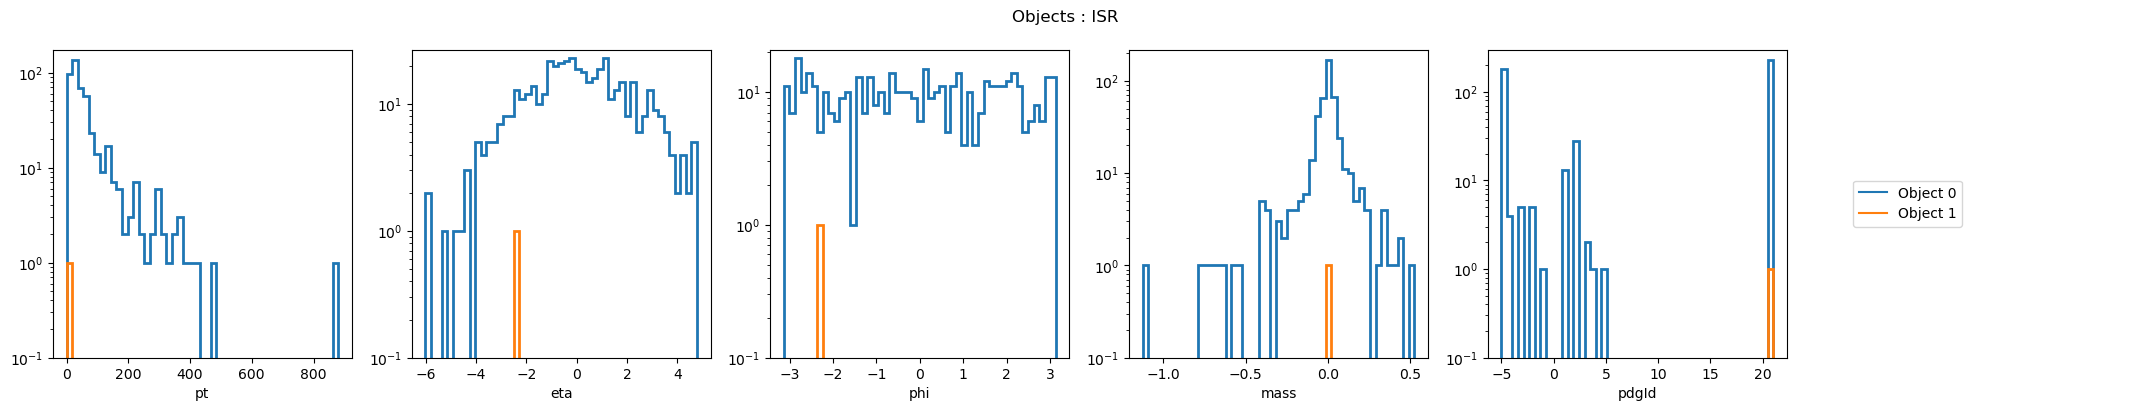

After preprocessing


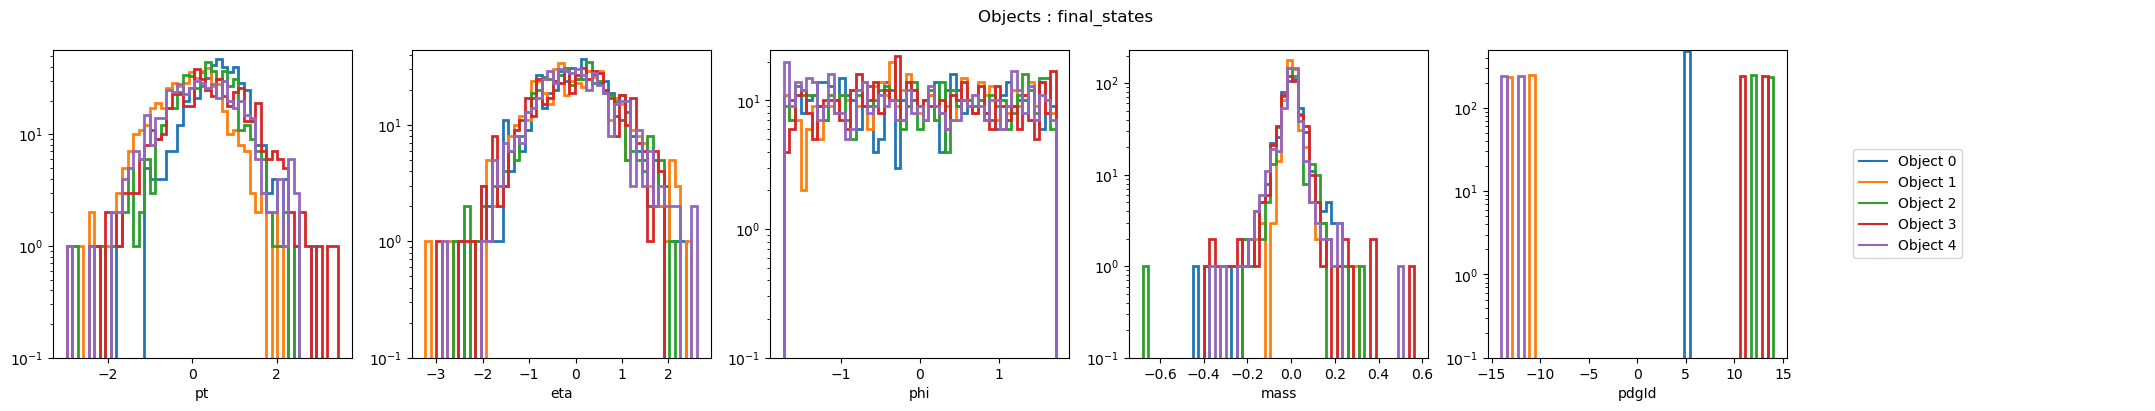

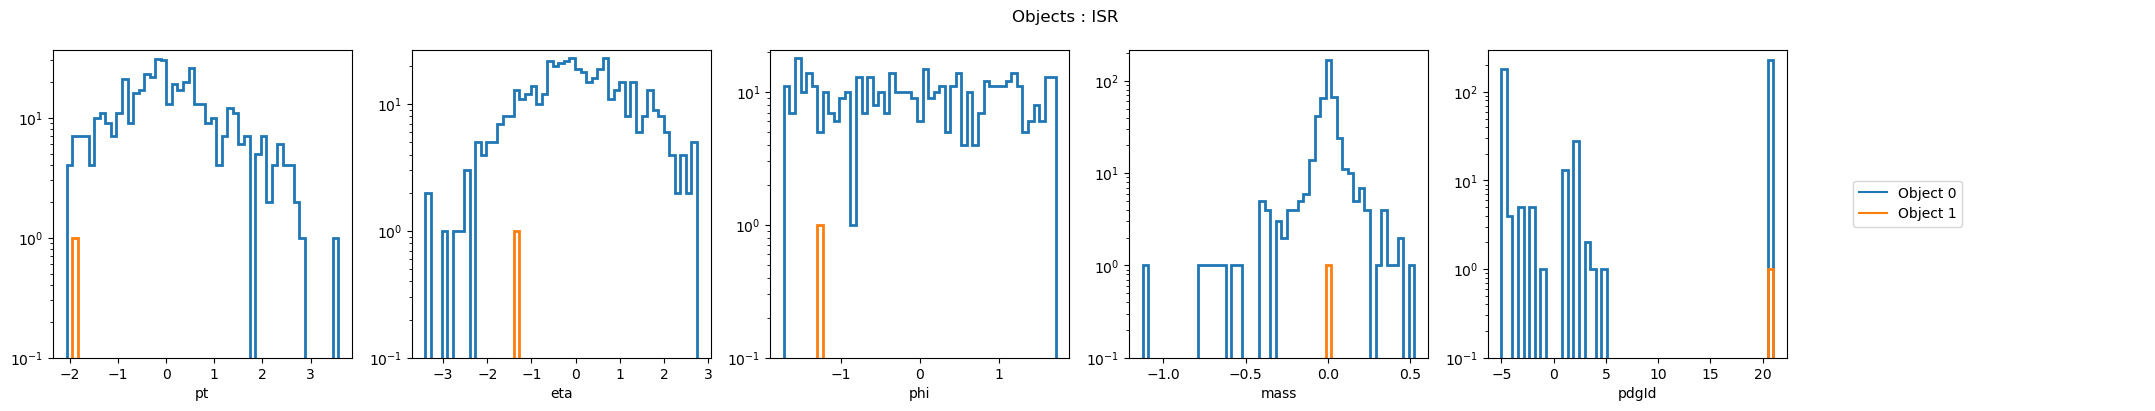

Initial ST plus: 10000
Resolved SR : 115
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/st_plus_reco
Before preprocessing


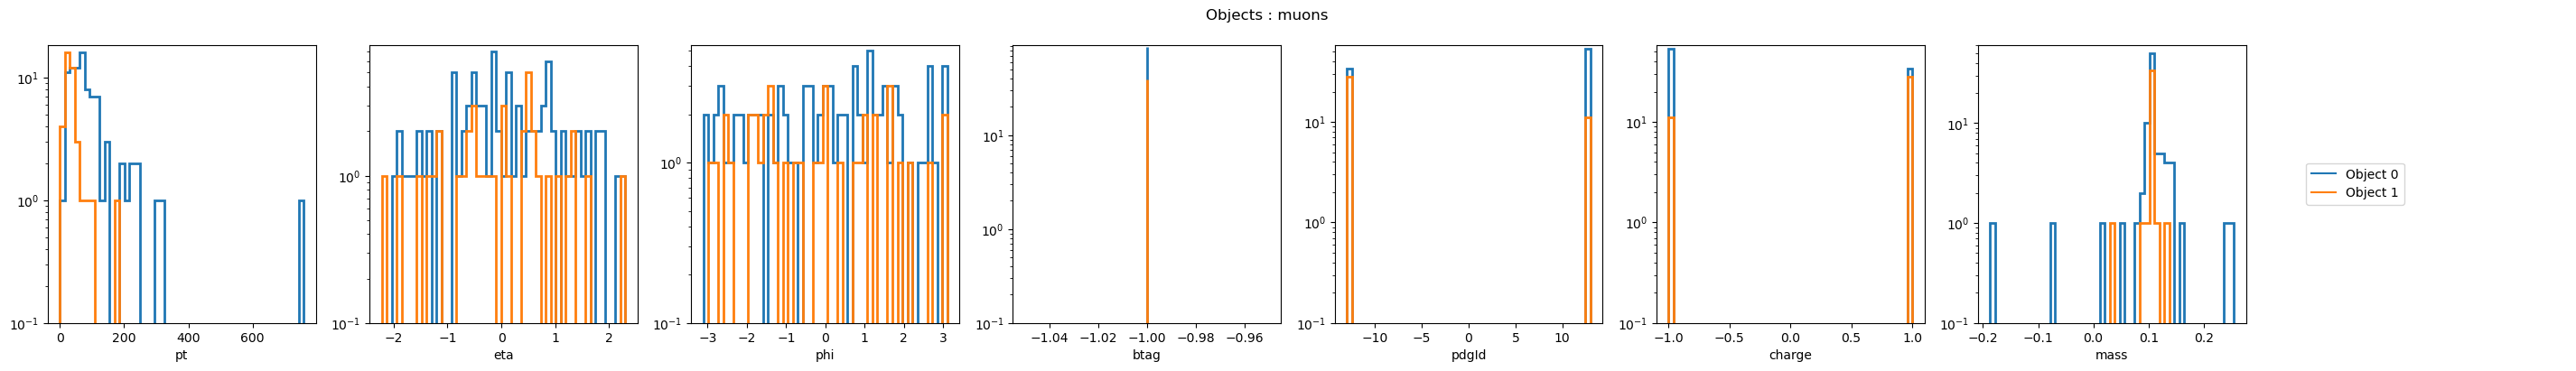

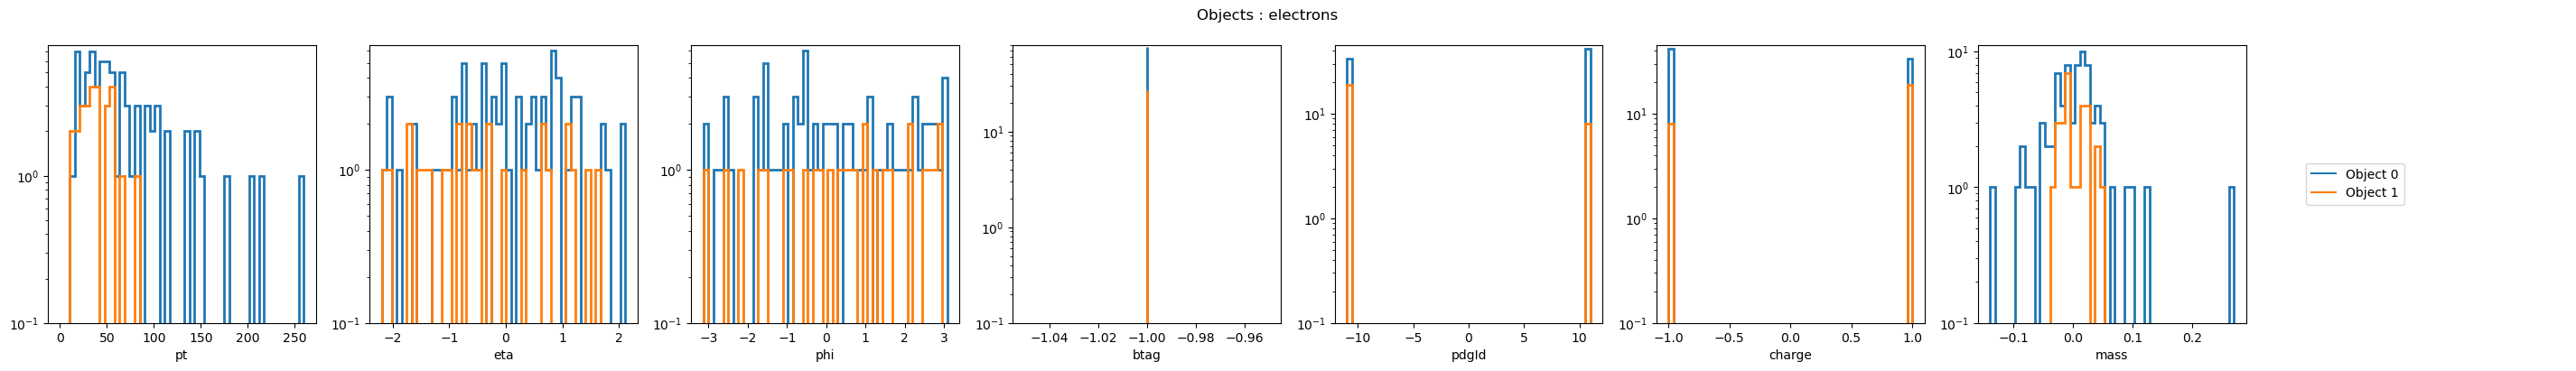

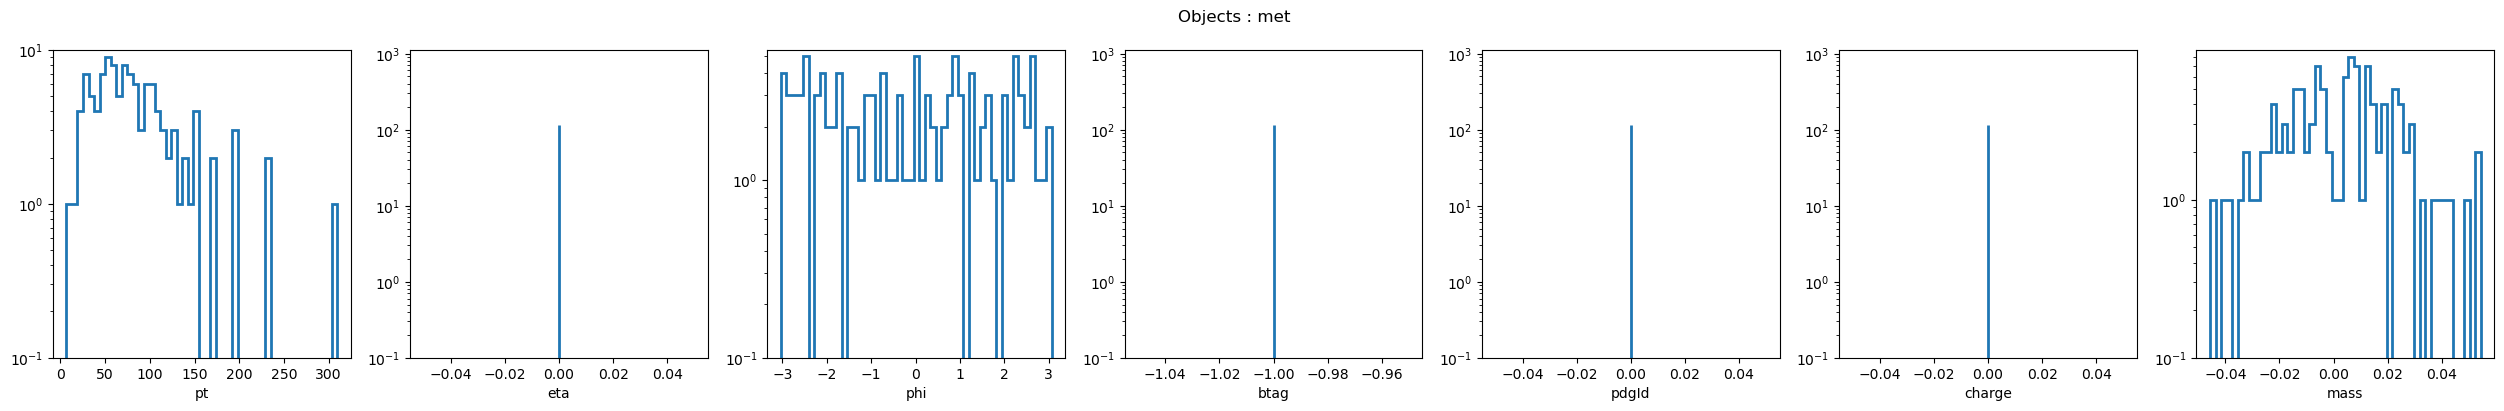

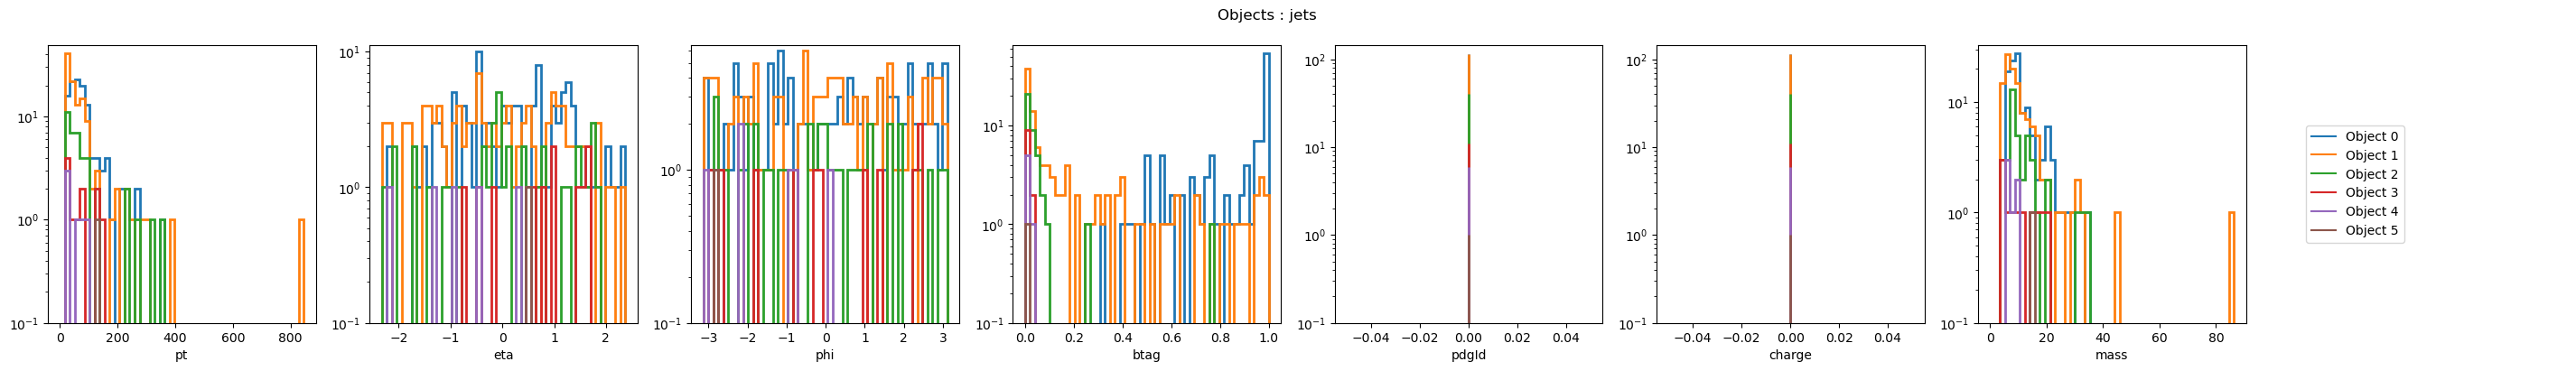

After preprocessing


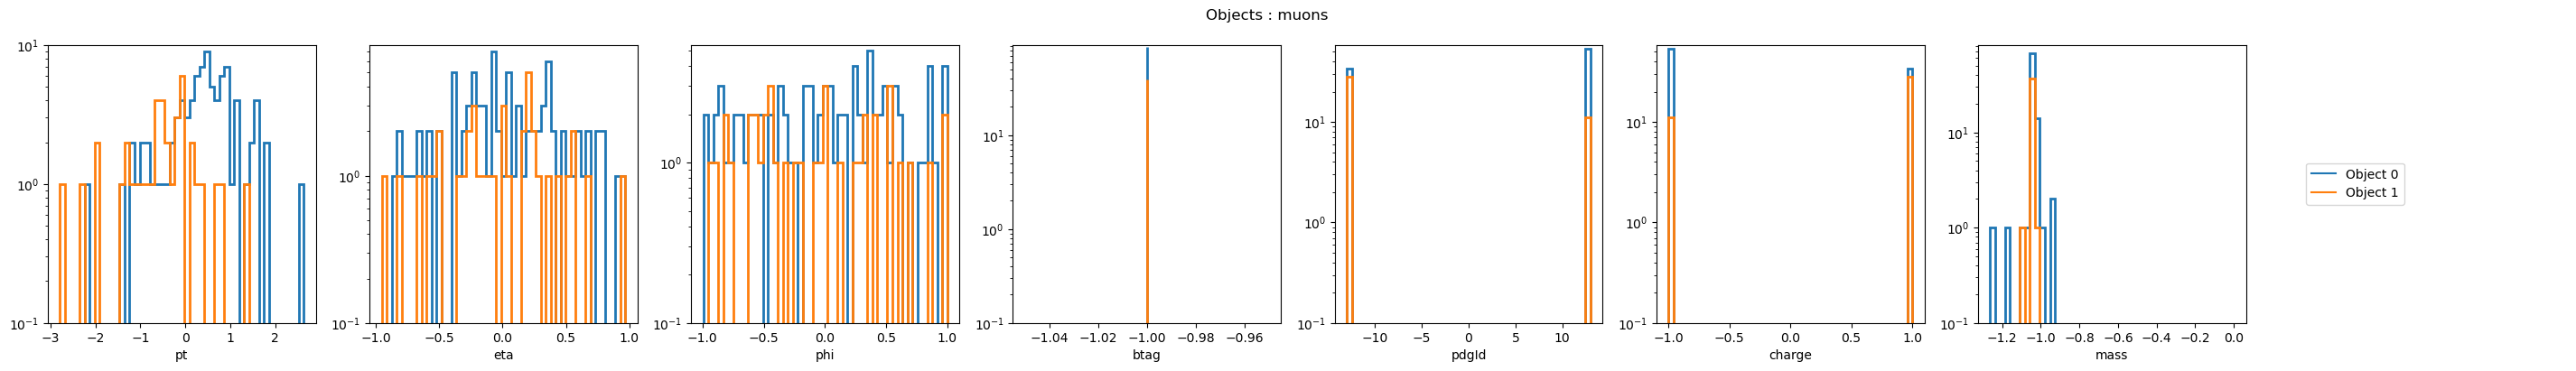

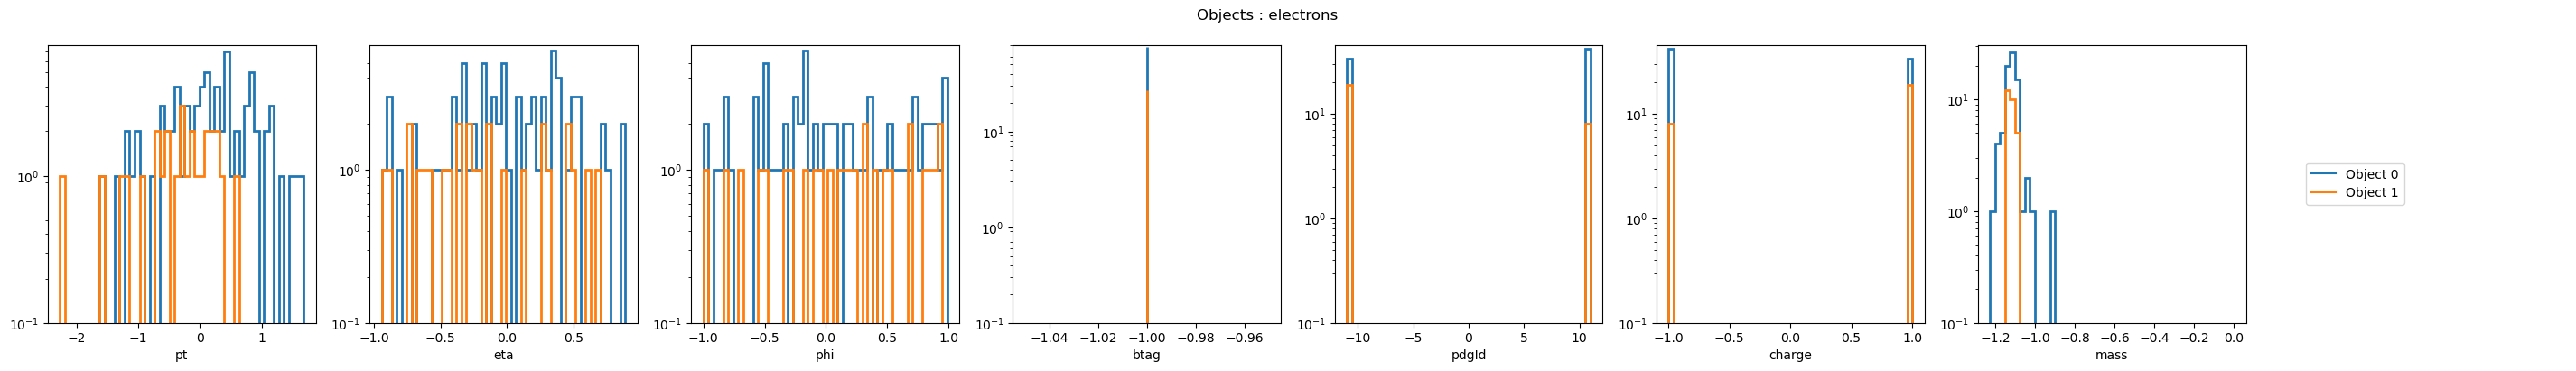

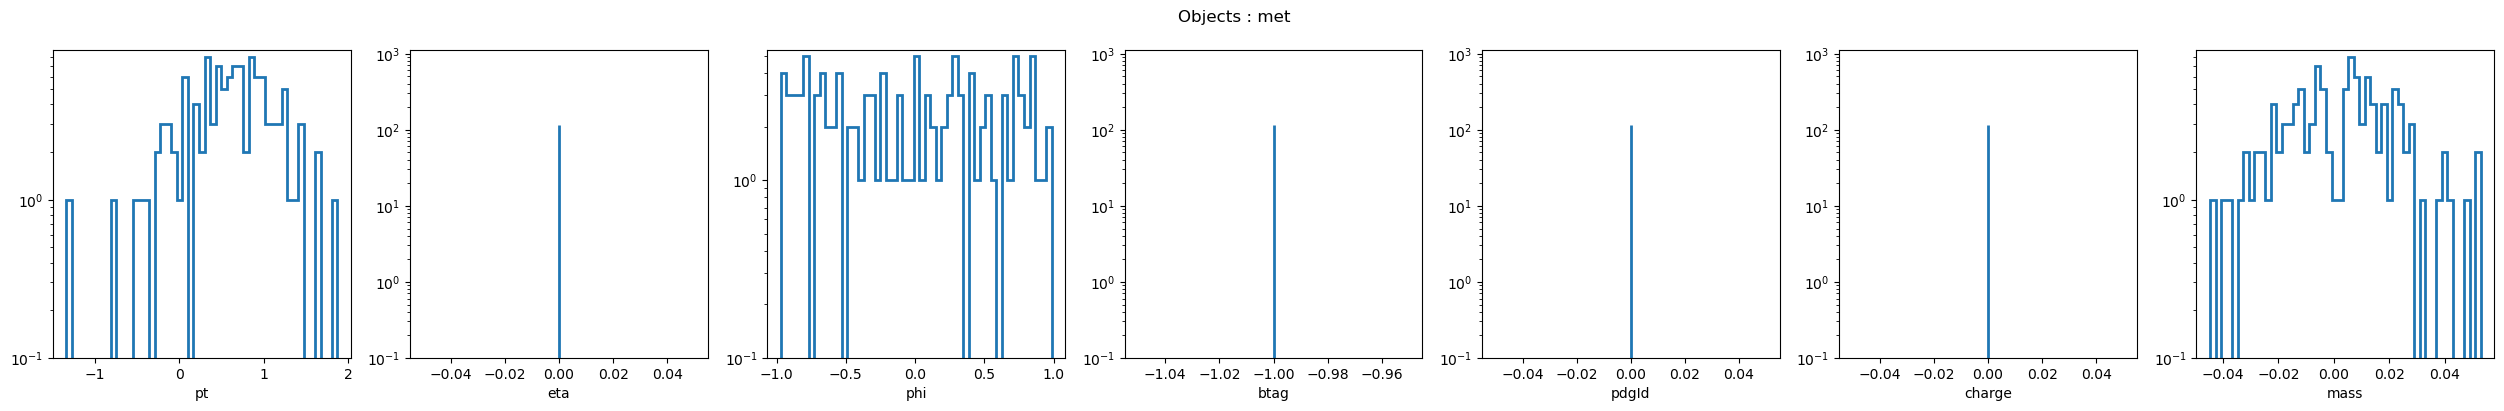

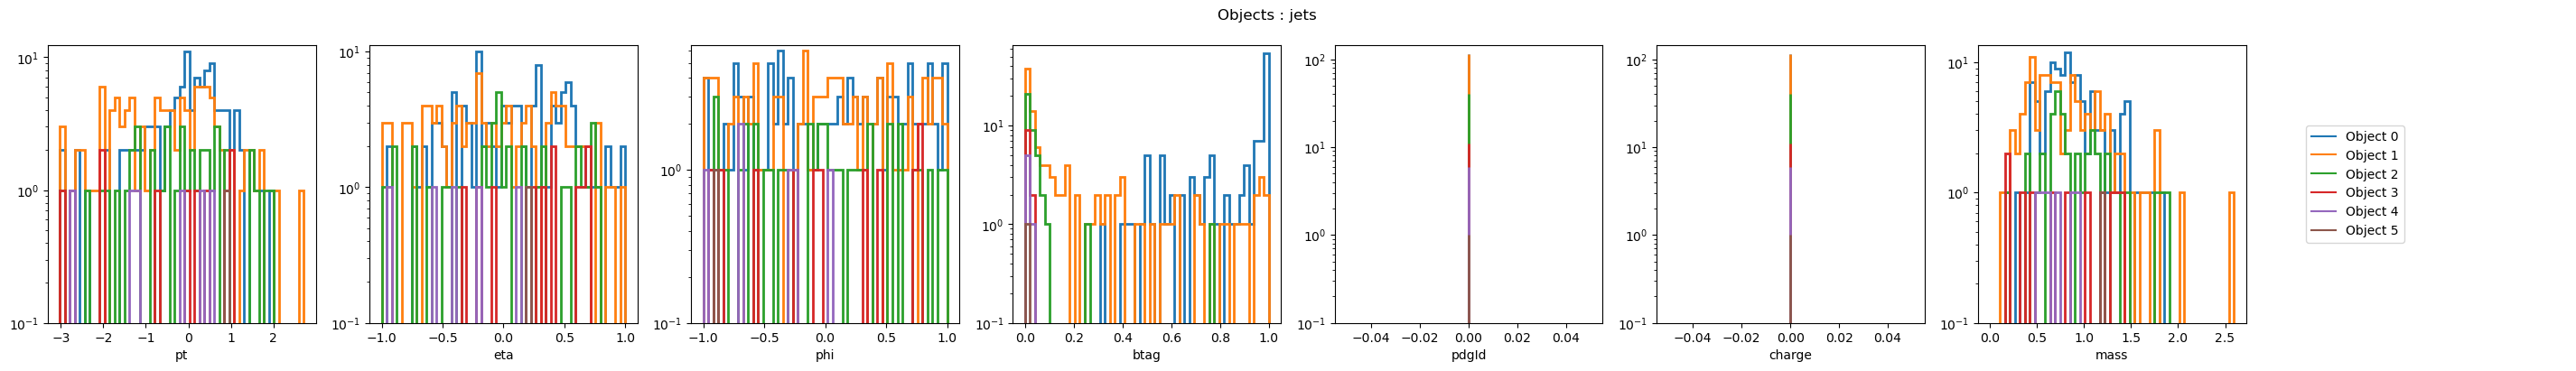

Looking into file metadata
	entry 0 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_top_5f.root']
	entry 1 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_top_5f.root']
Will only consider common files : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_top_5f.root']
(Note : this assumes the files have the same order between the different data objects)
For entry 0 : from 482 events, 98 selected
For entry 1 : from 115 events, 98 selected
Combined dataset (extracting 98 events of the following) :
Parton dataset with 482 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
final_states  : data ([482, 5, 5]), mask ([482, 5])
                Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%]
                Mask corr     : [True, True, True

In [9]:
##### Hard-scattering data #####
hard_data_ST_plus = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_top_5f.root',
    ],
    treenames = [
        'gen_ST;1',
    ],
    lazy = True,
    N = int(1e4),
)

##### Hard-scattering dataset #####
hard_dataset_ST_plus = STPlusDoubleLeptonHardDataset(
    data = hard_data_ST_plus,
    selection = [
        'final_states',
        'ISR',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
hard_dataset_ST_plus.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset_ST_plus.plot(selection=True,raw=False,log=True)

##### Reconstructed data #####
reco_data_ST_plus = RootData(
    files = hard_data_ST_plus.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = int(1e4),
)
print ('Initial ST plus:',reco_data_ST_plus.events)

reco_data_ST_plus.cut(
    np.logical_and.reduce(
        (
            reco_data_ST_plus['flag_SR']==1, 
            reco_data_ST_plus['flag_resolved']==1,
            reco_data_ST_plus['n_AK4']<= 6,
        )
    )
)
print ('Resolved SR :',reco_data_ST_plus.events)

##### Reconstructed dataset #####
reco_dataset_ST_plus = STPlusDoubleLeptonRecoDataset(
    data = reco_data_ST_plus,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
reco_dataset_ST_plus.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset_ST_plus.plot(selection=True,raw=False,log=True)

##### Combined dataset #####
comb_dataset_ST_plus = CombinedDataset(
    hard_dataset = hard_dataset_ST_plus,
    reco_dataset = reco_dataset_ST_plus,
    intersection_branch = 'event',
)
print (comb_dataset_ST_plus)

# ST minus datasets

Checking particle quantities
	Particle(s) ('antitop',) : required {1}, found {1}
	Particle(s) ('antibottom',) : required {0, 1}, found {0, 1}
	Particle(s) ('W_minus_from_antitop',) : required {1}, found {1}
	Particle(s) ('lep_minus_from_antitop', 'antineutrino_from_antitop') : required {0, 2}, found {0, 2}
	Particle(s) ('quark_down_from_antitop', 'antiquark_up_from_antitop') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_minus_from_antitop', 'antineutrino_from_antitop', 'quark_down_from_antitop', 'antiquark_up_from_antitop') : required {2}, found {2}
	Particle(s) ('W_plus_prompt',) : required {1}, found {1}
	Particle(s) ('lep_plus_from_prompt_W', 'neutrino_from_prompt_W') : required {0, 2}, found {0, 2}
	Particle(s) ('quark_up_from_prompt_W', 'antiquark_down_from_prompt_W') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_plus_from_prompt_W', 'neutrino_from_prompt_W', 'quark_up_from_prompt_W', 'antiquark_down_from_prompt_W') : required {2}, found {2}
... done, no problem found
Se

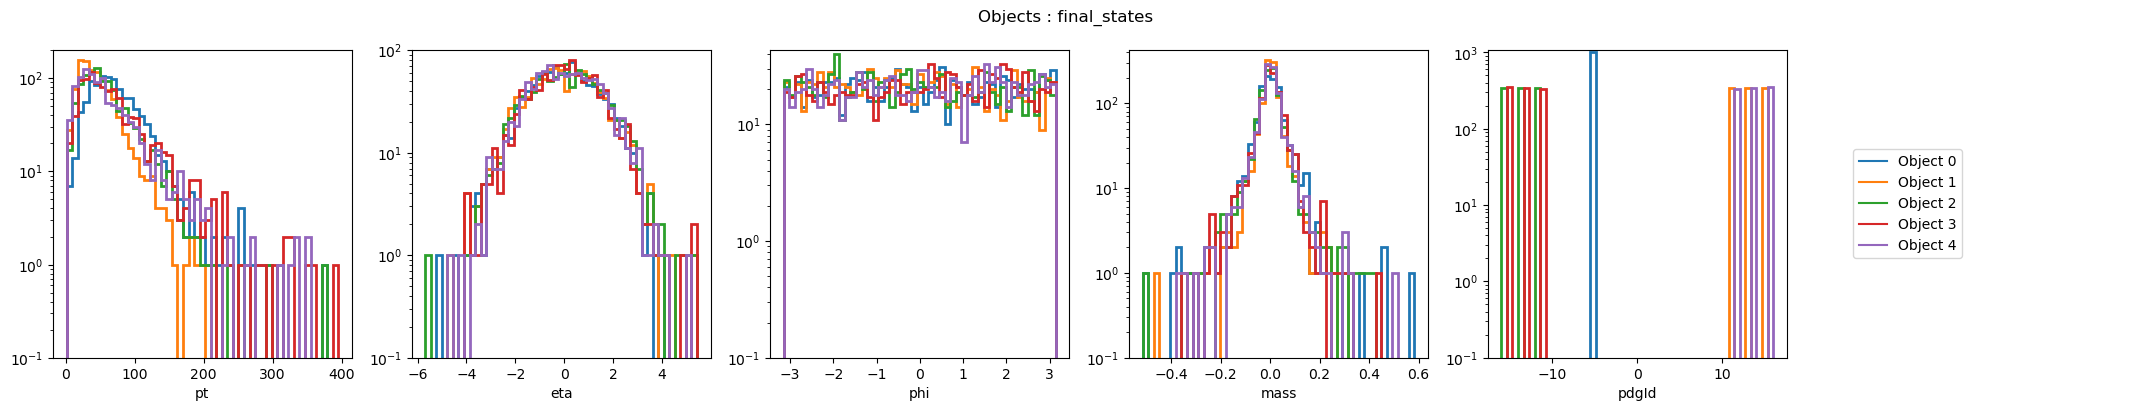

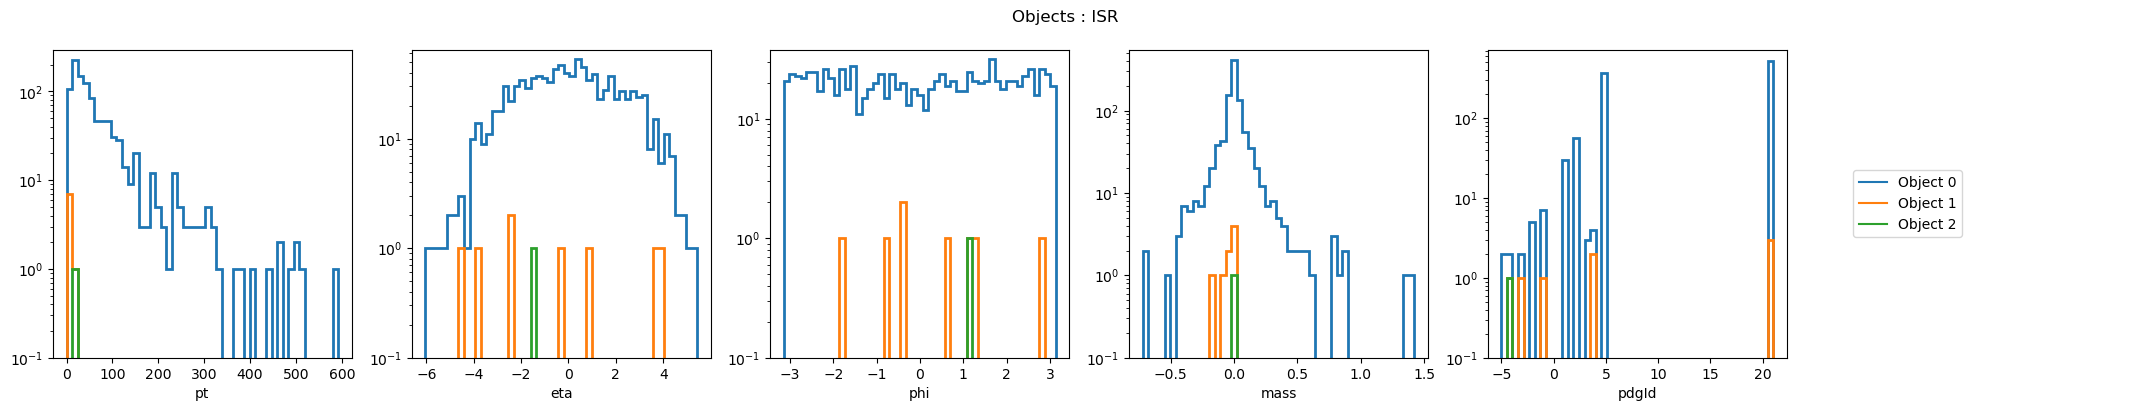

After preprocessing


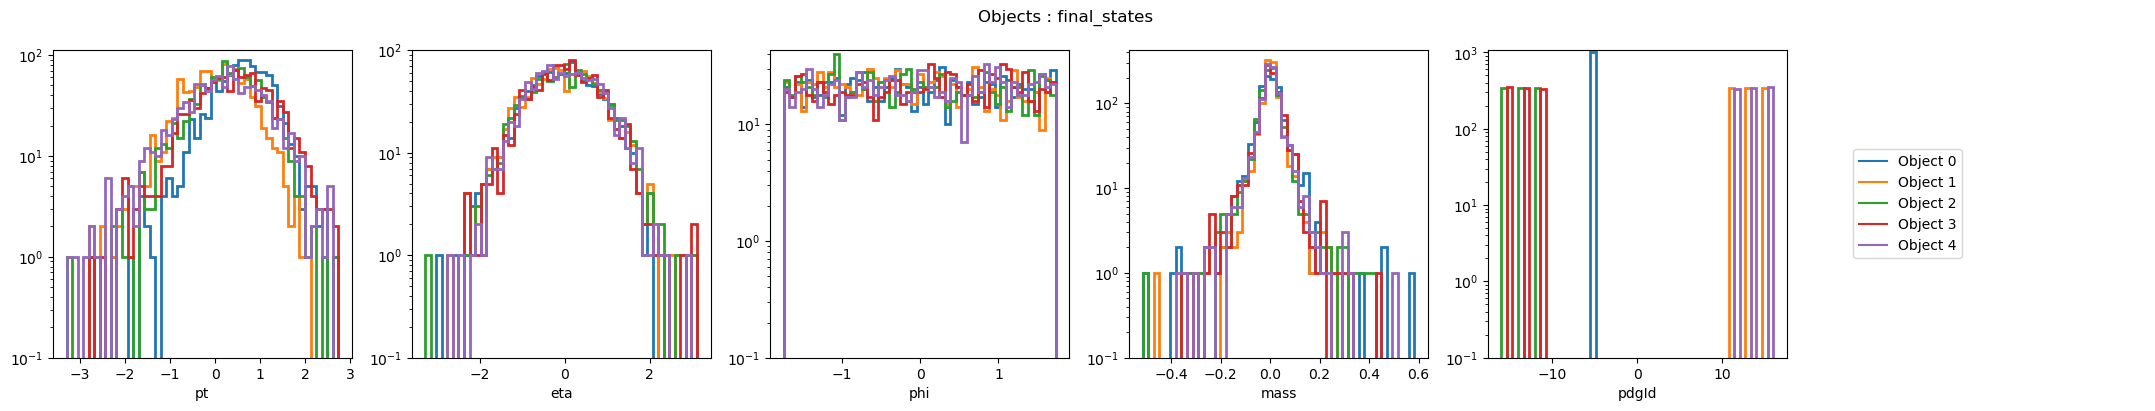

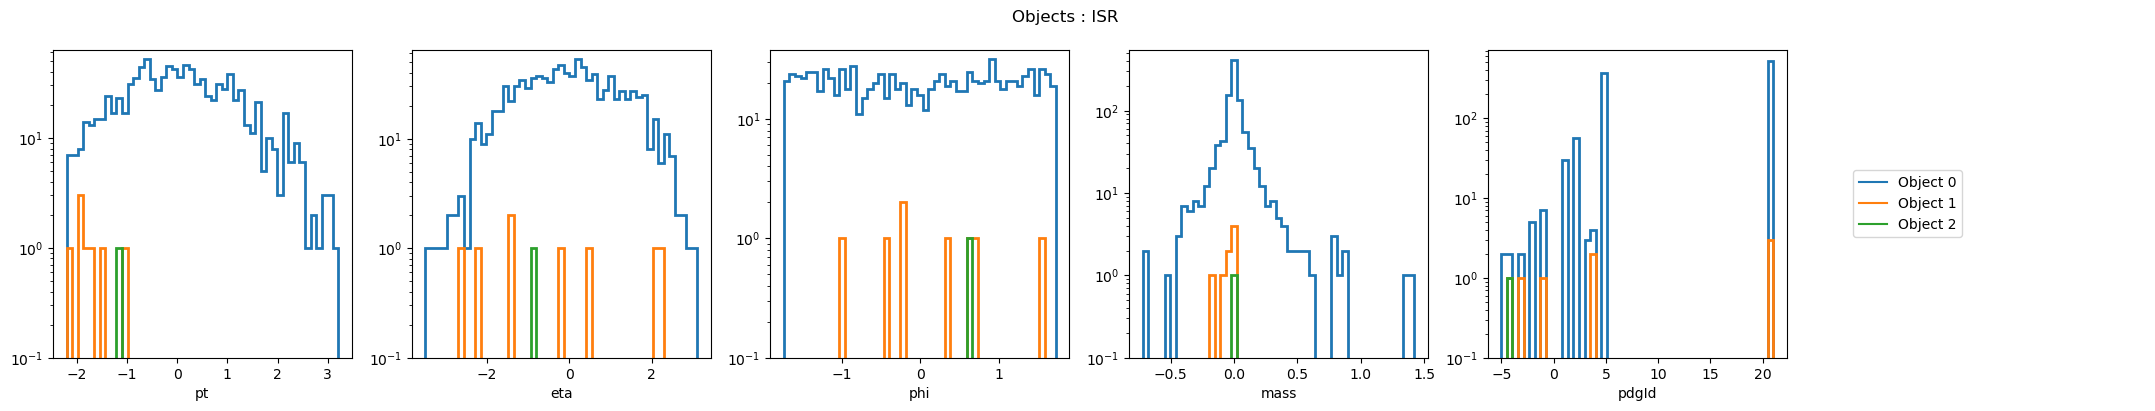

Initial ST minus: 10000
Resolved SR : 115
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/st_minus_reco
Before preprocessing


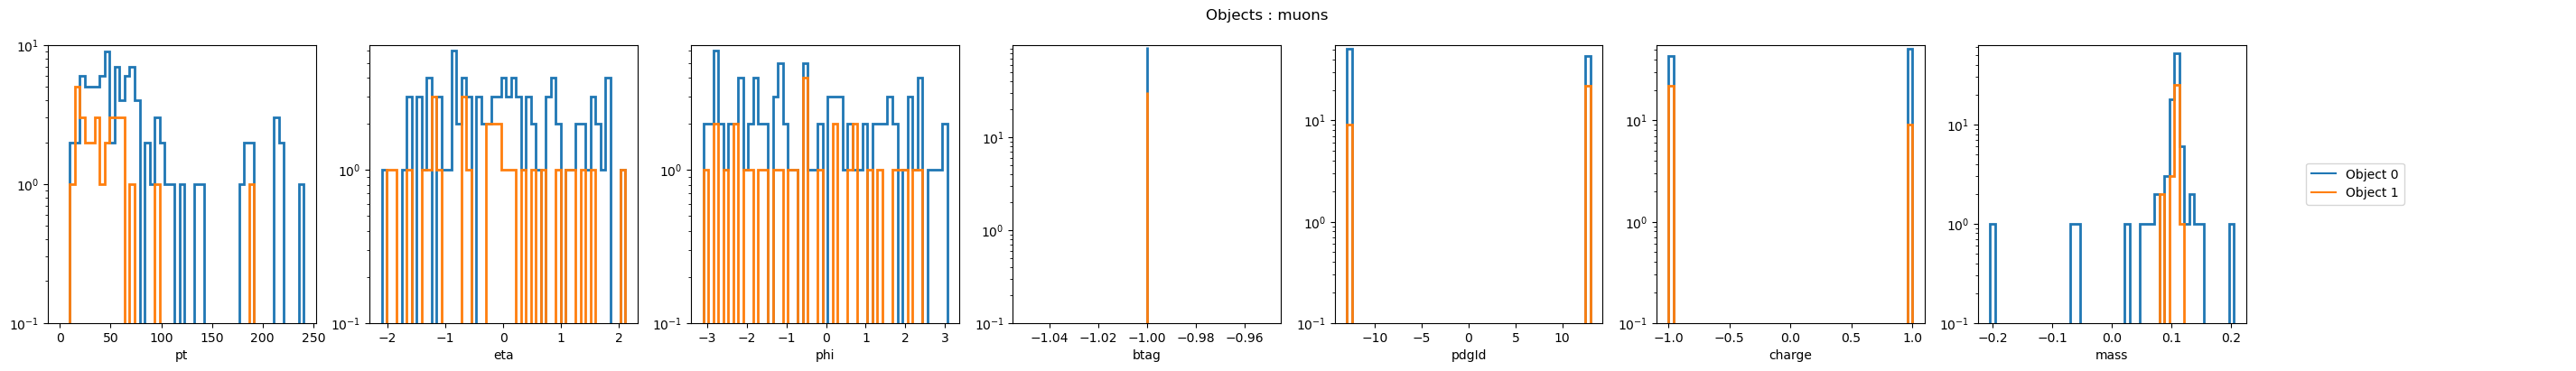

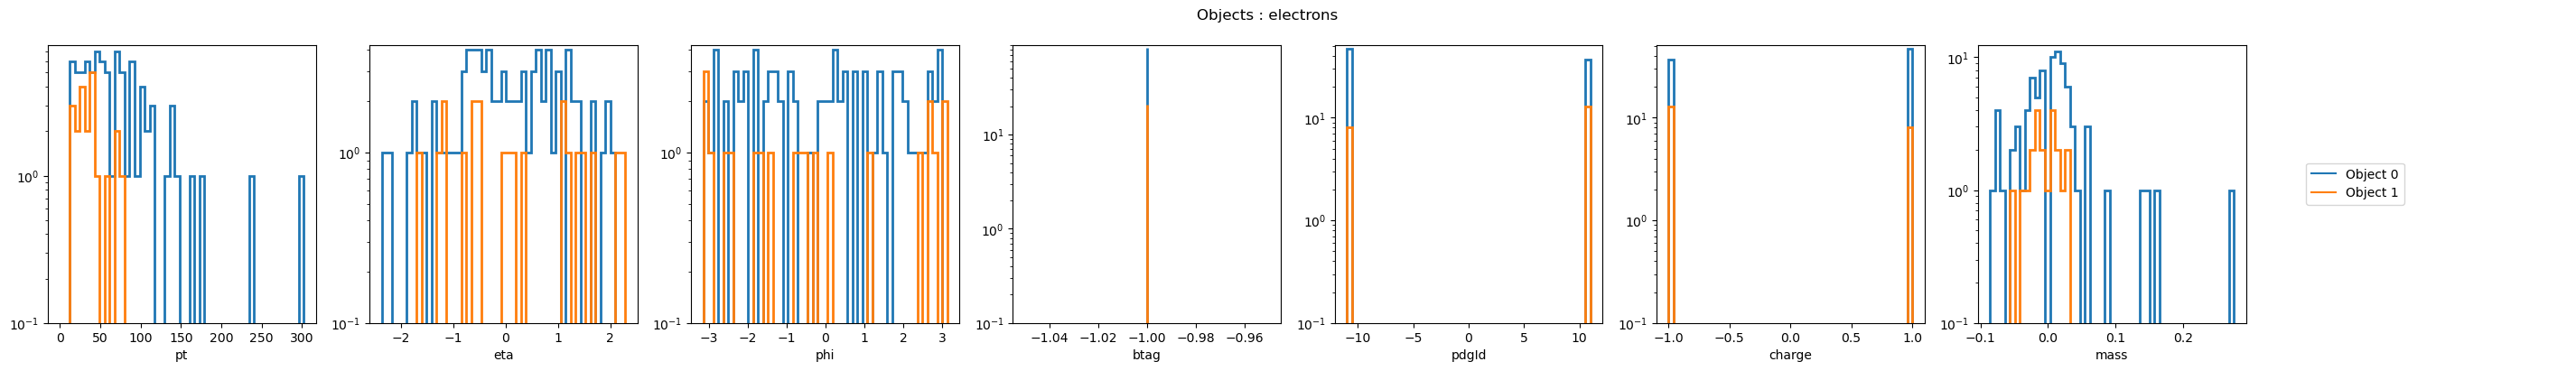

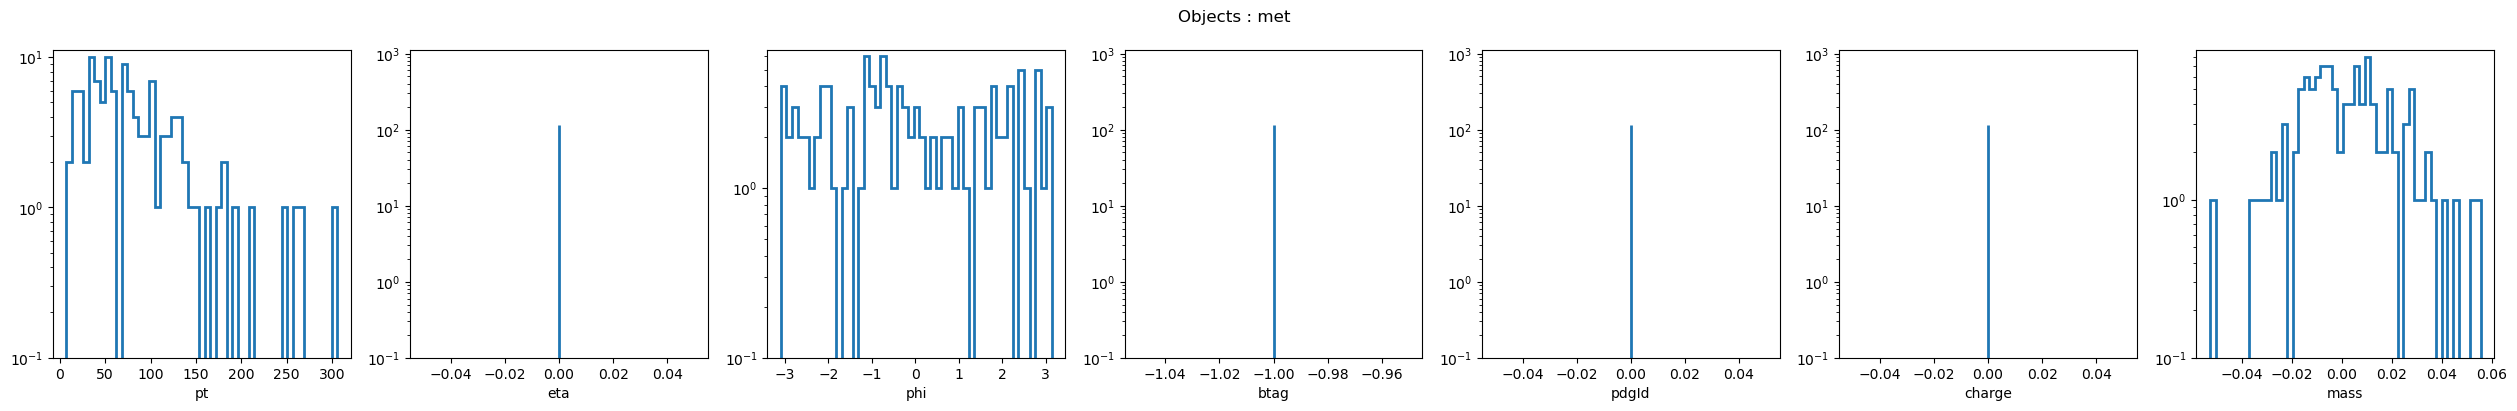

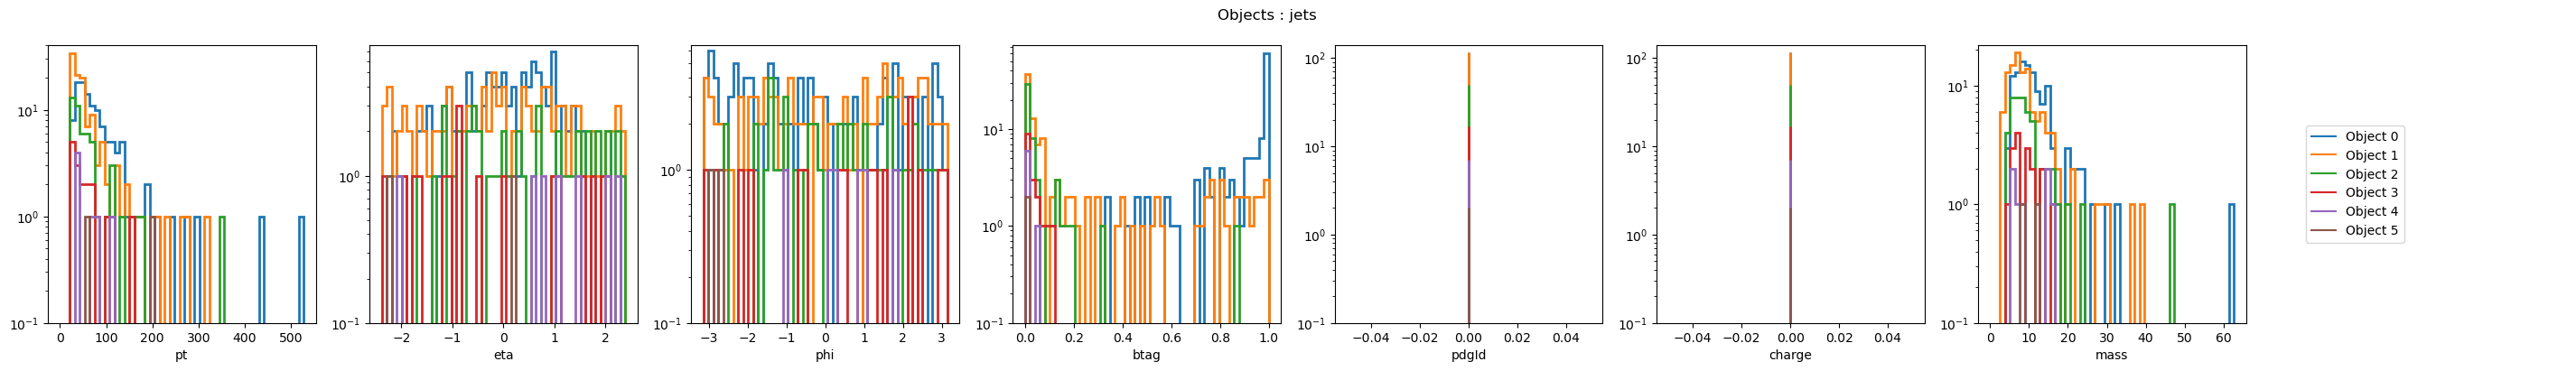

After preprocessing


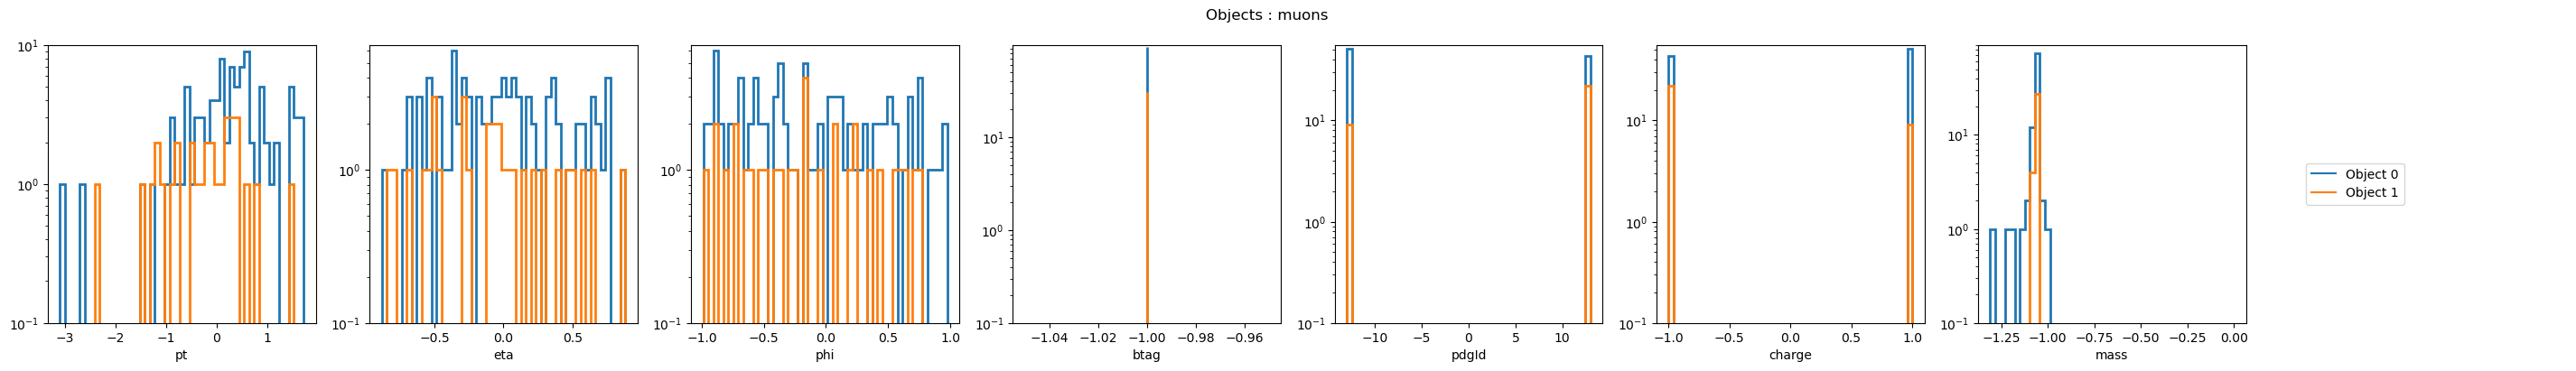

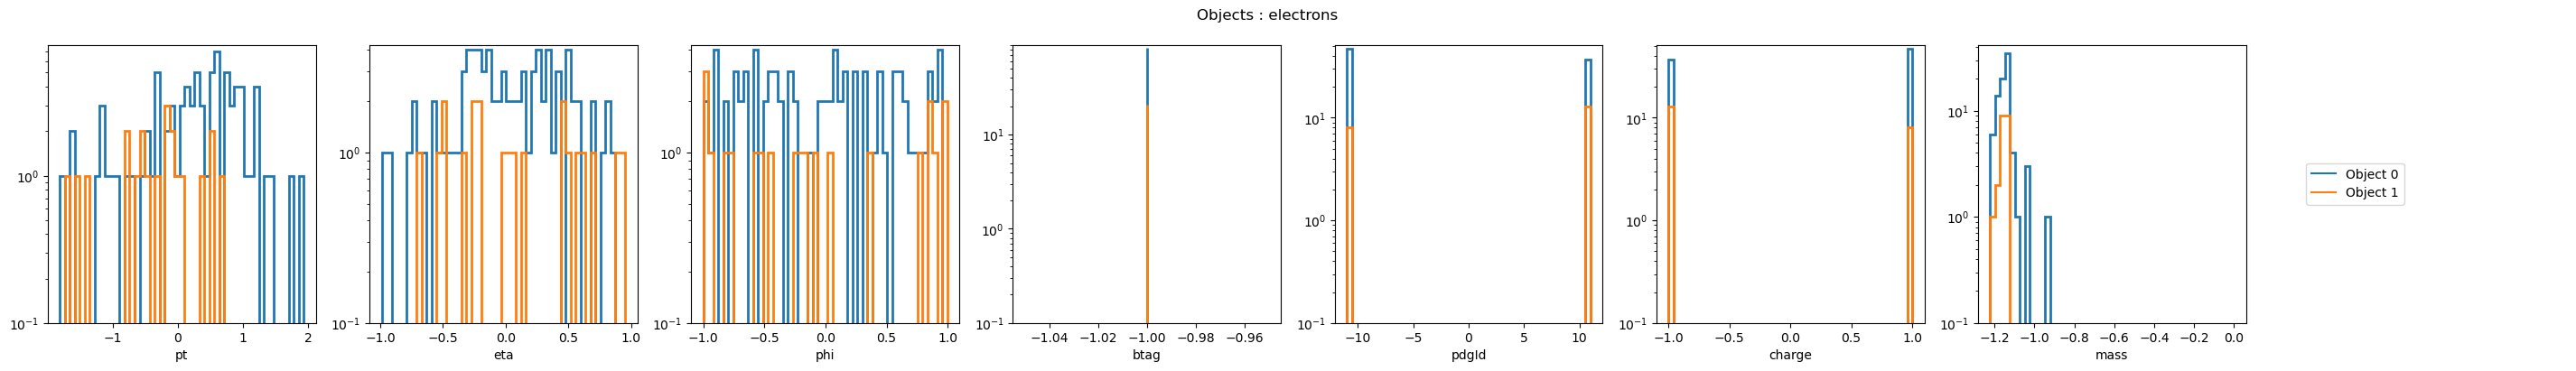

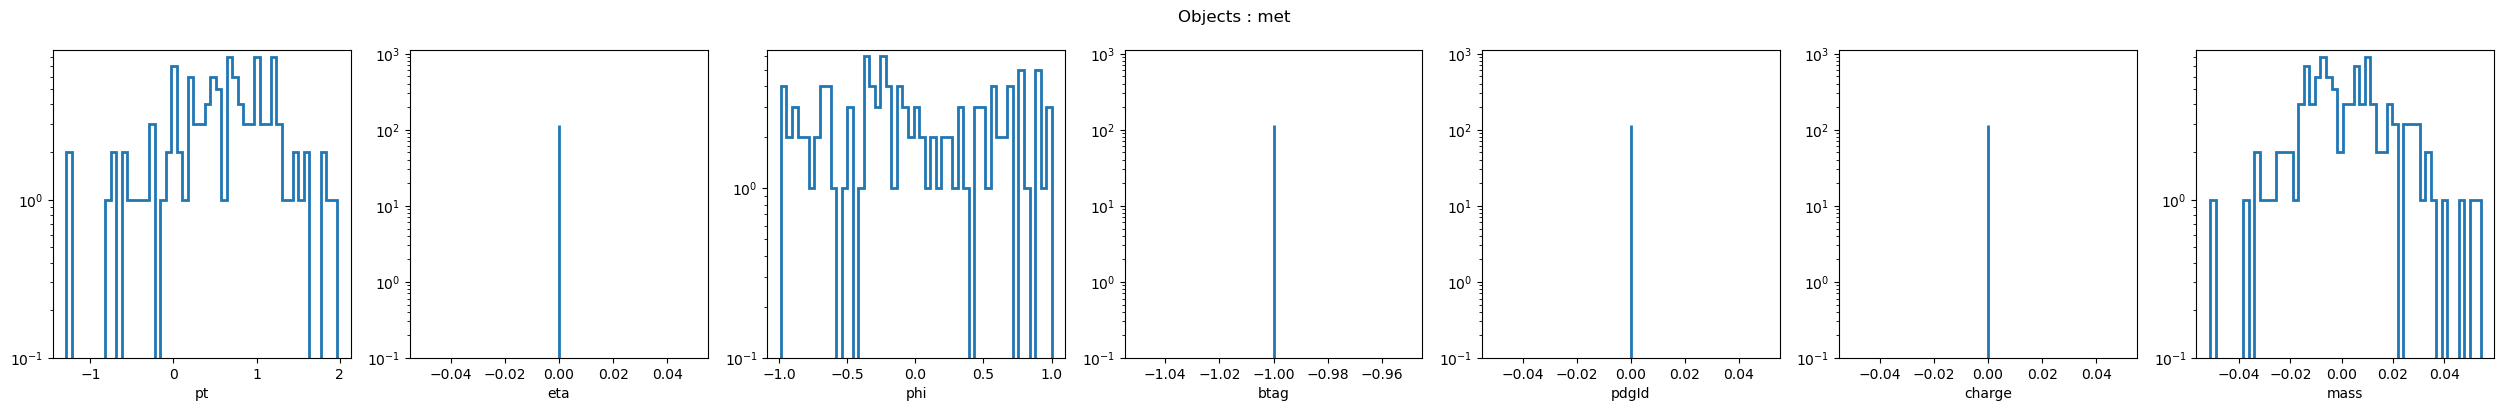

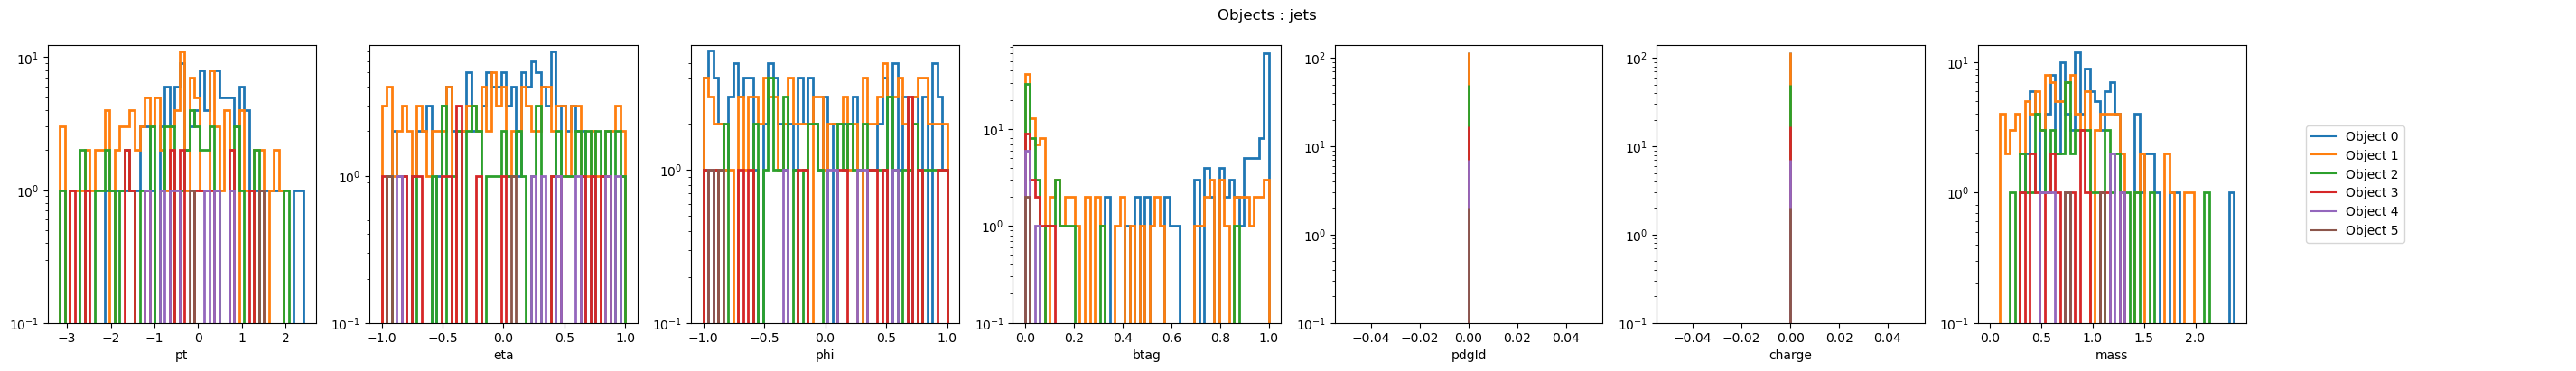

Looking into file metadata
	entry 0 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_antitop_5f.root']
	entry 1 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_antitop_5f.root']
Will only consider common files : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_antitop_5f.root']
(Note : this assumes the files have the same order between the different data objects)
For entry 0 : from 1026 events, 115 selected
For entry 1 : from 115 events, 115 selected
Combined dataset (extracting 115 events of the following) :
Parton dataset with 1026 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
final_states  : data ([1026, 5, 5]), mask ([1026, 5])
                Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%]
                Mask corr     

In [11]:
##### Hard-scattering data #####
hard_data_ST_minus = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v4_2016/results/ST_tW_antitop_5f.root',
    ],
    treenames = [
        'gen_ST;1',
    ],
    lazy = True,
    N = int(1e4),
)

##### Hard-scattering dataset #####
hard_dataset_ST_minus = STMinusDoubleLeptonHardDataset(
    data = hard_data_ST_minus,
    selection = [
        'final_states',
        'ISR',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
hard_dataset_ST_minus.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset_ST_minus.plot(selection=True,raw=False,log=True)

##### Reconstructed data #####
reco_data_ST_minus = RootData(
    files = hard_data_ST_minus.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = int(1e4),
)
print ('Initial ST minus:',reco_data_ST_minus.events)

reco_data_ST_minus.cut(
    np.logical_and.reduce(
        (
            reco_data_ST_minus['flag_SR']==1, 
            reco_data_ST_minus['flag_resolved']==1,
            reco_data_ST_minus['n_AK4']<= 6,
        )
    )
)
print ('Resolved SR :',reco_data_ST_minus.events)

##### Reconstructed dataset #####
reco_dataset_ST_minus = STMinusDoubleLeptonRecoDataset(
    data = reco_data_ST_minus,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print ('Before preprocessing')
reco_dataset_ST_minus.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset_ST_minus.plot(selection=True,raw=False,log=True)

##### Combined dataset #####
comb_dataset_ST_minus = CombinedDataset(
    hard_dataset = hard_dataset_ST_minus,
    reco_dataset = reco_dataset_ST_minus,
    intersection_branch = 'event',
)
print (comb_dataset_ST_minus)

# Combined processes

In [12]:
comb_dataset = MultiCombinedDataset(
    datasets = [
        comb_dataset_HH,
        comb_dataset_TT,
        comb_dataset_DY,
        comb_dataset_ZZ,
        comb_dataset_ZH,
        comb_dataset_ST_plus,
        comb_dataset_ST_minus,
    ]
)
print ([len(dataset) for dataset in comb_dataset.datasets])
print (comb_dataset)

RuntimeError: Different sets of inputs features : {(('pt', 'eta', 'phi', 'mass', 'pdgId'), ('pt', 'eta', 'phi', 'mass', 'pdgId')), (('pt', 'eta', 'phi', 'mass', 'pdgId'),)}

# Training

In [6]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.9
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)
print (len(comb_dataset_train),len(comb_dataset_valid))

batch_size = 1024

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

518980 57665


In [7]:
from memflow.models.transfer_flow_model import TransferFlow

model = TransferFlow(
    # Harderal args #
    dropout = 0.,
    # Embedding arguments #
    embed_dims = [32,64],
    embed_act = nn.GELU,
    # Particle features, names, masks, and number for printouts and logging #
    n_hard_particles_per_type = comb_dataset.hard_datasets[0].number_particles_per_type,
    hard_particle_type_names = comb_dataset.hard_datasets[0].selection,
    hard_input_features_per_type = comb_dataset.hard_datasets[0].input_features,
    n_reco_particles_per_type = comb_dataset.reco_datasets[0].number_particles_per_type,
    reco_particle_type_names = comb_dataset.reco_datasets[0].selection,
    reco_input_features_per_type = comb_dataset.reco_datasets[0].input_features,
    flow_input_features = [ # features to be used in the flows (different from the tranformer)
        ['pt','eta','phi'], # electrons
        ['pt','eta','phi'], # muons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    hard_mask_attn = comb_dataset.hard_datasets[0].attention_mask,
    reco_mask_attn = comb_dataset.reco_datasets[0].attention_mask,
    # Transformer arguments #
    onehot_encoding = True, # add onehot encoded position vector to features
    transformer_args = { # to be passed to the Transformer pytorch class
        'nhead' : 8,
        'num_encoder_layers' : 8, 
        'num_decoder_layers' : 8, 
        'dim_feedforward' : 128, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    # Flow args #
    flow_common_args = { # common args for all flows
        'bins' : 8,
        'transforms' : 5,
        'randperm' : True,
        'passes' : None,
        'hidden_features' : [128] * 3,   
    },
    flow_classes = { # classes for each feature
        'pt'  : zuko.flows.NSF,
        'eta' : UniformNSF,
        'phi' : UniformNCSF,
        'pt'  : zuko.flows.NSF,
    },
    flow_specific_args = { # specific args for each class above
        'eta' : {'bound' : 1.},
        'phi' : {'bound' : 1.},
    },
    flow_mode = 'global', # 'global', 'type' or 'particle'
)
model = model.cpu()

batch = next(iter(loader_comb_train))
log_probs, mask, weights = model(batch)
print ('log_probs',log_probs,log_probs.shape)
print ('mask',mask,mask.shape)
print ('weights',weights,weights.shape)

log_probs_tot = model.shared_eval(batch,0,'test')
print ('tot log probs',log_probs_tot)

samples = model.sample(batch['hard']['data'],batch['hard']['mask'],batch['reco']['data'],batch['reco']['mask'],N=100)
print ('samples')
for sample in samples:
    print ('\t',sample.shape)

print (model)


/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/BucketizationUtils.h:32.)
  return torch.searchsorted(seq, value).squeeze(dim=-1)


log_probs tensor([[3.1304, 2.8974, 3.0945,  ..., 2.9897, 2.9924, 2.9953],
        [2.5576, 2.4732, 2.9477,  ..., 3.0048, 3.0066, 3.0081],
        [2.8709, 2.8629, 2.4592,  ..., 2.9703, 2.9711, 2.9715],
        ...,
        [2.5016, 2.9226, 3.0436,  ..., 3.0029, 3.0050, 3.0052],
        [4.4400, 2.8700, 2.7500,  ..., 2.9680, 2.9712, 2.9738],
        [3.2397, 2.8955, 2.8500,  ..., 2.9748, 2.9771, 2.9774]],
       grad_fn=<NegBackward0>) torch.Size([1024, 13])
mask tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.]]) torch.Size([1024, 13])
weights tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tot log probs tensor(2.7471, grad_fn=<MeanBackward0>)
samples
	 torch.Size([100, 1024, 2, 3])
	 torch.Size([100, 1024, 2, 3])
	 torch.Size([100, 1024, 1, 2])
	 torch.Size([100, 1024, 8, 3])
TransferFlow(
  (hard_embeddings): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): GELU(approximate='none')
    )
  )
  (reco_embeddings): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=21, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): GELU(approximate='none')
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bi

In [13]:
bias_HH = BiasCallback(
    dataset = comb_dataset_HH,
    N_sample = 100,
    frequency = 10,
    raw = True,
    bins = 101,
    points = 20,
    log_scale = True,
    batch_size = 5000,
    N_batch = 10,
    suffix = 'HH',
)
bias_TT = BiasCallback(
    dataset = comb_dataset_TT,
    N_sample = 100,
    frequency = 10,
    raw = True,
    bins = 101,
    points = 20,
    log_scale = True,
    batch_size = 5000,
    N_batch = 10,
    suffix = 'TT',
)
bias_DY = BiasCallback(
    dataset = comb_dataset_DY,
    N_sample = 100,
    frequency = 10,
    raw = True,
    bins = 101,
    points = 20,
    log_scale = True,
    batch_size = 5000,
    N_batch = 10,
    suffix = 'DY',
)

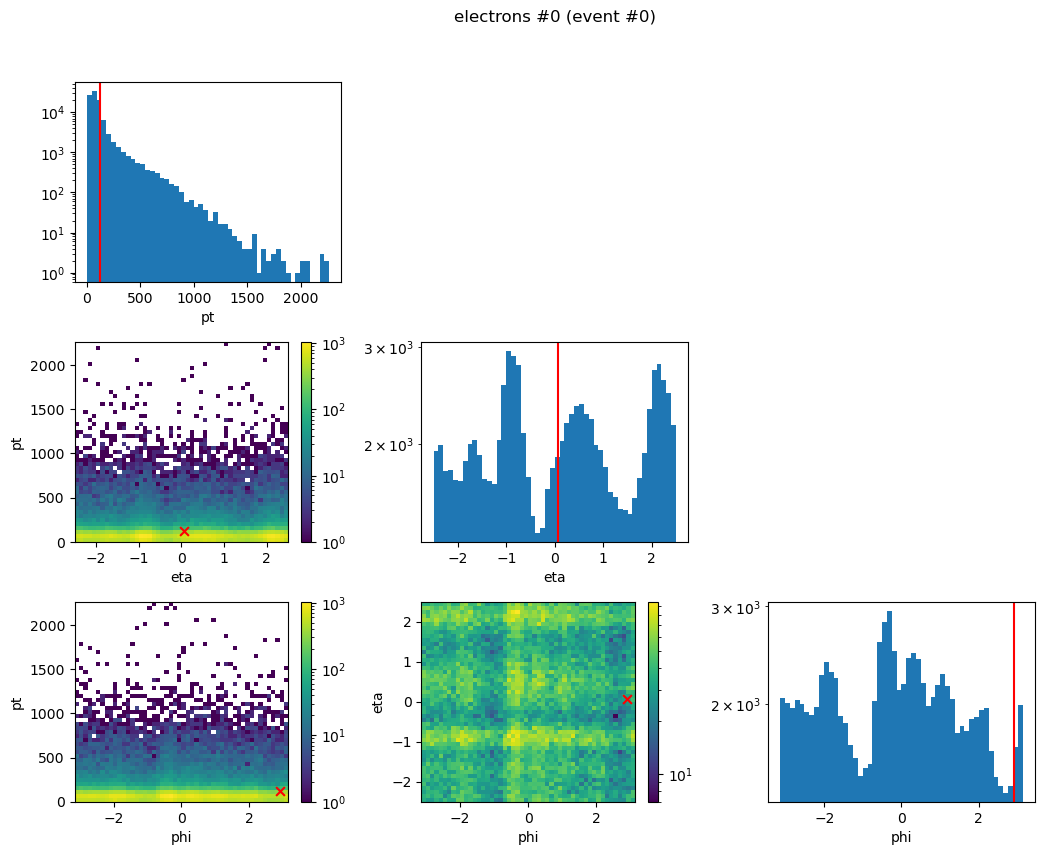

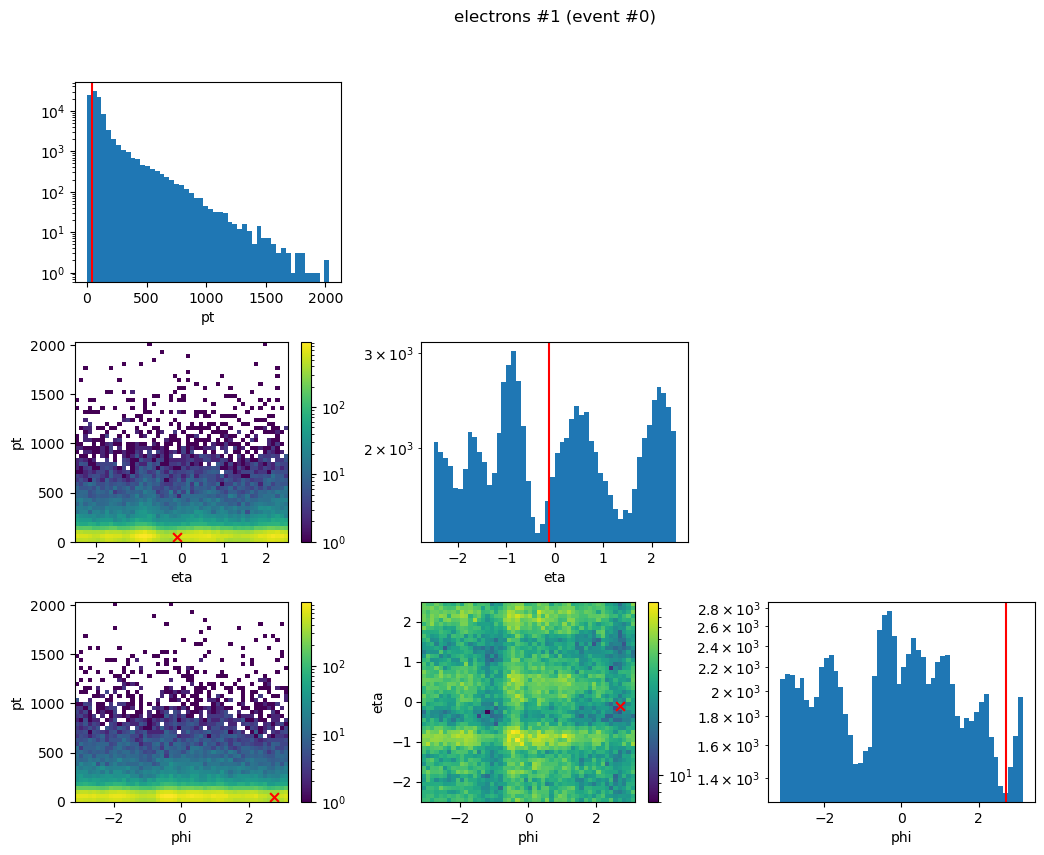

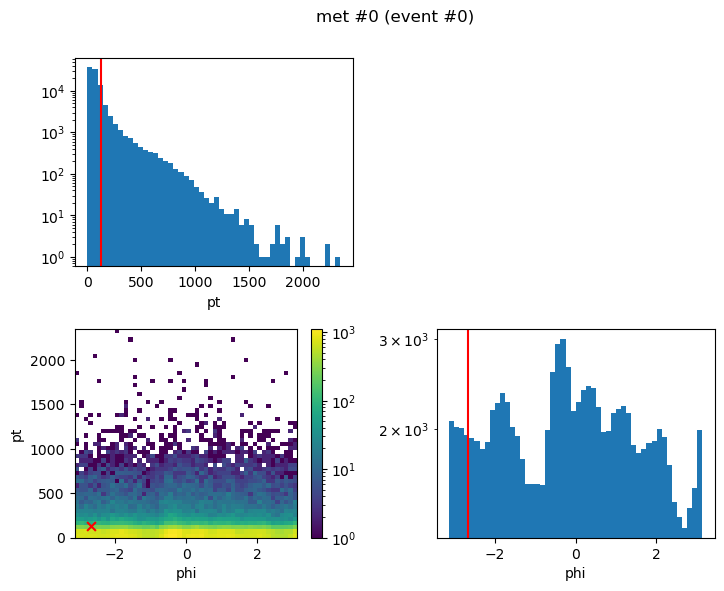

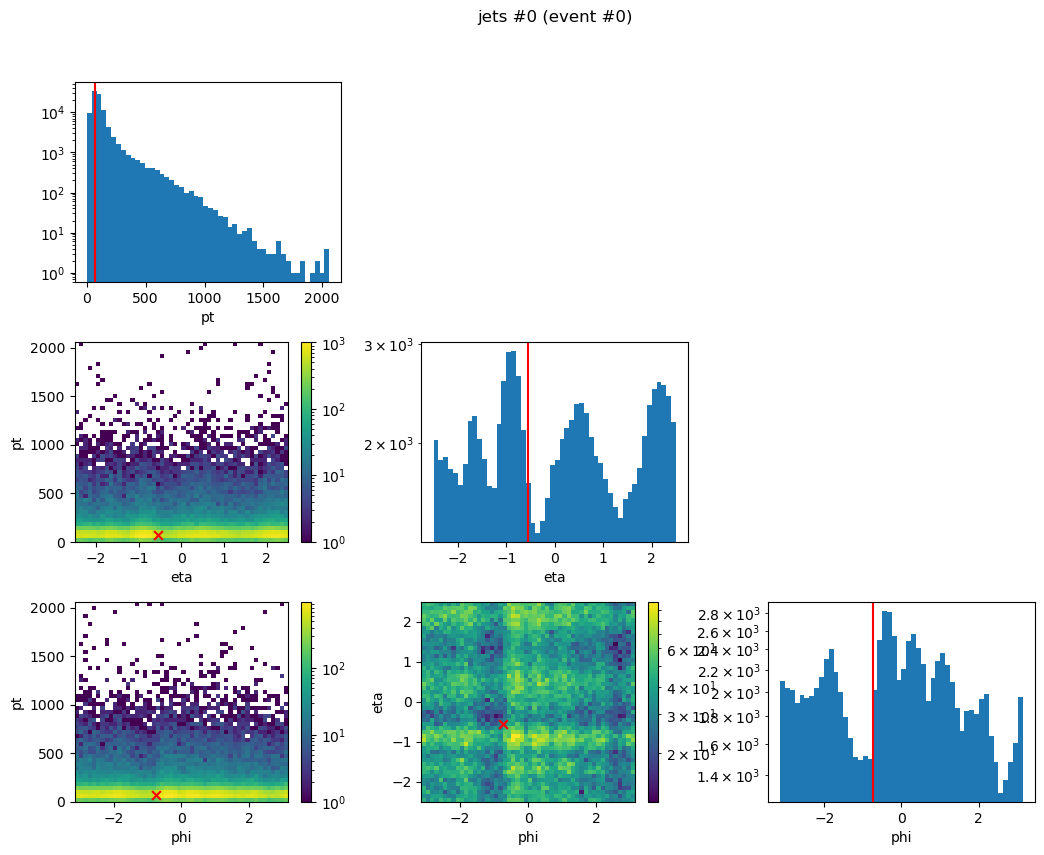

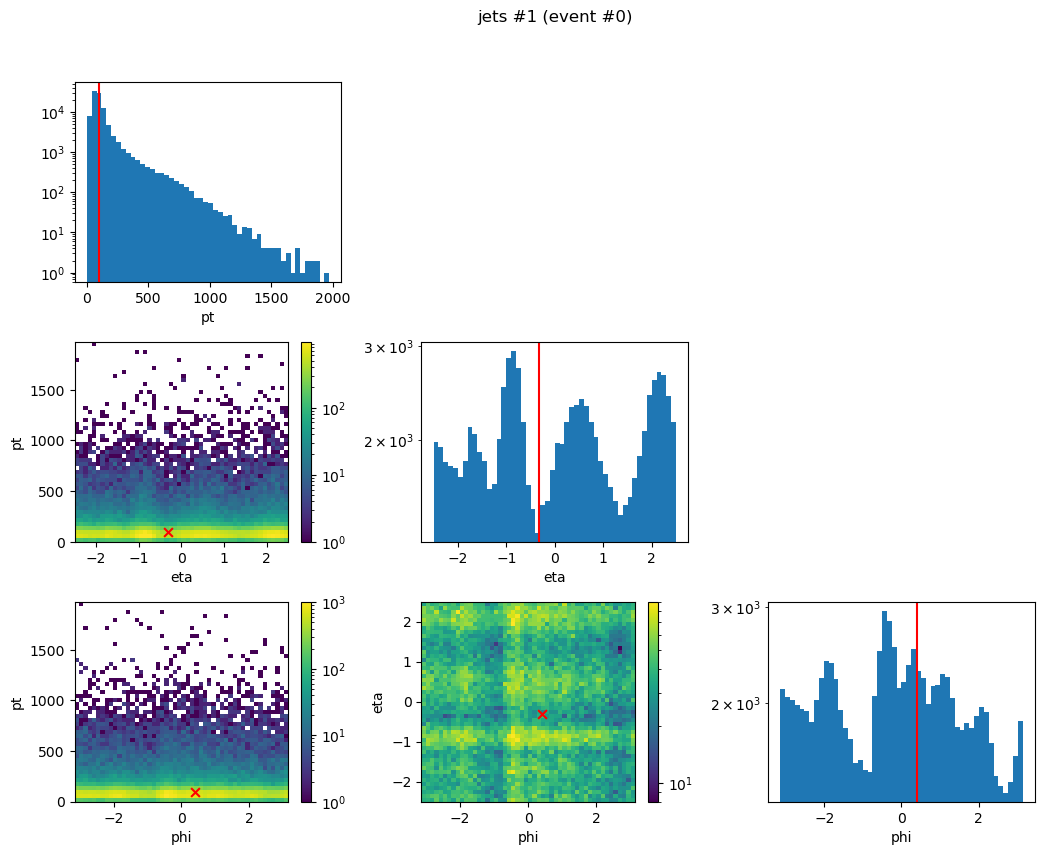

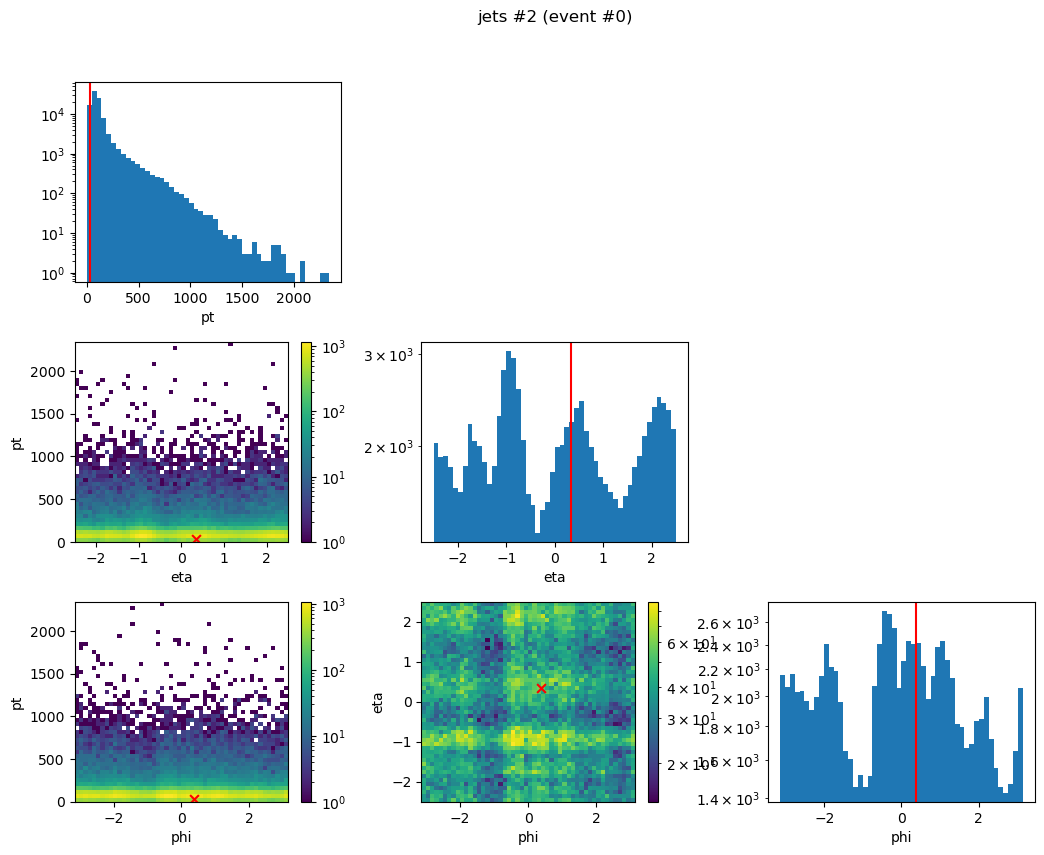

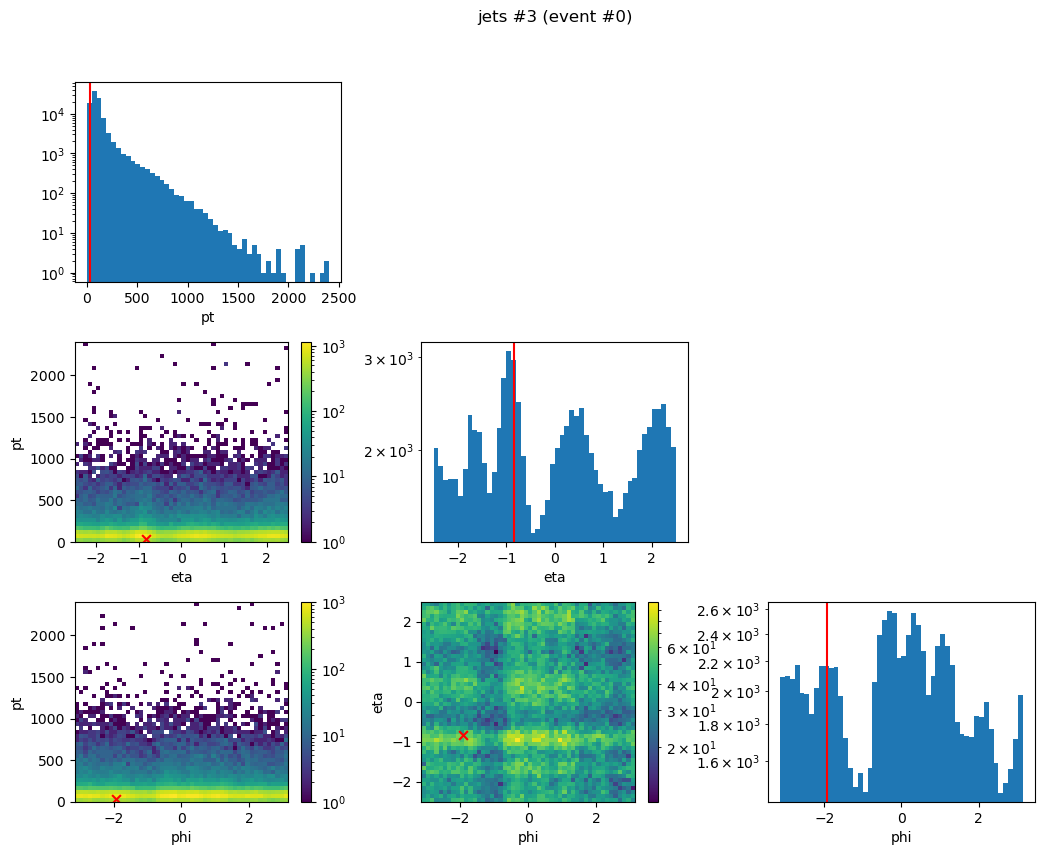

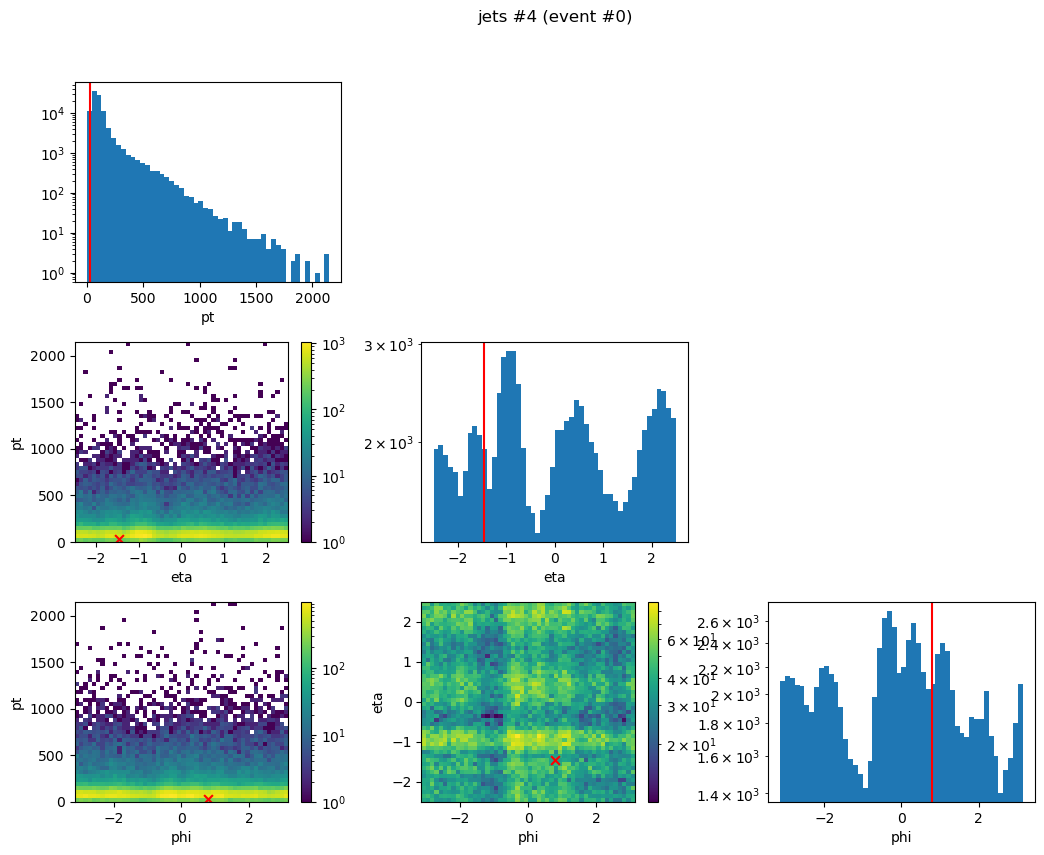

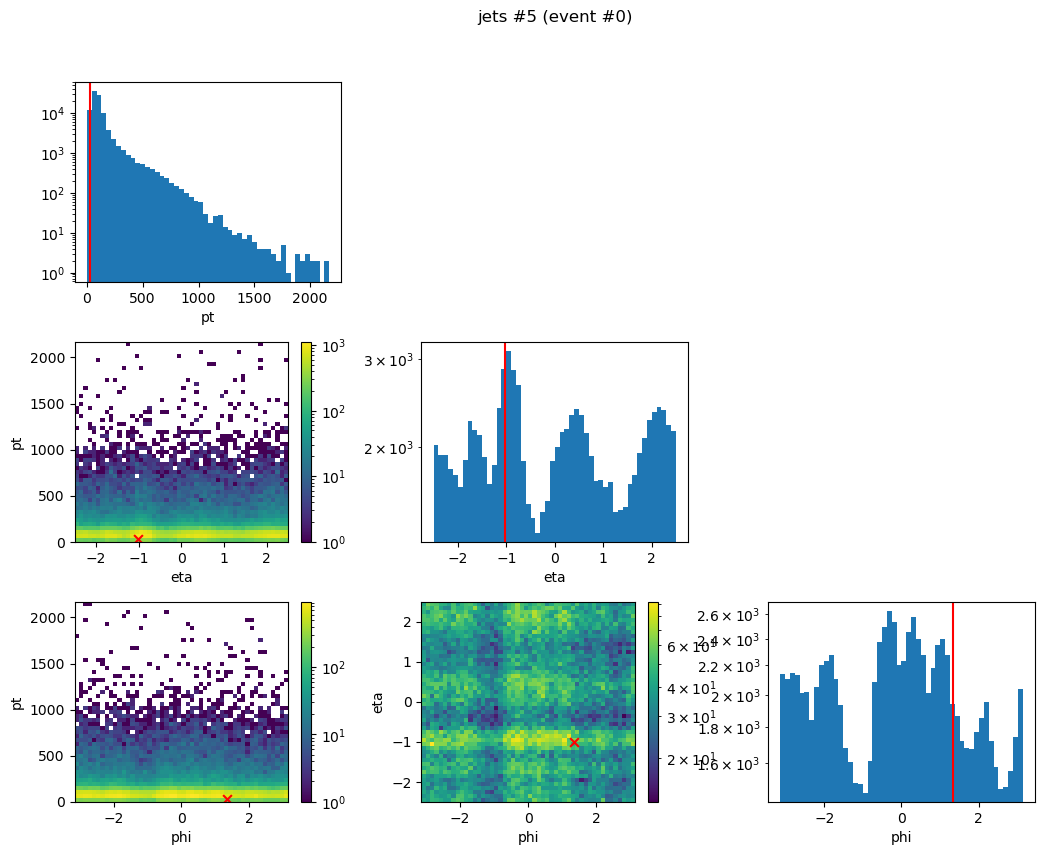

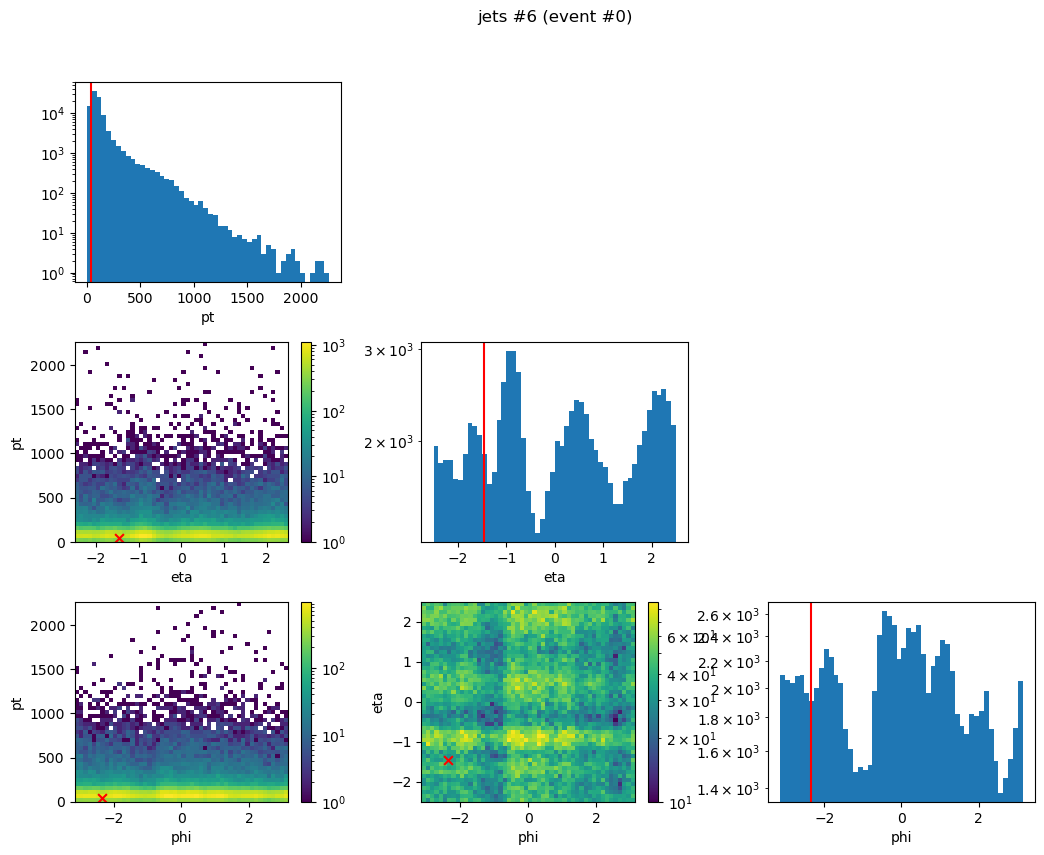

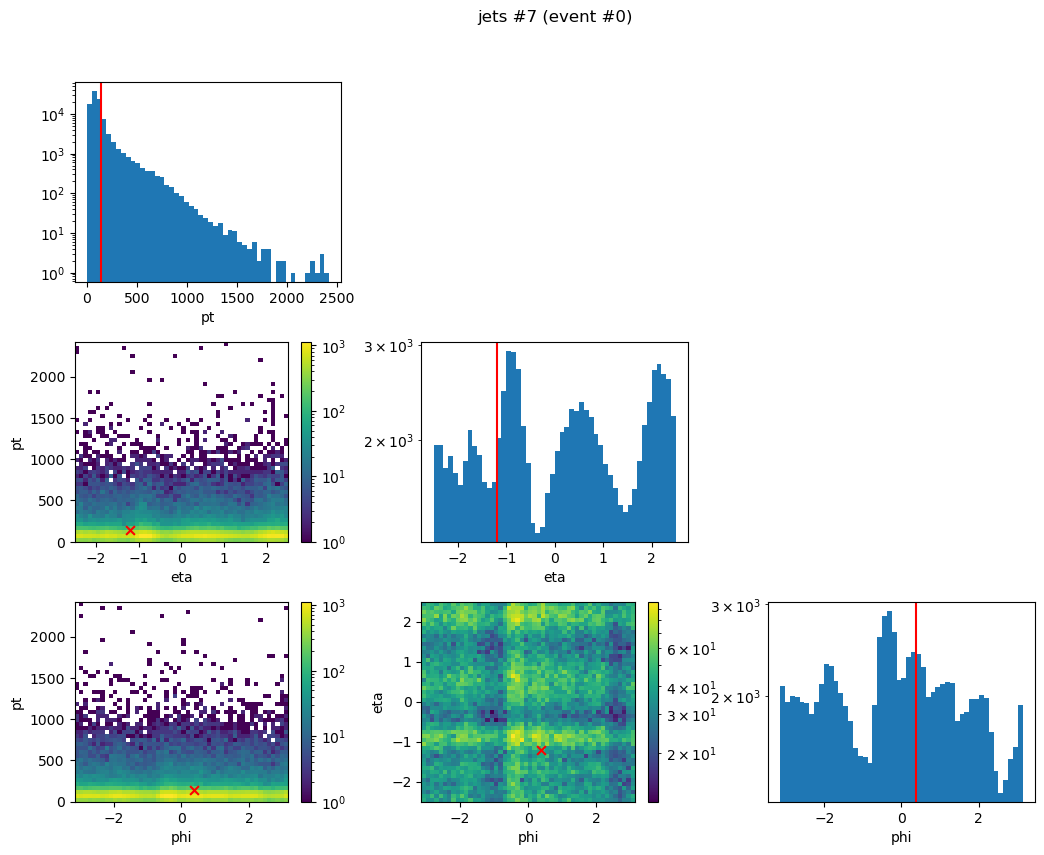

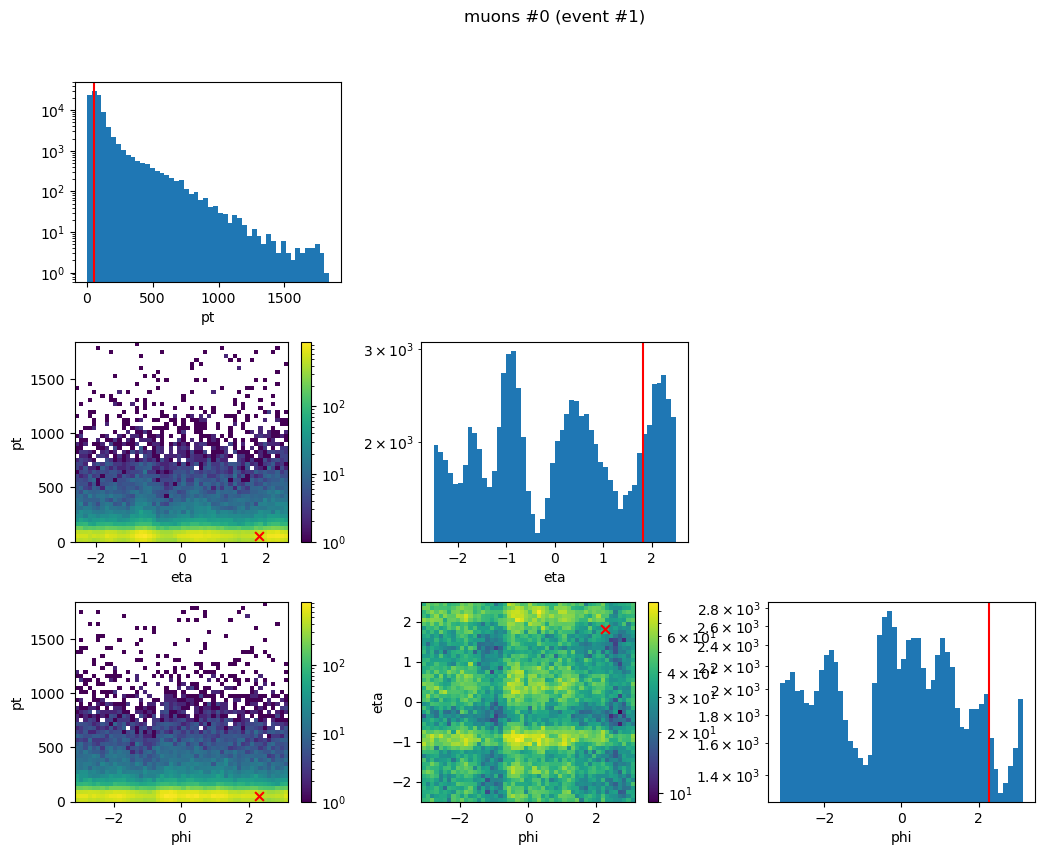

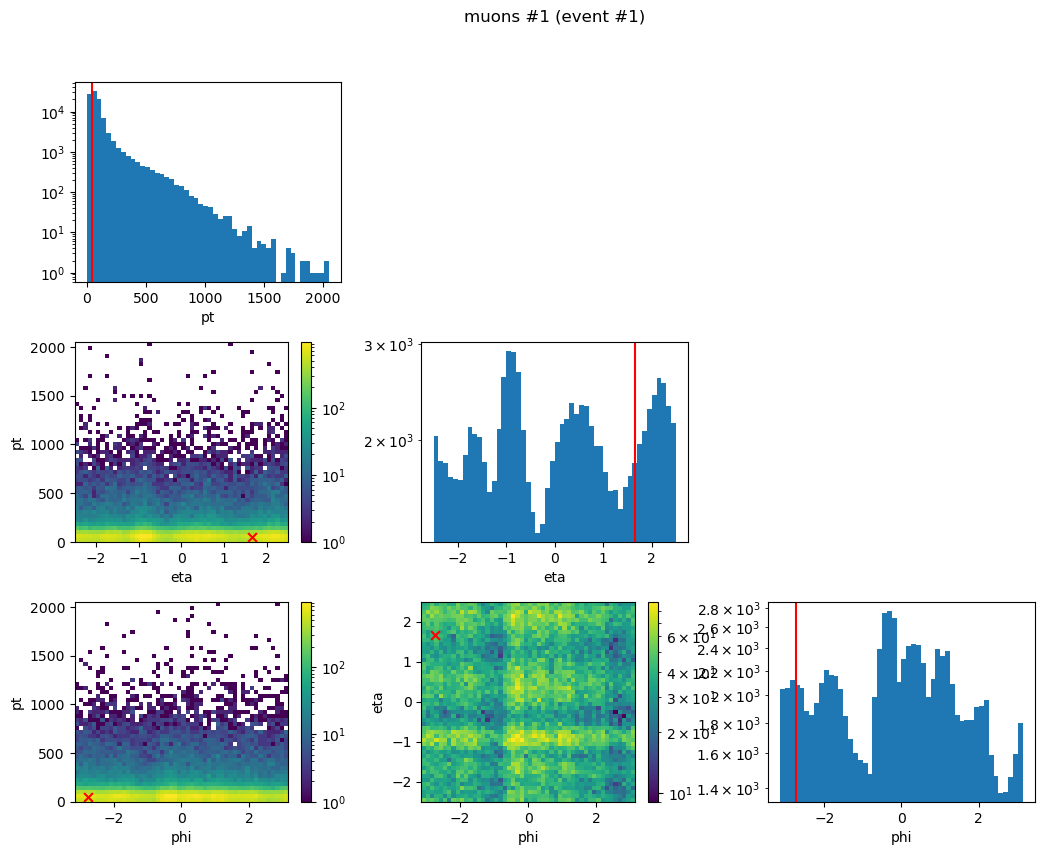

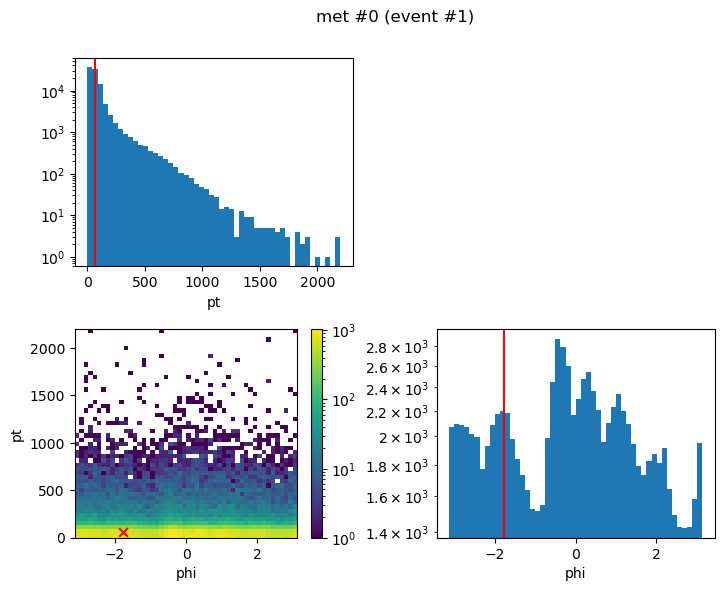

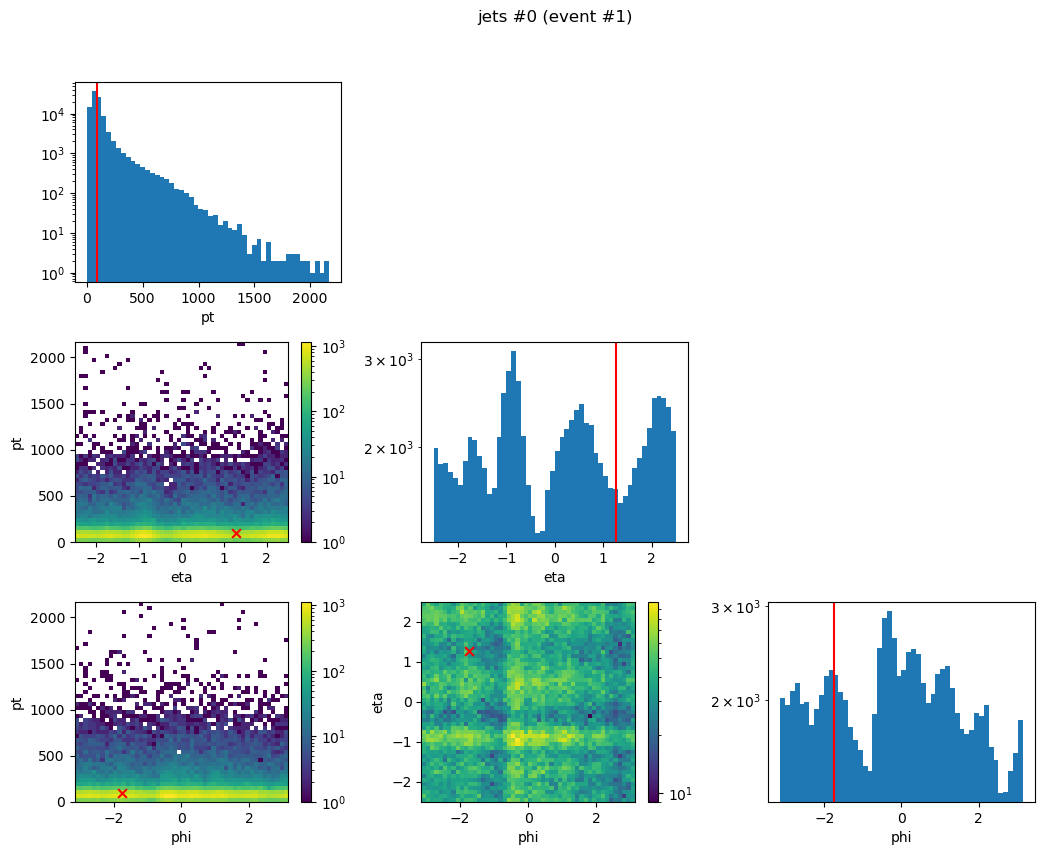

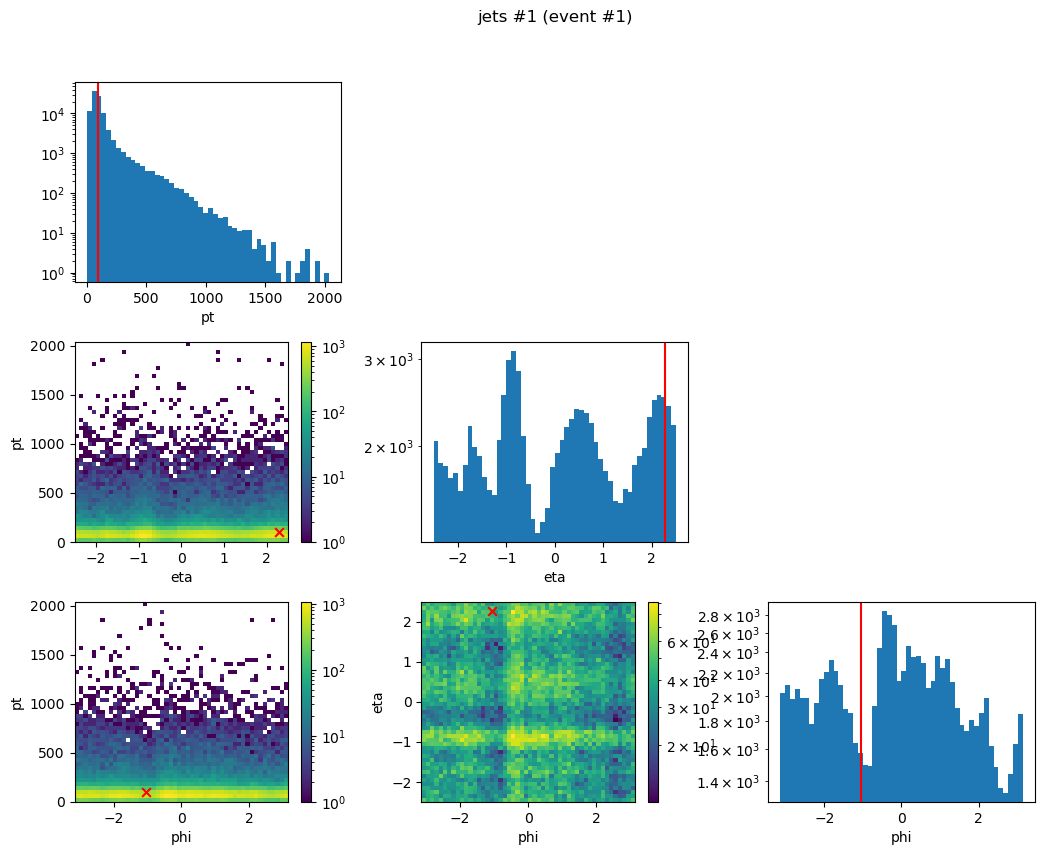

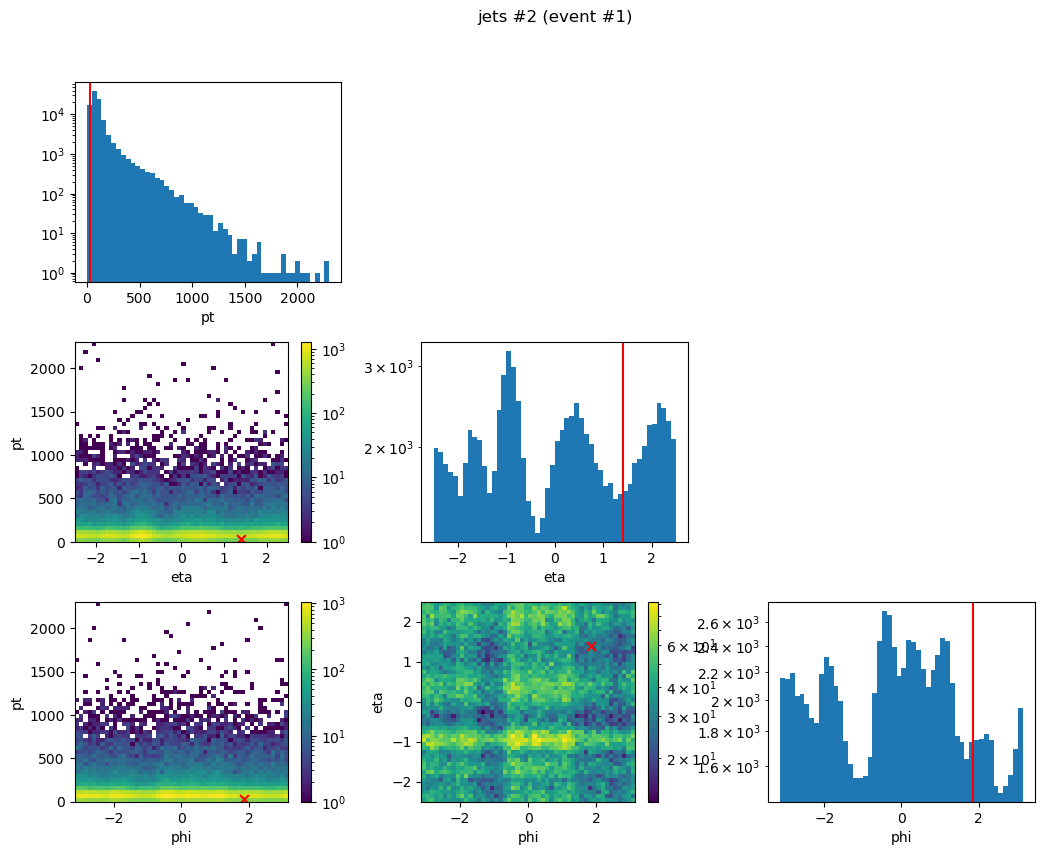

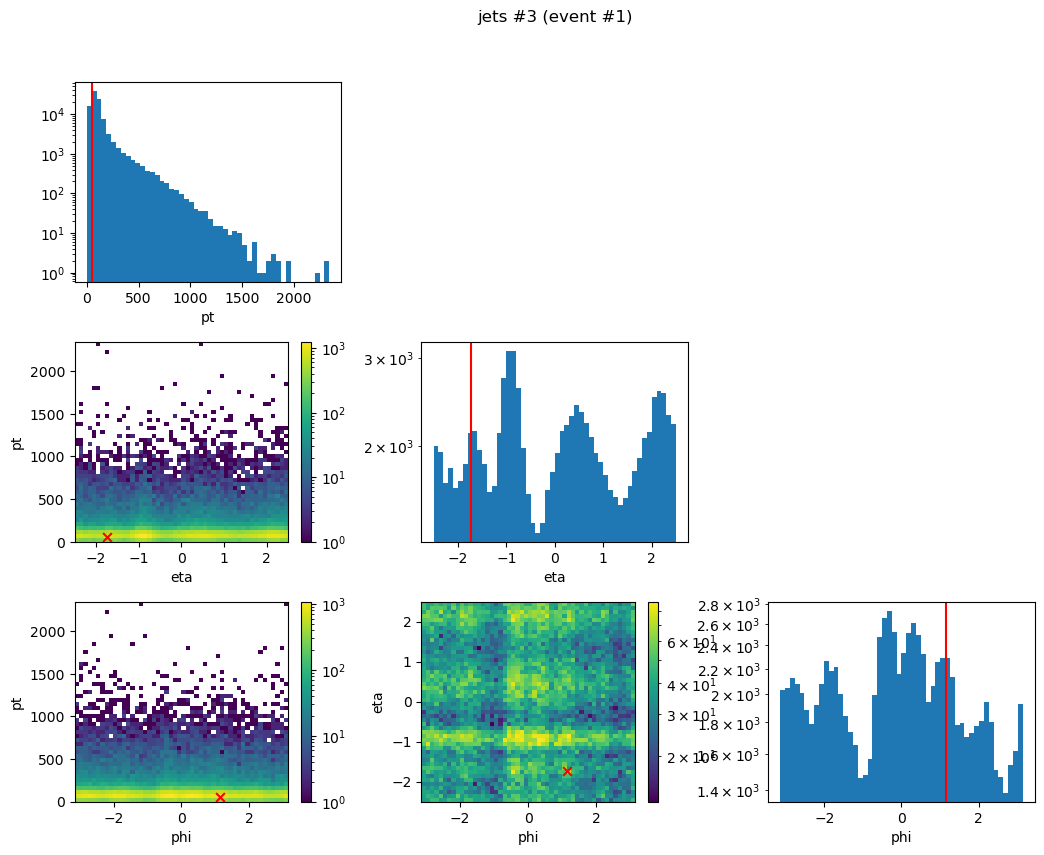

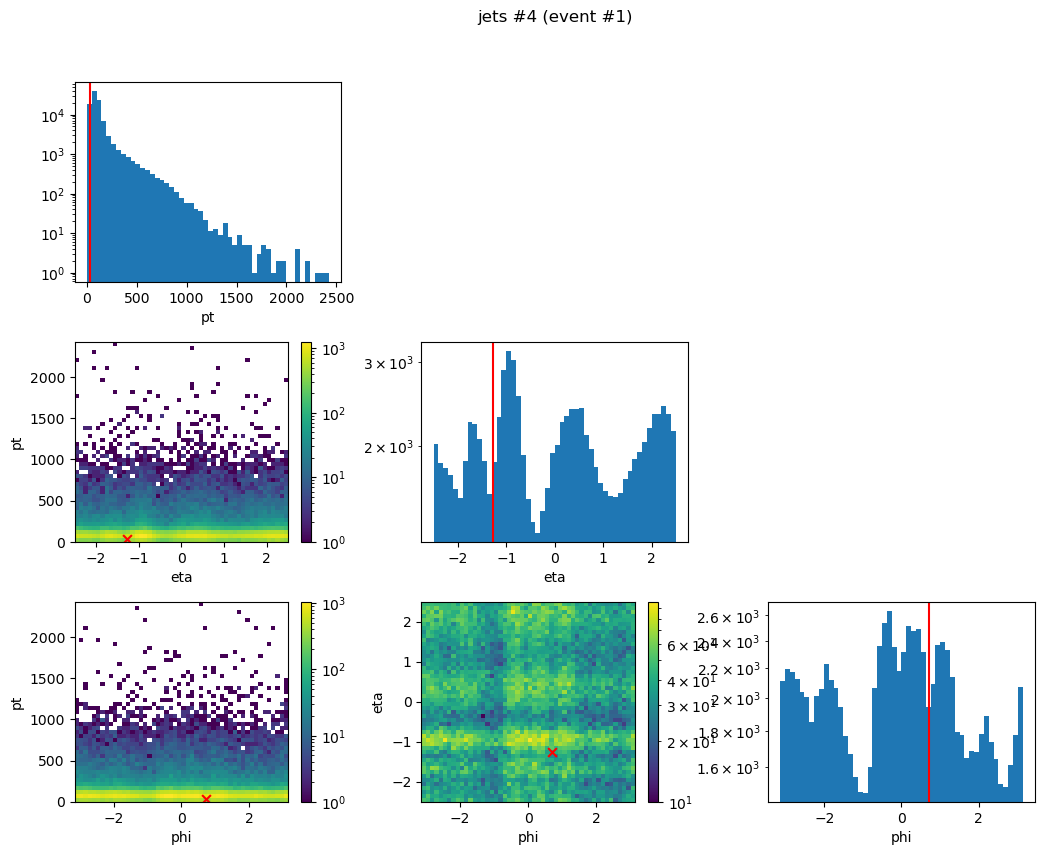

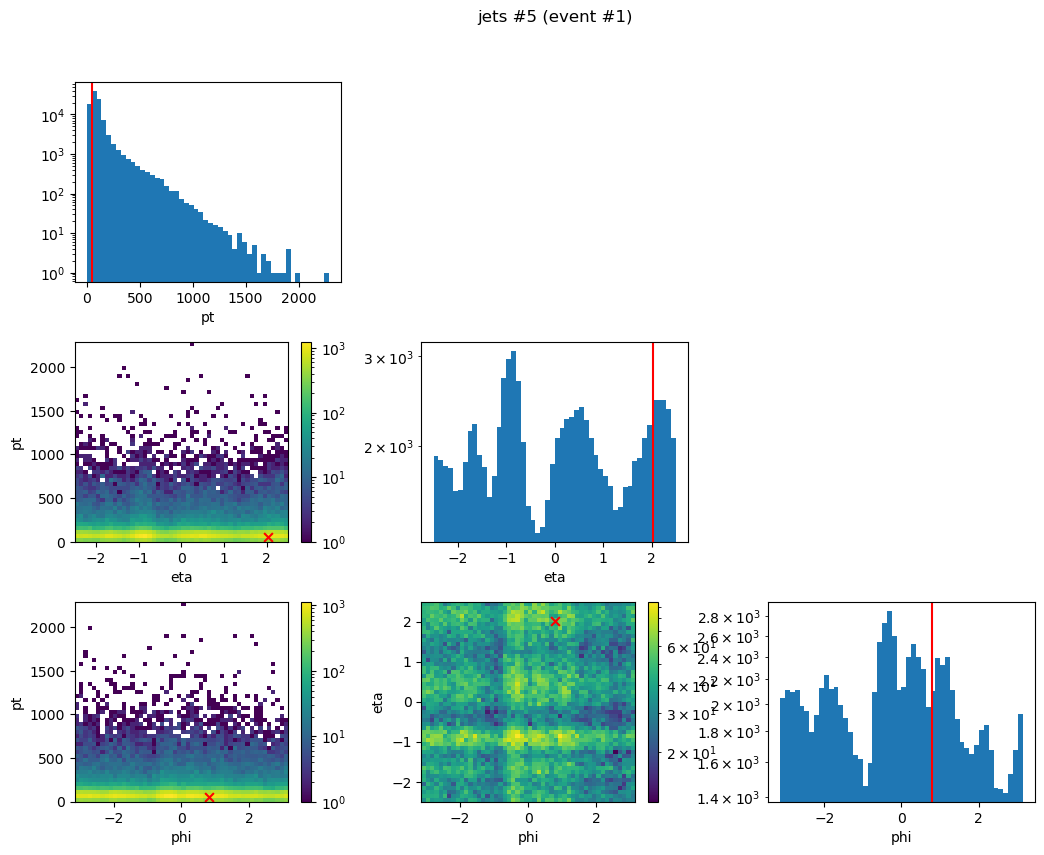

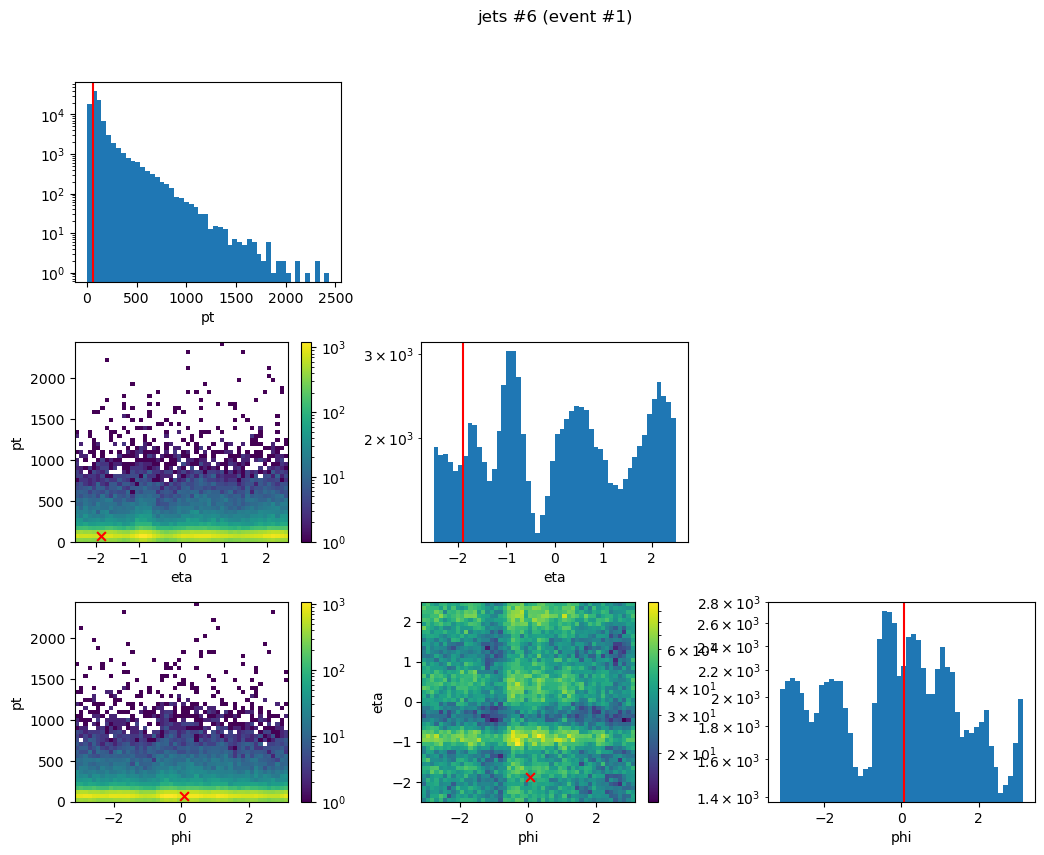

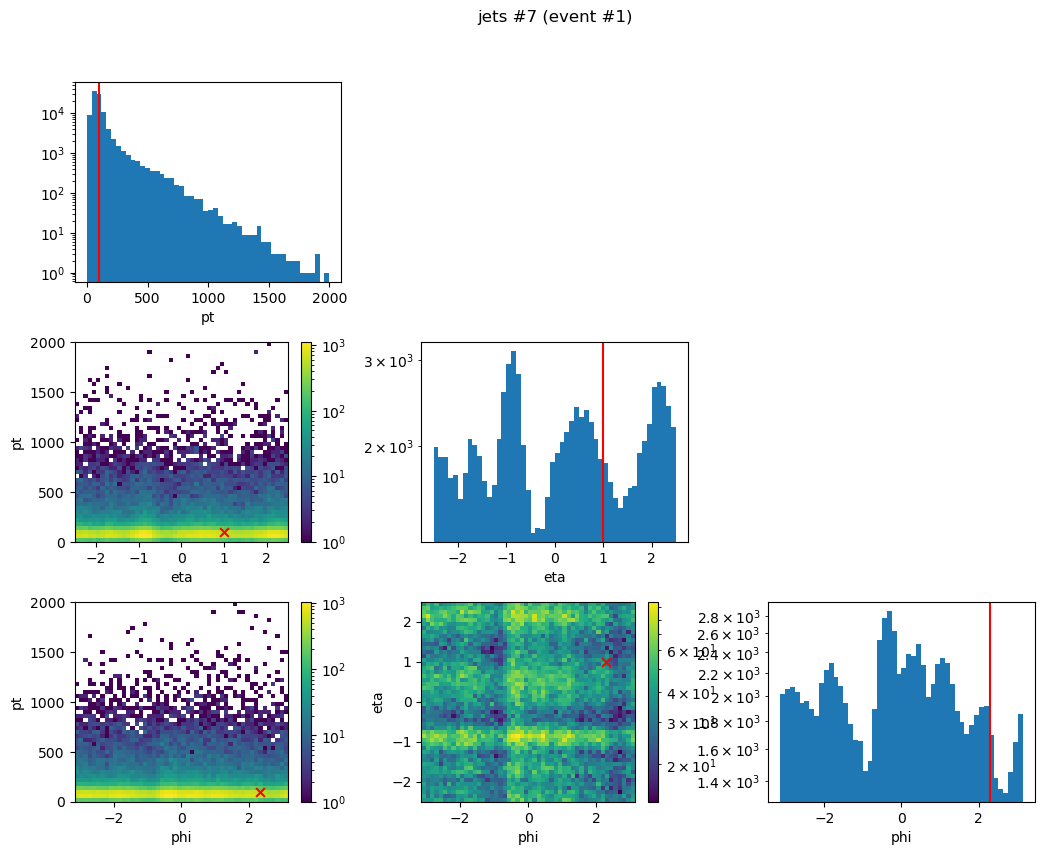

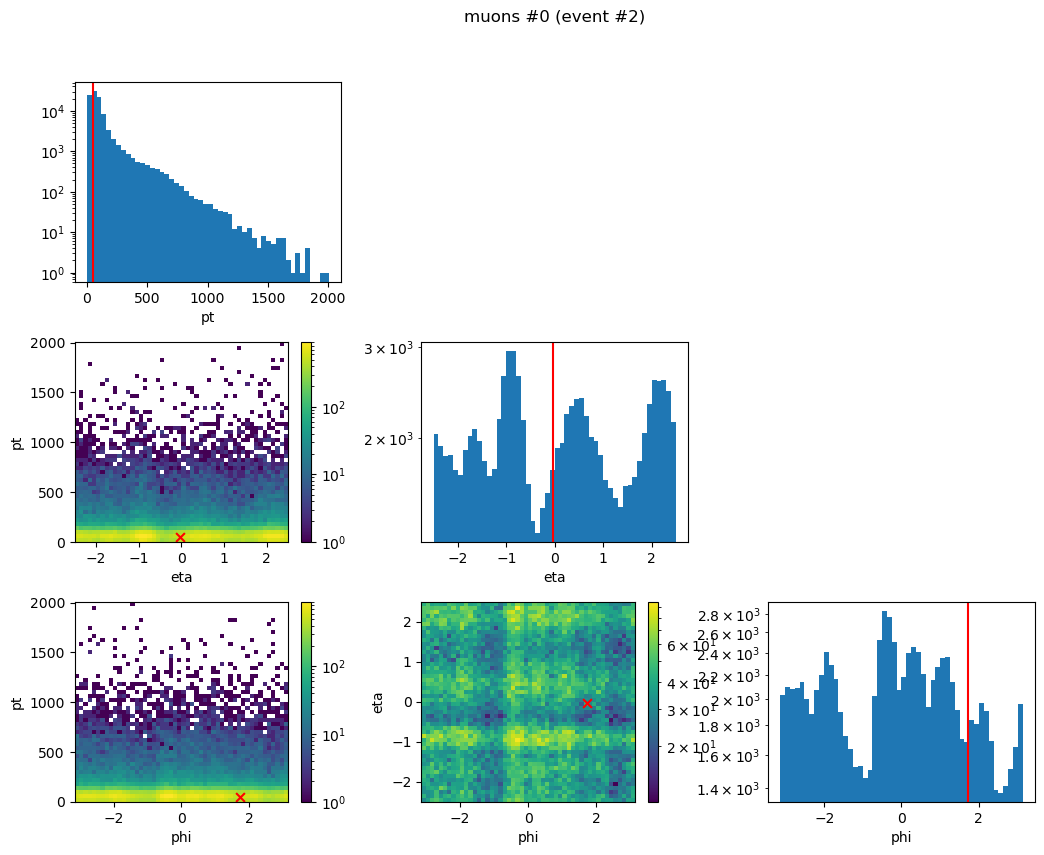

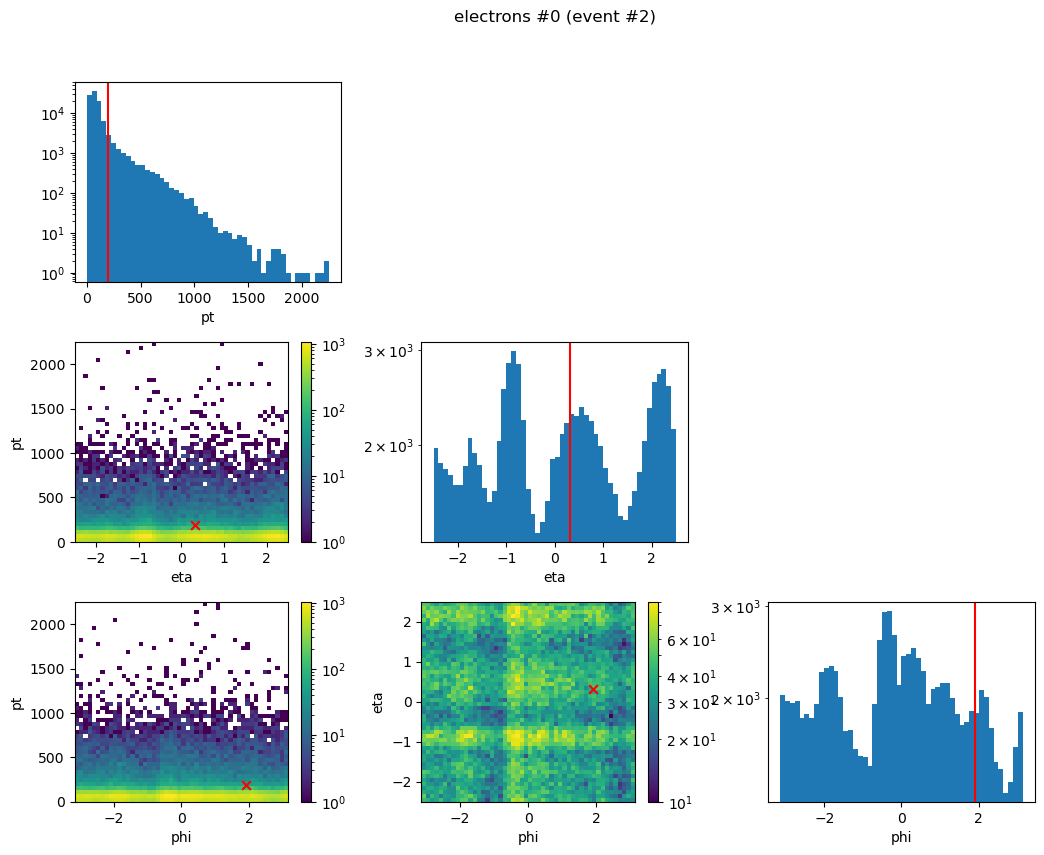

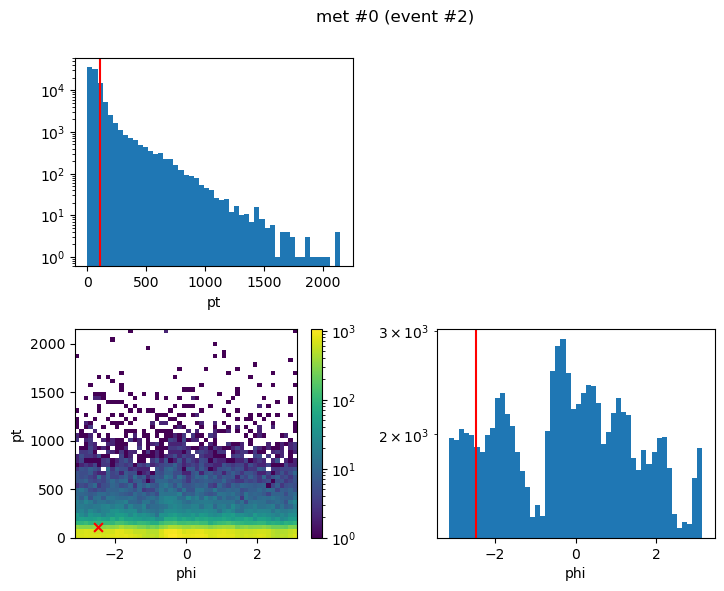

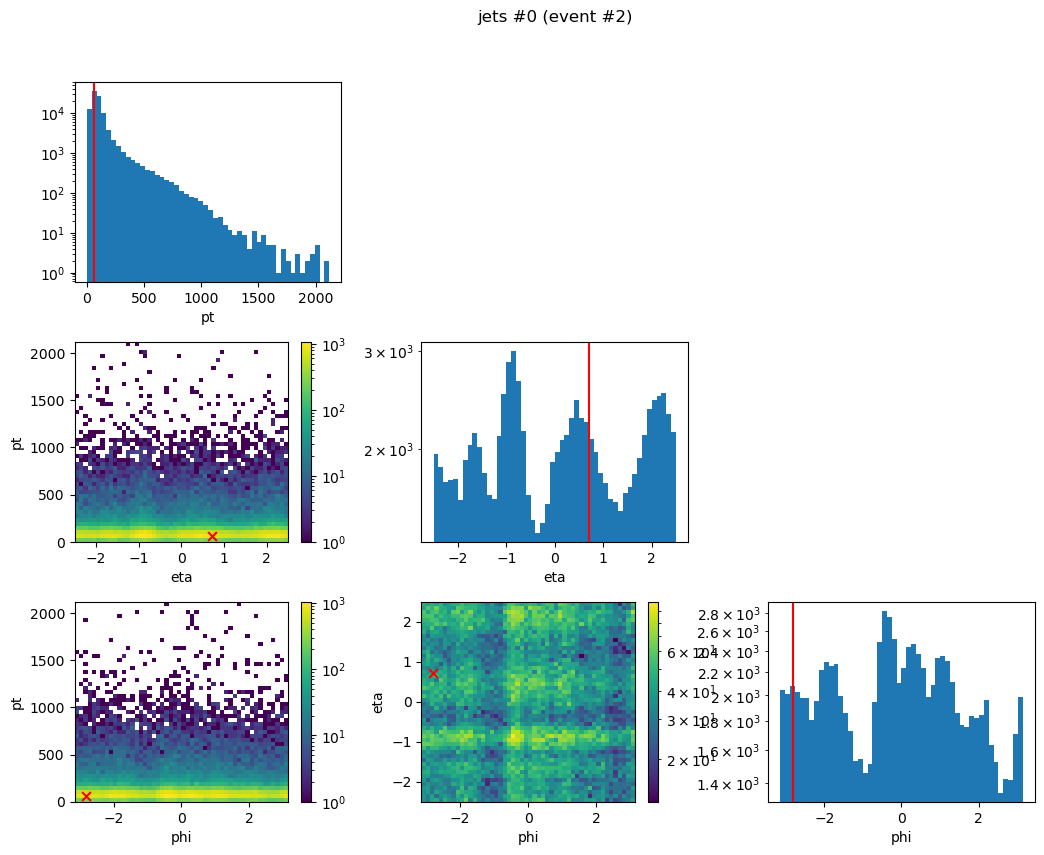

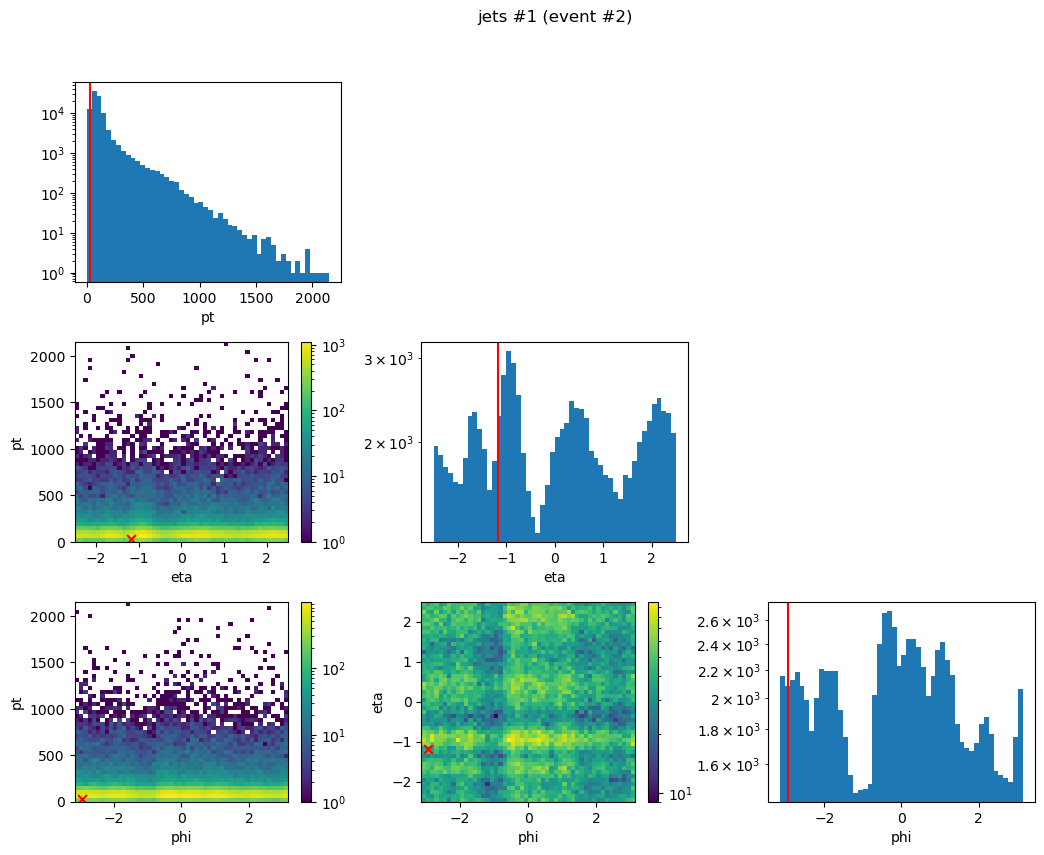

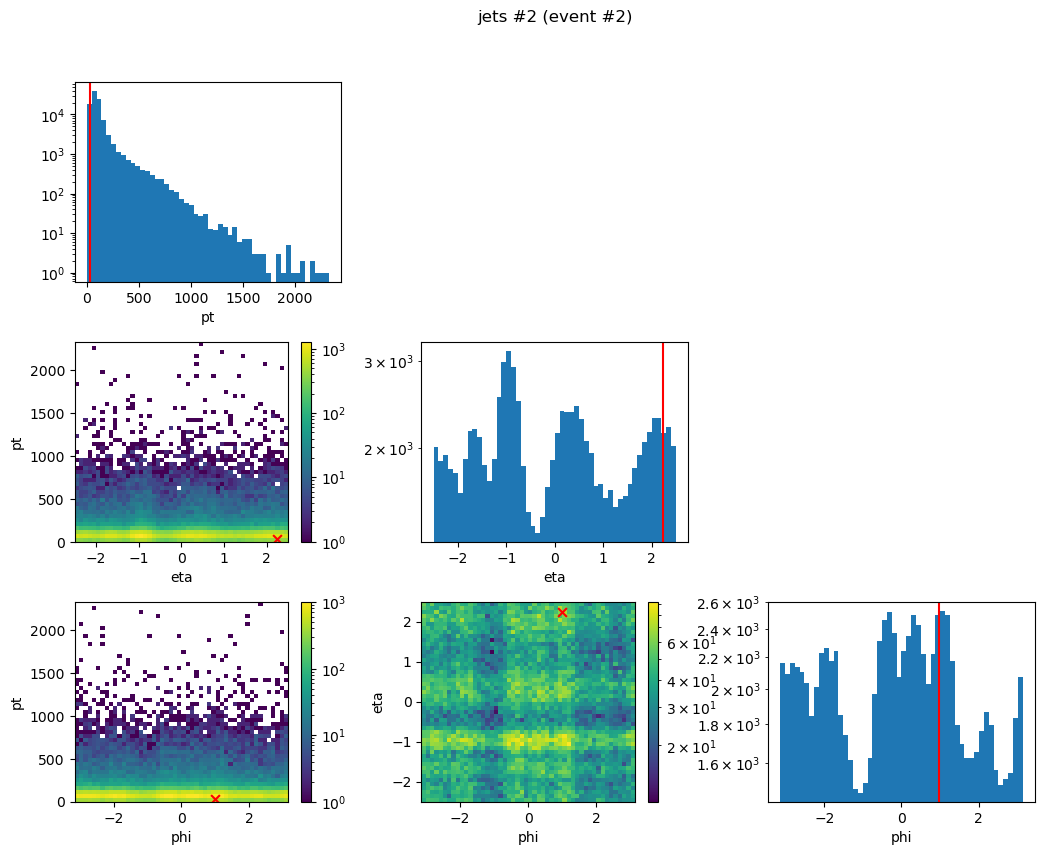

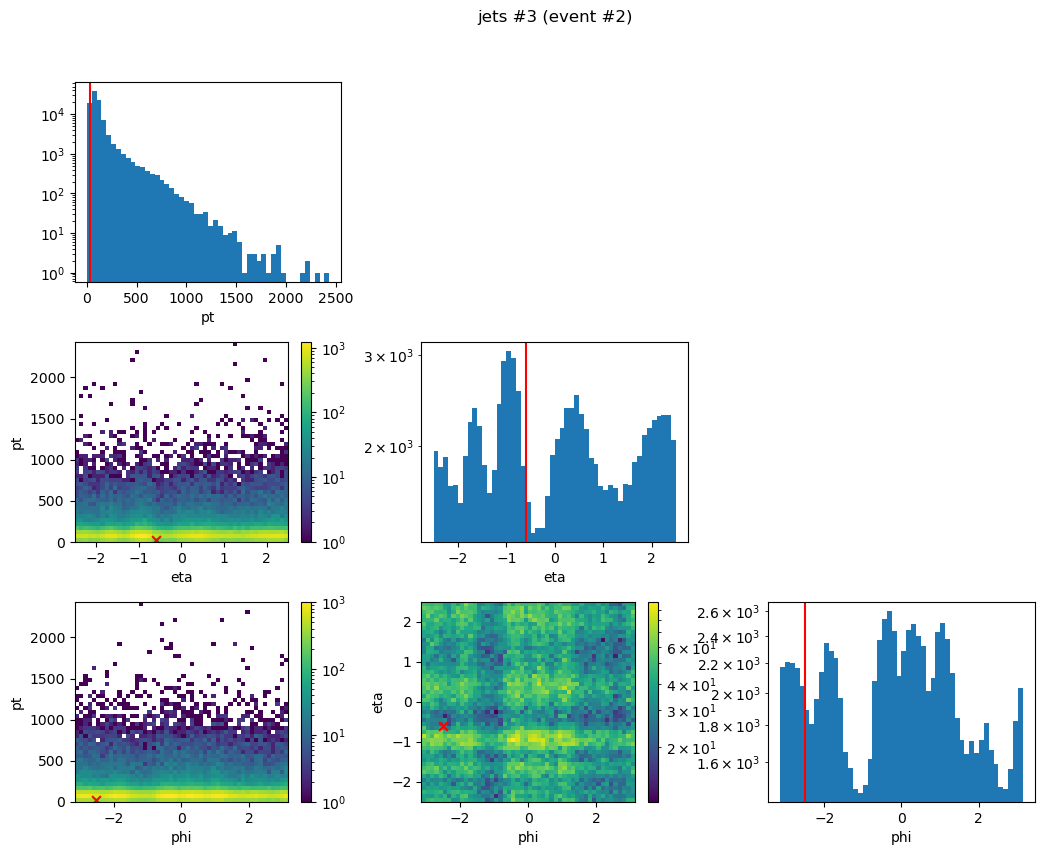

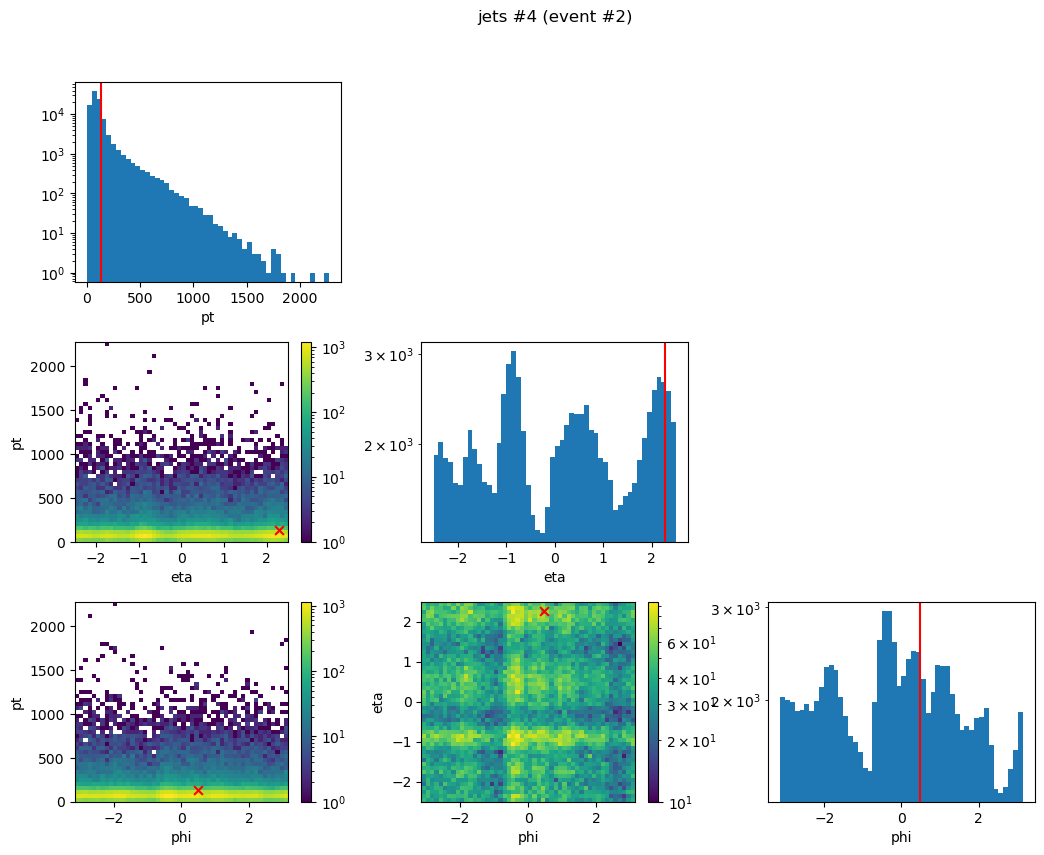

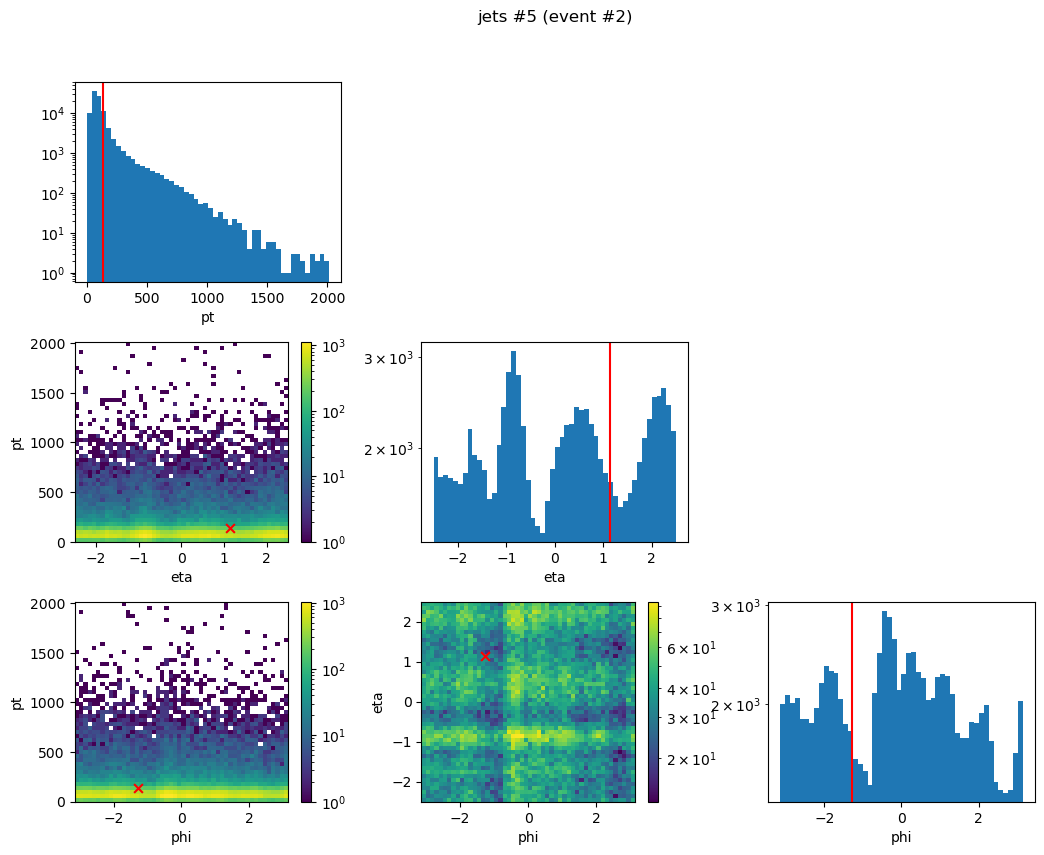

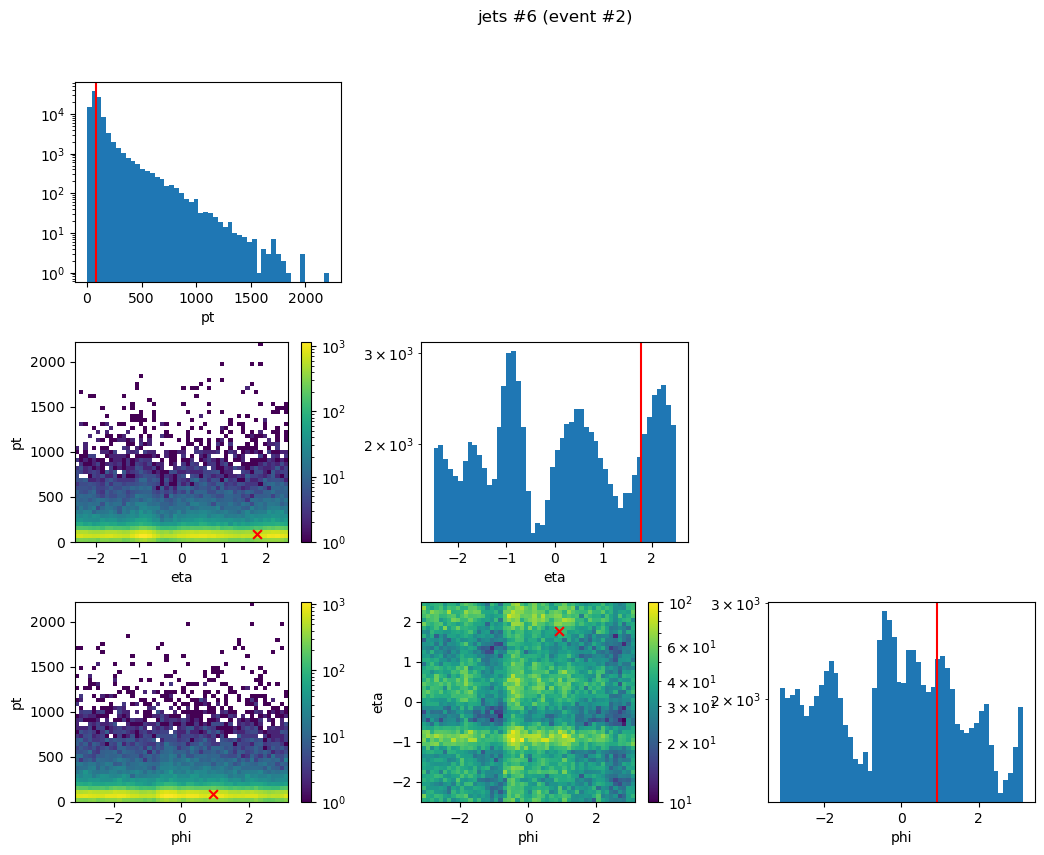

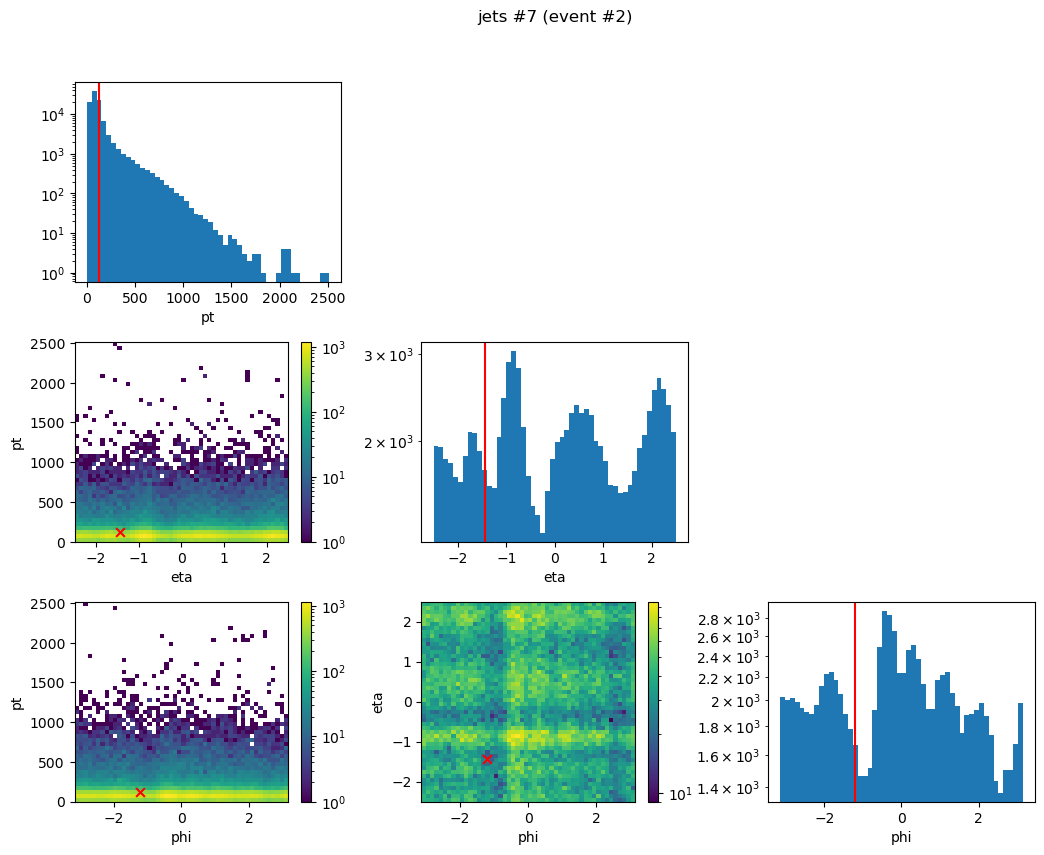

In [13]:
model = model.cuda()
sampling_HH = SamplingCallback(
    dataset = comb_dataset,
    idx_to_monitor = idx_to_monitor,
    N_sample = 100000, 
    frequency = 5,
    raw = True,
    bins = 51,
    log_scale = True,
)
#figs = sampling.make_sampling_plots(model,show=True)

In [ ]:
##### Parameters #####
epochs = 200
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb_train.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3)
model.set_optimizer(optimizer)

##### Scheduler #####
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer = optimizer, 
#     max_lr = 1e-3, 
#     epochs = epochs, 
#     steps_per_epoch = steps_per_epoch_train, 
#     pct_start = 0.25,
#     anneal_strategy='linear', 
#     cycle_momentum=True, 
#     base_momentum=0.85, 
#     max_momentum=0.95, 
#     div_factor=1e1, 
#     final_div_factor=1e1,
#     three_phase = True,
# )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.5, 
    patience=10, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=5, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    #sampling,
    bias_HH, bias_TT, bias_DY
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'combined',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)

CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Training   : Batch size = 1024 => 507 steps per epoch


COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/2c0515c62262469d85f3bda4c6ebe6aa

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode
------------------------------------------------------------------
0 | hard_embeddings     | ModuleList       

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [ ]:
torch.save(model,'TF_2.pt')

In [ ]:
#model = torch.load('TF.pt')

In [ ]:
figs = sampling.make_sampling_plots(model,show=True)


In [ ]:
model = model.cuda()
bias = BiasCallback(
    dataset = comb_dataset,
    N_sample = 100,
    frequency = 10,
    raw = True,
    bins = 101,
    points = 20,
    log_scale = True,
    batch_size = 10000,
    #N_batch = 1,
)
figs = bias.make_bias_plots(model,show=True)